In [2]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import HeatMap
import os

In [3]:
file_path = '/home/jovyan/CASA_Study/DS/2024-06-25-custom-cui.csv'
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    print(f"File found: {file_path}")

File found: /home/jovyan/CASA_Study/DS/2024-06-25-custom-cui.csv


In [4]:
data = pd.read_csv(file_path, low_memory=False)

In [5]:
print(data)

       voaBillingAuthorityName      voaUARN laBillingReferenceCode  \
0               City of London     13930052         00000121800007   
1               City of London     13931052         00000121810009   
2               City of London     13932052         0000012182000B   
3               City of London     13935052         00000121840004   
4               City of London     13936052         00000121850006   
...                        ...          ...                    ...   
591544             Westminster  14644448000           400657400709   
591545             Westminster  14645939000           400622105416   
591546             Westminster  14650575000           400392452703   
591547             Westminster  14658188000           400584611500   
591548             Westminster  14658289000           400134306201   

            laRatepayerName laAccountStartDate laRecordDate laOccupationState  \
0       TOM HIXSON & CO LTD                NaN   2023-12-01              True 

In [6]:
import pandas as pd

# 加载本地文件
onspd_data = pd.read_csv('/home/jovyan/CASA_Study/DS/ONSPD_MAY_2024_UK.csv')

# 查看文件中包含的列名，确保lsoa11、pcd、lat、long存在
print(onspd_data.columns)

/tmp/ipykernel_47295/763785482.py:4: DtypeWarning: Columns (18,31,40,45,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  onspd_data = pd.read_csv('/home/jovyan/CASA_Study/DS/ONSPD_MAY_2024_UK.csv')


Index(['pcd', 'pcd2', 'pcds', 'dointr', 'doterm', 'oscty', 'ced', 'oslaua',
       'osward', 'parish', 'usertype', 'oseast1m', 'osnrth1m', 'osgrdind',
       'oshlthau', 'nhser', 'ctry', 'rgn', 'streg', 'pcon', 'eer', 'teclec',
       'ttwa', 'pct', 'itl', 'statsward', 'oa01', 'casward', 'npark', 'lsoa01',
       'msoa01', 'ur01ind', 'oac01', 'oa11', 'lsoa11', 'msoa11', 'wz11',
       'sicbl', 'bua11', 'buasd11', 'ru11ind', 'oac11', 'lat', 'long', 'lep1',
       'lep2', 'pfa', 'imd', 'calncv', 'icb', 'oa21', 'lsoa21', 'msoa21'],
      dtype='object')


In [7]:
# 保留 pcds, lsoa11, msoa11 列，删除其他列
onspd_data1 = onspd_data[['pcds', 'lsoa11', 'msoa11','lat', 'long']]

# 查看修改后的数据集
print(onspd_data1.head())

      pcds     lsoa11     msoa11        lat      long
0  AB1 0AA  S01006514  S02001237  57.101474 -2.242851
1  AB1 0AB  S01006514  S02001237  57.102554 -2.246308
2  AB1 0AD  S01006514  S02001237  57.100556 -2.248342
3  AB1 0AE  S01006853  S02001296  57.084444 -2.255708
4  AB1 0AF  S01006511  S02001236  57.096656 -2.258102


In [9]:
import pandas as pd

# 假设 onspd_data 和 data 已经加载为 DataFrame

# 映射 LSOA 编码和经纬度信息
data_merged = pd.merge(data, onspd_data1[['pcds', 'lsoa11','msoa11', 'lat', 'long']],
                       left_on='voaPropertyPostcode', right_on='pcds', how='left')

# 删除不必要的列（如 pcd 列，因为它已映射完成）
data_merged.drop(columns=['pcds'], inplace=True)

# 查看合并后的数据
print(data_merged.head())

  voaBillingAuthorityName   voaUARN laBillingReferenceCode  \
0          City of London  13930052         00000121800007   
1          City of London  13931052         00000121810009   
2          City of London  13932052         0000012182000B   
3          City of London  13935052         00000121840004   
4          City of London  13936052         00000121850006   

       laRatepayerName laAccountStartDate laRecordDate laOccupationState  \
0  TOM HIXSON & CO LTD                NaN   2023-12-01              True   
1       CITY OF LONDON                NaN   2023-12-01             False   
2       CITY OF LONDON                NaN   2023-12-01             False   
3       CITY OF LONDON                NaN   2023-12-01             False   
4       CITY OF LONDON                NaN   2023-12-01             False   

  laOccupationStateDate  laRatesPaid laRatesReliefs  ...  voaStartDate  \
0            1995-04-01          0.0            NaN  ...    2021-09-08   
1            2015-12-2

In [10]:
unique_lsoa_count = data_merged['lsoa11'].nunique()

# 打印结果
print(f"Number of unique LSOA codes: {unique_lsoa_count}")

Number of unique LSOA codes: 3899


In [11]:
nan_count = data_merged['lsoa11'].isna().sum()

# 打印结果
print(f"Number of NaN values in lsoa11: {nan_count}")

Number of NaN values in lsoa11: 0


In [12]:
import pandas as pd

# 确保 laRecordDate 和 laOccupationStateDate 列为日期格式，并处理异常值
data_merged['laRecordDate'] = pd.to_datetime(data_merged['laRecordDate'], errors='coerce')
data_merged['laOccupationStateDate'] = pd.to_datetime(data_merged['laOccupationStateDate'], errors='coerce')

# 计算时间差并创建新的列 'retail_lifetime'，以天为单位
data_merged['retail_lifetime'] = (data_merged['laRecordDate'] - data_merged['laOccupationStateDate']).dt.days

# 删除 retail_lifetime 中为 NaN 的行
data_merged = data_merged.dropna(subset=['retail_lifetime'])

# 查看结果
print(data_merged[['laRecordDate', 'laOccupationStateDate', 'retail_lifetime']])

       laRecordDate laOccupationStateDate  retail_lifetime
0        2023-12-01            1995-04-01          10471.0
1        2023-12-01            2015-12-23           2900.0
2        2023-12-01            2015-12-23           2900.0
3        2023-12-01            2015-12-23           2900.0
4        2023-12-01            2015-12-23           2900.0
...             ...                   ...              ...
526931   2024-01-24            2023-10-01            115.0
526932   2024-01-24            2023-10-01            115.0
526933   2024-01-24            2023-10-01            115.0
526934   2024-01-24            2023-10-01            115.0
526935   2024-01-24            2023-10-01            115.0

[415358 rows x 3 columns]


In [13]:
import pandas as pd

# 确保 data 数据集中包含 msoa11 和 retail_lifetime 列
# 计算每个 msoa11 对应的平均 retail_lifetime
average_retail_lifetime_msoa = data_merged.groupby('msoa11')['retail_lifetime'].mean().reset_index()

# 重命名列名为更具描述性
average_retail_lifetime_msoa.columns = ['msoa11', 'average_retail_lifetime']

# 查看结果
print(average_retail_lifetime_msoa)

        msoa11  average_retail_lifetime
0    E02000001              4126.993900
1    E02000002              2579.563492
2    E02000003              2478.424207
3    E02000004              2380.212500
4    E02000005              2320.712984
..         ...                      ...
886  E02006927              2478.087302
887  E02006928              2693.254717
888  E02006929              1944.196457
889  E02006930              2462.390105
890  E02006931              2691.716641

[891 rows x 2 columns]


In [15]:
import pandas as pd

# 确保 data 数据集中包含 lsoa11 和 retail_lifetime 列
# 计算每个 lsoa11 对应的平均 retail_lifetime
average_retail_lifetime_lsoa = data_merged.groupby('lsoa11')['retail_lifetime'].mean().reset_index()

# 重命名列名为更具描述性
average_retail_lifetime_lsoa.columns = ['lsoa11', 'average_retail_lifetime']

# 查看结果
print(average_retail_lifetime_lsoa)

         lsoa11  average_retail_lifetime
0     E01000001              4055.866029
1     E01000002              4040.590909
2     E01000003              5205.692308
3     E01000005              3860.038298
4     E01000007              2237.134328
...         ...                      ...
3478  E01033738              3073.434783
3479  E01033741              3226.920000
3480  E01033743              2661.080000
3481  E01033744              4079.800000
3482  E01033746              3086.750000

[3483 rows x 2 columns]


In [17]:
import pandas as pd

# 假设您已经计算了 average_retail_lifetime
# 确保 average_retail_lifetime 列是数值类型
average_retail_lifetime_msoa['average_retail_lifetime'] = pd.to_numeric(average_retail_lifetime_msoa['average_retail_lifetime'], errors='coerce')

# 查看数据类型
print(average_retail_lifetime_msoa.dtypes)

# 保存为 CSV 文件
average_retail_lifetime_msoa.to_csv('/home/jovyan/CASA_Study/DS/average_retail_lifetime_msoa.csv', index=False)

msoa11                      object
average_retail_lifetime    float64
dtype: object


In [16]:
import pandas as pd

# 假设您已经计算了 average_retail_lifetime
# 确保 average_retail_lifetime 列是数值类型
average_retail_lifetime_lsoa['average_retail_lifetime'] = pd.to_numeric(average_retail_lifetime_lsoa['average_retail_lifetime'], errors='coerce')

# 查看数据类型
print(average_retail_lifetime_lsoa.dtypes)

# 保存为 CSV 文件
average_retail_lifetime_lsoa.to_csv('/home/jovyan/CASA_Study/DS/average_retail_lifetime_lsoa.csv', index=False)

lsoa11                      object
average_retail_lifetime    float64
dtype: object


In [18]:
import pandas as pd

# 假设 data_merged 已经加载为 DataFrame，并包含 lsoa11 和 laOccupationState 列

# 以 lsoa11 为分组，计算每个 lsoa11 的空置率
# 这里我们假设 True 被计算为 1，False 被计算为 0，因此求平均值就可以得到空置率
vacancy_rate_by_msoa = data_merged.groupby('msoa11')['laOccupationState'].mean().reset_index()

# 将空置率转换为百分比形式
vacancy_rate_by_msoa['vacancy_rate'] = vacancy_rate_by_msoa['laOccupationState'] * 100

# 重命名列名为更具描述性
vacancy_rate_by_msoa = vacancy_rate_by_msoa[['msoa11', 'vacancy_rate']]
vacancy_rate_by_msoa.columns = ['msoa11', 'vacancy_rate']

# 查看结果
print(vacancy_rate_by_msoa.head())

      msoa11 vacancy_rate
0  E02000001    78.316477
1  E02000002    88.888889
2  E02000003    90.599295
3  E02000004        100.0
4  E02000005     94.98861


In [19]:
# 保存为 CSV 文件
vacancy_rate_by_msoa.to_csv('/home/jovyan/CASA_Study/DS/vacancy_rate_by_msoa.csv', index=False)

In [20]:
import pandas as pd

# 假设 data_merged 已经加载为 DataFrame，并包含 lsoa11 和 laOccupationState 列

# 以 lsoa11 为分组，计算每个 lsoa11 的空置率
# 这里我们假设 True 被计算为 1，False 被计算为 0，因此求平均值就可以得到空置率
vacancy_rate_by_lsoa = data_merged.groupby('lsoa11')['laOccupationState'].mean().reset_index()

# 将空置率转换为百分比形式
vacancy_rate_by_lsoa['vacancy_rate'] = vacancy_rate_by_lsoa['laOccupationState'] * 100

# 重命名列名为更具描述性
vacancy_rate_by_lsoa = vacancy_rate_by_lsoa[['lsoa11', 'vacancy_rate']]
vacancy_rate_by_lsoa.columns = ['lsoa11', 'vacancy_rate']

# 查看结果
print(vacancy_rate_by_lsoa.head())

      lsoa11 vacancy_rate
0  E01000001    97.607656
1  E01000002    91.666667
2  E01000003    84.615385
3  E01000005         80.0
4  E01000007    92.537313


In [21]:
# 保存为 CSV 文件
vacancy_rate_by_lsoa.to_csv('/home/jovyan/CASA_Study/DS/vacancy_rate_by_lsoa.csv', index=False)

In [24]:
import geopandas as gpd
import pandas as pd
from esda.moran import Moran_Local
from libpysal.weights import Queen
import matplotlib.pyplot as plt

In [39]:
# 读取 MSOA shapefile，确保你有一个包含 MSOA 地理边界的 shapefile
msoa_gdf = gpd.read_file('/home/jovyan/CASA_Study/DS/MSOA_2011_London_gen_MHW.shp')

# 将 MSOA11CD 列重命名为 msoa11
msoa_gdf.rename(columns={'MSOA11CD': 'msoa11'}, inplace=True)

# 现在可以基于 msoa11 列进行合并
gdf = msoa_gdf.merge(average_retail_lifetime_msoa, on='msoa11')

In [34]:
# 修复几何图形
gdf = gdf.buffer(0)

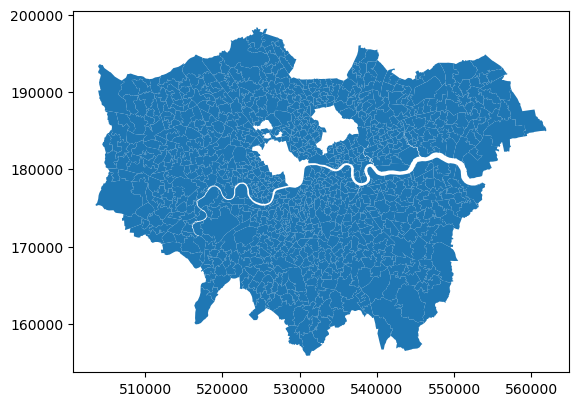

In [35]:
gdf.plot()
plt.show()


In [42]:
print(gdf['average_retail_lifetime'].isnull().sum())

0


In [44]:
# 查看 msoa_gdf 数据框的列名
print(msoa_gdf.columns)

# 查看 average_retail_lifetime_msoa 数据框的列名
print(average_retail_lifetime_msoa.columns)


Index(['msoa11', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
       'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ',
       'geometry'],
      dtype='object')
Index(['msoa11', 'average_retail_lifetime'], dtype='object')


In [45]:
# 使用 'msoa11' 作为连接键来合并数据框
gdf = msoa_gdf.merge(average_retail_lifetime_msoa, on='msoa11', how='left')

# 检查合并后的数据框
print(gdf.head())

      msoa11                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188    25.5    4385   
1  E12000007  London      6775      6724         51    31.3    2713   
2  E12000007  London     10045     10033         12    46.9    3834   
3  E12000007  London      6182      5937        245    24.8    2318   
4  E12000007  London      8562      8562          0    72.1    3183   

   AVHHOLDSZ                                           geometry  \
0        1.6  MULTIPOLYGON (((531667.624 180534.992, 53

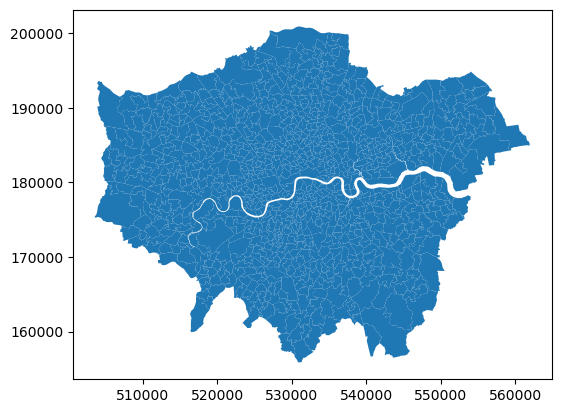

In [51]:
import matplotlib.pyplot as plt

gdf.plot()
plt.show()

In [52]:
from esda.moran import Moran_Local
from libpysal.weights import KNN

# 创建空间权重矩阵，使用 K 临近方法
w = KNN.from_dataframe(gdf, k=5)  # 选择 k=5 临近点
w.transform = 'r'

# 计算局部 Moran's I 值
local_moran = Moran_Local(gdf['average_retail_lifetime'], w)

# 将局部 Moran's I 值及其显著性结果添加到 gdf 中
gdf['local_moran_I'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# 查看结果
gdf[['local_moran_I', 'p_value']].head()

local_moran_I  p_value
0            NaN    0.001
1            NaN    0.001
2            NaN    0.001
3            NaN    0.001
4            NaN    0.001

In [53]:
print(gdf['average_retail_lifetime'].isnull().sum())

92


In [54]:
# 删除包含缺失值的行，并创建一个新的 GeoDataFrame gdf1
gdf1 = gdf.dropna(subset=['average_retail_lifetime'])

# 查看处理后的数据集信息
print(gdf1.info())
print(gdf1['average_retail_lifetime'].isnull().sum())  # 这一步验证是否仍然有缺失值

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 891 entries, 0 to 982
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   msoa11                   891 non-null    object  
 1   MSOA11NM                 891 non-null    object  
 2   LAD11CD                  891 non-null    object  
 3   LAD11NM                  891 non-null    object  
 4   RGN11CD                  891 non-null    object  
 5   RGN11NM                  891 non-null    object  
 6   USUALRES                 891 non-null    int32   
 7   HHOLDRES                 891 non-null    int32   
 8   COMESTRES                891 non-null    int32   
 9   POPDEN                   891 non-null    float64 
 10  HHOLDS                   891 non-null    int32   
 11  AVHHOLDSZ                891 non-null    float64 
 12  geometry                 891 non-null    geometry
 13  average_retail_lifetime  891 non-null    float64 
 14  local_m

In [57]:
# 计算每个区域的邻居数量
neighbors_count = np.array([len(w.neighbors[id]) for id in range(len(gdf1))])

# 找到有邻居的区域（即邻居数量大于0）
connected_regions = neighbors_count > 0

# 只保留有邻居的区域
gdf_connected = gdf1[connected_regions].copy()

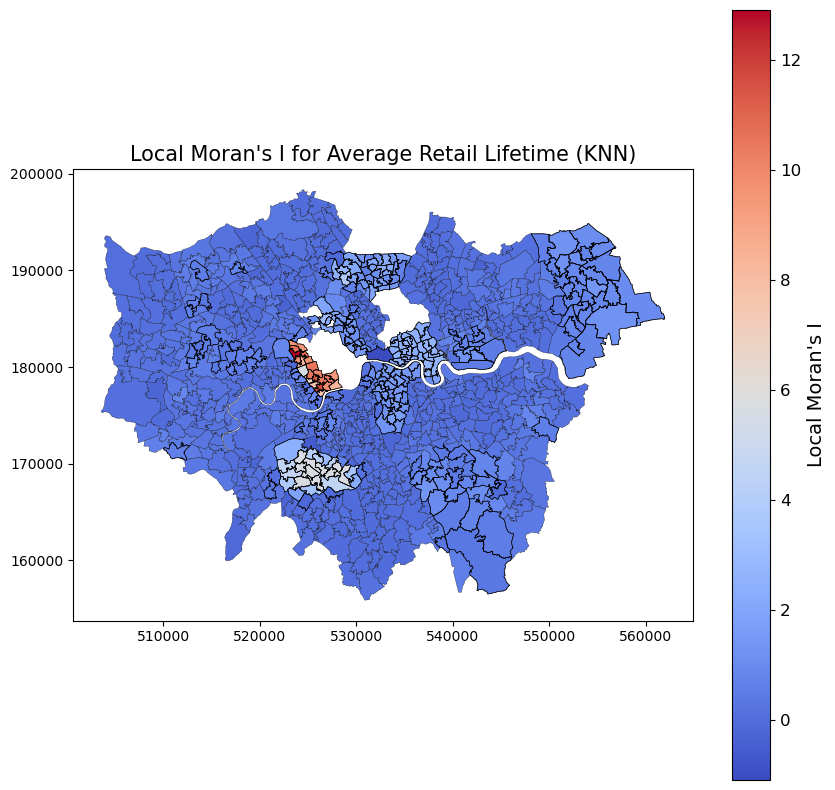

In [62]:
from libpysal.weights import KNN
import matplotlib.pyplot as plt

# 使用 KNN 生成权重矩阵
w_knn = KNN.from_dataframe(gdf1, k=5)  # k 代表邻居的数量

# 计算局部 Moran's I
local_moran_knn = Moran_Local(gdf1['average_retail_lifetime'], w_knn)

# 使用 .loc 方法将结果添加到 gdf1 中，以避免 SettingWithCopyWarning
gdf1.loc[:, 'local_moran_I'] = local_moran_knn.Is
gdf1.loc[:, 'p_value'] = local_moran_knn.p_sim

# 可视化
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf1.plot(column='local_moran_I', cmap='coolwarm', edgecolor='black', linewidth=0.2, ax=ax)
gdf1[gdf1['p_value'] < 0.05].boundary.plot(ax=ax, color=None, edgecolor='black', linewidth=0.5)

# 添加颜色条
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.tick_params(labelsize=12)  # 设置刻度标签的字体大小
cbar.set_label('Local Moran\'s I', fontsize=14)  # 设置颜色条标签

plt.title("Local Moran's I for Average Retail Lifetime (KNN)", fontsize=15)
plt.show()


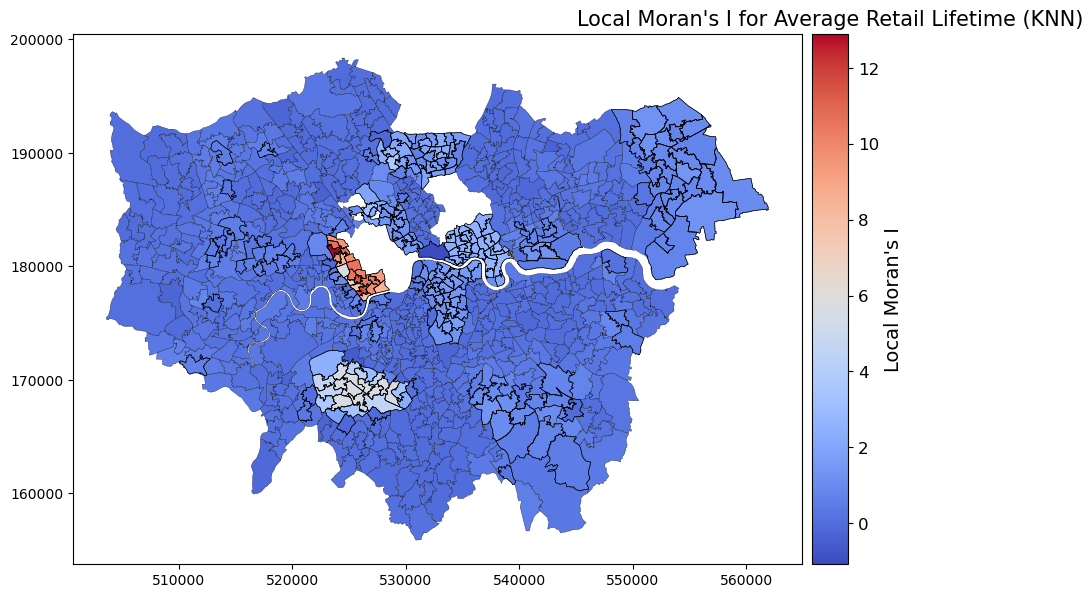

In [63]:
from libpysal.weights import KNN
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 使用 KNN 生成权重矩阵
w_knn = KNN.from_dataframe(gdf1, k=5)  # k 代表邻居的数量

# 计算局部 Moran's I
local_moran_knn = Moran_Local(gdf1['average_retail_lifetime'], w_knn)

# 使用 .loc 方法将结果添加到 gdf1 中，以避免 SettingWithCopyWarning
gdf1.loc[:, 'local_moran_I'] = local_moran_knn.Is
gdf1.loc[:, 'p_value'] = local_moran_knn.p_sim

# 可视化
fig, ax = plt.subplots(1, figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf1.plot(column='local_moran_I', cmap='coolwarm', edgecolor='black', linewidth=0.2, ax=ax)
gdf1[gdf1['p_value'] < 0.05].boundary.plot(ax=ax, color=None, edgecolor='black', linewidth=0.5)

# 添加颜色条，并调整其大小与图一致
cbar = plt.colorbar(ax.collections[0], cax=cax)
cbar.ax.tick_params(labelsize=12)  # 设置刻度标签的字体大小
cbar.set_label('Local Moran\'s I', fontsize=14)  # 设置颜色条标签

plt.title("Local Moran's I for Average Retail Lifetime (KNN)", fontsize=15)
plt.show()


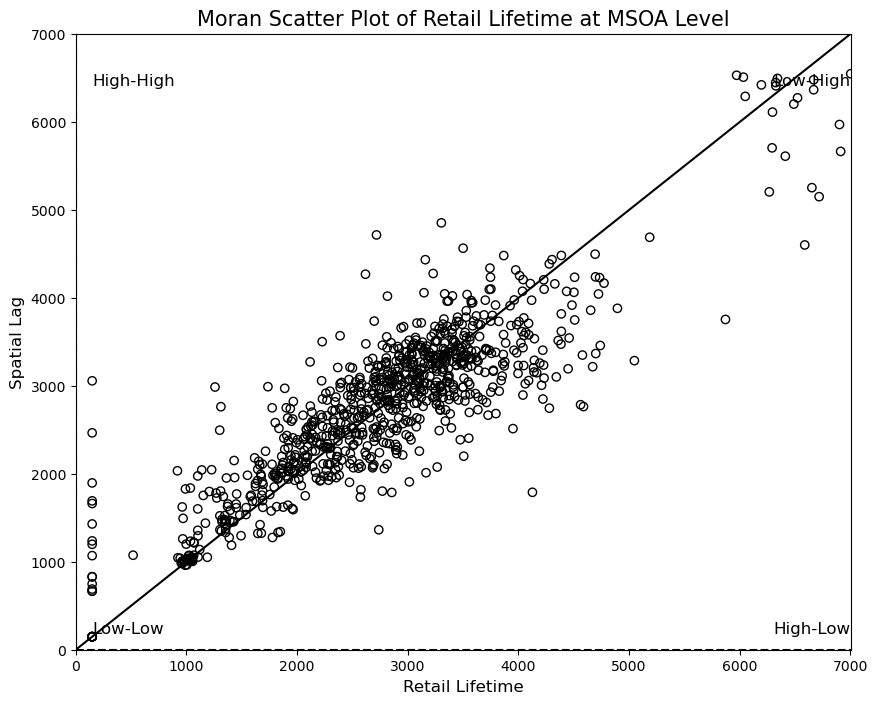

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from esda.moran import Moran_Local
from libpysal.weights import KNN, lag_spatial

# 使用 KNN 生成权重矩阵
w_knn = KNN.from_dataframe(gdf1, k=5)

# 计算局部 Moran's I
local_moran = Moran_Local(gdf1['average_retail_lifetime'], w_knn)

# 计算空间滞后
spatial_lag = lag_spatial(w_knn, gdf1['average_retail_lifetime'])

# 创建Moran散点图
fig, ax = plt.subplots(1, figsize=(10, 8))  # 调整图的大小

# 绘制散点图
ax.scatter(gdf1['average_retail_lifetime'], spatial_lag, edgecolor='k', facecolor='none')

# 添加 y=x 的斜线
max_value = max(gdf1['average_retail_lifetime'].max(), spatial_lag.max())
ax.plot([0, max_value], [0, max_value], color='black', linestyle='-')

# 添加辅助线
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# 调整注释的位置
plt.text(gdf1['average_retail_lifetime'].min(), spatial_lag.max(), "High-High", fontsize=12, ha='left', va='top')
plt.text(gdf1['average_retail_lifetime'].min(), spatial_lag.min(), "Low-Low", fontsize=12, ha='left', va='bottom')
plt.text(gdf1['average_retail_lifetime'].max(), spatial_lag.max(), "Low-High", fontsize=12, ha='right', va='top')
plt.text(gdf1['average_retail_lifetime'].max(), spatial_lag.min(), "High-Low", fontsize=12, ha='right', va='bottom')

# 设置标题和轴标签
plt.title("Moran Scatter Plot of Retail Lifetime at MSOA Level", fontsize=15)
plt.xlabel("Retail Lifetime", fontsize=12)
plt.ylabel("Spatial Lag", fontsize=12)

# 调整图形的边界，确保注释不重叠
plt.xlim(left=0, right=max_value)
plt.ylim(bottom=0, top=max_value)

# 显示图形
plt.show()

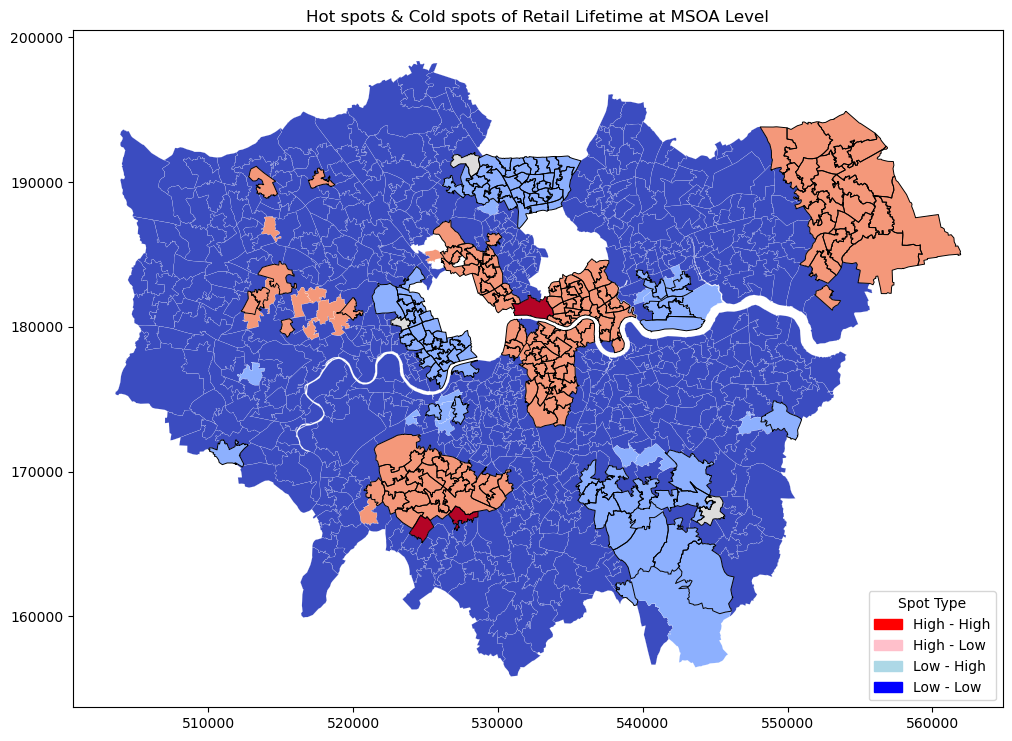

In [73]:
import matplotlib.pyplot as plt
import geopandas as gpd
from esda.moran import Moran_Local
from libpysal.weights import KNN
import numpy as np

# 使用 KNN 生成权重矩阵
w_knn = KNN.from_dataframe(gdf1, k=5)

# 计算局部 Moran's I
local_moran = Moran_Local(gdf1['average_retail_lifetime'], w_knn)

# 为热点和冷点创建类别
sig = 1 * (local_moran.p_sim < 0.05)
hotspot = 1 * (sig * local_moran.q == 1)
coldspot = 3 * (sig * local_moran.q == 3)
doughnut = 2 * (sig * local_moran.q == 2)
diamond = 4 * (sig * local_moran.q == 4)

# 合并这些类别以获得最终分类
spot = hotspot + coldspot + doughnut + diamond
spot_labels = ['None', 'Hotspot', 'Low-High', 'Coldspot', 'High-Low']

# 使用 .loc 方法将结果添加到 GeoDataFrame 中
gdf1.loc[:, 'spot_type'] = spot

# 绘图
fig, ax = plt.subplots(1, figsize=(12, 12))

# 绘制有显著性区域的边框为黑色，其他为白色
gdf1.assign(spot_type=spot).plot(column='spot_type', categorical=True, 
                                 k=5, cmap='coolwarm', linewidth=0.1, ax=ax, 
                                 edgecolor='white', legend=False)

# 只为有统计显著性的区域加上黑色边框
gdf1.boundary[gdf1['p_value'] < 0.05].plot(ax=ax, color='black', linewidth=0.7)

# 添加图例
import matplotlib.patches as mpatches
hot_patch = mpatches.Patch(color='red', label='High - High')
cold_patch = mpatches.Patch(color='blue', label='Low - Low')
lh_patch = mpatches.Patch(color='lightblue', label='Low - High')
hl_patch = mpatches.Patch(color='pink', label='High - Low')
plt.legend(handles=[hot_patch, hl_patch, lh_patch, cold_patch], title="Spot Type", loc='lower right')

# 添加标题
plt.title("Hot spots & Cold spots of Retail Lifetime at MSOA Level")

# 显示图形
plt.show()

In [74]:
print(data_merged)

       voaBillingAuthorityName      voaUARN laBillingReferenceCode  \
0               City of London     13930052         00000121800007   
1               City of London     13931052         00000121810009   
2               City of London     13932052         0000012182000B   
3               City of London     13935052         00000121840004   
4               City of London     13936052         00000121850006   
...                        ...          ...                    ...   
526931              Wandsworth  14417157000         00015420018712   
526932              Wandsworth  14445388000         00015420018811   
526933              Wandsworth  14445407000         00015420018822   
526934              Wandsworth  14459199000         00015420019064   
526935              Wandsworth  14493227000         00044485508812   

                   laRatepayerName laAccountStartDate laRecordDate  \
0              TOM HIXSON & CO LTD                NaN   2023-12-01   
1                  

In [75]:
# Assuming `data_merged` is available and `laOccupationState` is a column in it.
# Let's extract the rows where `laOccupationState` is True into a new dataframe `data_merged_true`

data_merged_true = data_merged[data_merged['laOccupationState'] == True].copy()

In [76]:
print(data_merged_true)

       voaBillingAuthorityName      voaUARN laBillingReferenceCode  \
0               City of London     13930052         00000121800007   
8               City of London     14015052         00000125780107   
9               City of London     14019052         00000125810001   
11              City of London     14147052         0000012676005B   
12              City of London     14148052         0000012681000A   
...                        ...          ...                    ...   
526931              Wandsworth  14417157000         00015420018712   
526932              Wandsworth  14445388000         00015420018811   
526933              Wandsworth  14445407000         00015420018822   
526934              Wandsworth  14459199000         00015420019064   
526935              Wandsworth  14493227000         00044485508812   

                                    laRatepayerName laAccountStartDate  \
0                               TOM HIXSON & CO LTD                NaN   
8          

In [80]:
# 使用 groupby 按 msoa11 列分组，然后计算 voaFloorArea 的平均值
average_allfloorarea_msoa = data_merged.groupby('msoa11')['voaFloorArea'].mean().reset_index()

# 重命名列名为更加明确
average_allfloorarea_msoa.columns = ['msoa11', 'average_voaFloorArea']

# 打印结果
print(average_allfloorarea_msoa)

        msoa11  average_voaFloorArea
0    E02000001            118.143264
1    E02000002            272.906983
2    E02000003            184.822687
3    E02000004            143.120000
4    E02000005            167.127273
..         ...                   ...
886  E02006927            266.610729
887  E02006928            199.644498
888  E02006929            617.260194
889  E02006930            169.544958
890  E02006931            108.469261

[891 rows x 2 columns]


In [81]:
# 检查 average_voaFloorArea 列中为 0 或缺失的行
missing_or_zero_rows = average_allfloorarea_msoa[(average_allfloorarea_msoa['average_voaFloorArea'].isna()) | (average_allfloorarea_msoa['average_voaFloorArea'] == 0)]

# 打印这些行
print(missing_or_zero_rows)

        msoa11  average_voaFloorArea
180  E02000190                   NaN


In [84]:
# 删除 average_voaFloorArea 列为 NaN 或 0 的行
average_allfloorarea_msoa = average_allfloorarea_msoa[(average_allfloorarea_msoa['average_voaFloorArea'].notna()) & 
                                                      (average_allfloorarea_msoa['average_voaFloorArea'] != 0)]

# 打印结果以确认删除成功
print(average_allfloorarea_msoa)

        msoa11  average_voaFloorArea
0    E02000001            118.143264
1    E02000002            272.906983
2    E02000003            184.822687
3    E02000004            143.120000
4    E02000005            167.127273
..         ...                   ...
886  E02006927            266.610729
887  E02006928            199.644498
888  E02006929            617.260194
889  E02006930            169.544958
890  E02006931            108.469261

[890 rows x 2 columns]


In [83]:
# 过滤掉 laRatesReliefsAmount 和 laRatesPaid 列中有缺失值或为 0 的行
filtered_data = data_merged_true[(data_merged_true['laRatesReliefsAmount'].notna()) & 
                                 (data_merged_true['laRatesPaid'].notna()) & 
                                 (data_merged_true['laRatesReliefsAmount'] > 0) & 
                                 (data_merged_true['laRatesPaid'] > 0)].copy()

# 计算减免税比率
filtered_data.loc[:, 'relief_rate'] = filtered_data['laRatesReliefsAmount'] / (filtered_data['laRatesReliefsAmount'] + filtered_data['laRatesPaid'])

# 以 msoa11 为分类，计算每个 msoa11 的减免税比率的平均值
relief_rate_per_msoa11 = filtered_data.groupby('msoa11')['relief_rate'].mean().reset_index()

# 打印结果
print(relief_rate_per_msoa11)

        msoa11  relief_rate
0    E02000001     0.632939
1    E02000002     0.822642
2    E02000003     0.771957
3    E02000004     0.824351
4    E02000005     0.814601
..         ...          ...
860  E02006927     0.577342
861  E02006928     0.607942
862  E02006929     0.592604
863  E02006930     0.595337
864  E02006931     0.625558

[865 rows x 2 columns]


In [85]:
# 删除 voaRateableValue 列中为 NaN 或 0 的行
filtered_data = data_merged_true[(data_merged_true['voaRateableValue'].notna()) & 
                                 (data_merged_true['voaRateableValue'] != 0)]

# 按 msoa11 计算 voaRateableValue 的平均值
average_rateable_value_msoa = filtered_data.groupby('msoa11')['voaRateableValue'].mean().reset_index()

# 将列名修改为更具有描述性的名称
average_rateable_value_msoa.columns = ['msoa11', 'average_rateable_value']

# 打印结果以确认计算成功
print(average_rateable_value_msoa)

        msoa11  average_rateable_value
0    E02000001            59999.894991
1    E02000002            15367.410714
2    E02000003            21850.395833
3    E02000004            14140.000000
4    E02000005            28532.241814
..         ...                     ...
885  E02006927            31720.714286
886  E02006928            50795.305430
887  E02006929           130464.596115
888  E02006930            28852.694175
889  E02006931            26184.315068

[890 rows x 2 columns]


In [88]:
import pandas as pd

# 读取 Excel 文件
file_path = '/home/jovyan/CASA_Study/DS/LSOA Mean price paid for residential properties by LSOA.xls'  # 替换为你的 Excel 文件路径
df = pd.read_excel(file_path)

# 提取 A 列和 DI 列，并形成新的数据集
data_residential_properties_msoa = df[['LSOA code', 'Year ending Dec 2022']]

# 打印结果以确认
print(data_residential_properties_msoa)

       LSOA code Year ending Dec 2022
0      E01011949         97116.318182
1      E01011950         55060.483871
2      E01011951              72262.8
3      E01011952         74642.571429
4      E01011953         94371.428571
...          ...                  ...
34748  W01001320               199525
34749  W01001321         122652.17391
34750  W01001322         179411.76471
34751  W01001324           206715.625
34752  W01001898         213340.90909

[34753 rows x 2 columns]


In [89]:
import pandas as pd

# 假设 onspd_data1 和 data_residential_properties_msoa 已经读取为 DataFrame
# onspd_data1 和 data_residential_properties_msoa 是你已有的数据集

# 将 onspd_data1 的 lsoa11 和 msoa11 提取出来
lsoa_msoa_mapping = onspd_data1[['lsoa11', 'msoa11']]

# 将 lsoa_msoa_mapping 与 data_residential_properties_msoa 进行合并
data_residential_properties_msoa_mapped = data_residential_properties_msoa.merge(
    lsoa_msoa_mapping,
    left_on='LSOA code',
    right_on='lsoa11',
    how='left'
)

# 删除不需要的 'lsoa11' 列
data_residential_properties_msoa_mapped.drop(columns=['lsoa11'], inplace=True)

# 打印结果以确认
print(data_residential_properties_msoa_mapped)

         LSOA code Year ending Dec 2022     msoa11
0        E01011949         97116.318182  E02002491
1        E01011949         97116.318182  E02002491
2        E01011949         97116.318182  E02002491
3        E01011949         97116.318182  E02002491
4        E01011949         97116.318182  E02002491
...            ...                  ...        ...
2390829  W01001898         213340.90909  W02000415
2390830  W01001898         213340.90909  W02000415
2390831  W01001898         213340.90909  W02000415
2390832  W01001898         213340.90909  W02000415
2390833  W01001898         213340.90909  W02000415

[2390834 rows x 3 columns]


In [93]:
import pandas as pd

# 将 'mosa_residential_meanprice' 列转换为数值类型，无法转换的将变为 NaN
data_residential_properties_msoa_mapped['mosa_residential_meanprice'] = pd.to_numeric(data_residential_properties_msoa_mapped['mosa_residential_meanprice'], errors='coerce')

# 删除 NaN 值
data_residential_properties_msoa_mapped = data_residential_properties_msoa_mapped.dropna(subset=['mosa_residential_meanprice'])

# 删除等于0的值
data_residential_properties_msoa_mapped = data_residential_properties_msoa_mapped[data_residential_properties_msoa_mapped['mosa_residential_meanprice'] != 0]

# 计算相同 msoa11 的平均 mosa_residential_meanprice
msoa_residential_properties = data_residential_properties_msoa_mapped.groupby('msoa11')['mosa_residential_meanprice'].mean().reset_index()

# 打印结果查看
print(msoa_residential_properties)

         msoa11  mosa_residential_meanprice
0     E02000001               934499.261618
1     E02000002               371132.600970
2     E02000003               401182.882350
3     E02000004               424893.555201
4     E02000005               379087.974685
...         ...                         ...
7192  W02000419               176784.017423
7193  W02000420               337121.588211
7194  W02000421               273982.472589
7195  W02000422               192886.566678
7196  W02000423               196459.307831

[7197 rows x 2 columns]


In [96]:
import pandas as pd

# 尝试使用 'ISO-8859-1' 编码读取伦敦 MSOA 区域列表
london_msoa = pd.read_csv('/home/jovyan/CASA_Study/DS/msoa-data.csv', encoding='ISO-8859-1')

# 提取伦敦 MSOA 列表
london_msoa_list = london_msoa['Middle Super Output Area'].unique()

# 筛选 msoa_residential_properties 数据中属于伦敦区域的行
msoa_ldresidential_properties = msoa_residential_properties[msoa_residential_properties['msoa11'].isin(london_msoa_list)]

# 保存为新的数据集
msoa_ldresidential_properties.to_csv('msoa_ldresidential_properties.csv', index=False)

# 打印前几行结果以确认
print(msoa_ldresidential_properties)

         msoa11  mosa_residential_meanprice
0     E02000001               934499.261618
1     E02000002               371132.600970
2     E02000003               401182.882350
3     E02000004               424893.555201
4     E02000005               379087.974685
...         ...                         ...
6779  E02006927               587412.566493
6780  E02006928               473334.339960
6781  E02006929               575744.668444
6782  E02006930               638908.051607
6783  E02006931               799720.936536

[979 rows x 2 columns]


In [97]:
import pandas as pd

# 读取 CSV 文件
file_path = '/home/jovyan/CASA_Study/DS/LSOA Number of criminals.csv'
lsoa_crime_data = pd.read_csv(file_path, encoding='ISO-8859-1')  # 如果编码错误，尝试用 'ISO-8859-1'

# 选择 202301 到 202312 这12个月的列
columns_to_sum = [str(year_month) for year_month in range(202301, 202313)]

# 计算每个 LSOA 区域的犯罪数量总和
lsoa_crime_data['total_crimes_2023'] = lsoa_crime_data[columns_to_sum].sum(axis=1)

# 查看结果
print(lsoa_crime_data[['LSOA Code', 'total_crimes_2023']])

# 如果需要保存为新的 CSV 文件
#lsoa_crime_data.to_csv('/home/jovyan/CASA_Study/DS/LSOA_crime_totals_2023.csv', index=False)


       LSOA Code  total_crimes_2023
0      E01000006                  5
1      E01000006                  0
2      E01000006                  3
3      E01000006                  3
4      E01000006                  2
...          ...                ...
99504  E01035722                  0
99505  E01035722                  7
99506  E01035722                  2
99507  E01035722                 15
99508  E01035722                 28

[99509 rows x 2 columns]


In [103]:
# 按照 'LSOA Code' 进行分组，并计算 'total_crimes_2023' 列的总和
lsoa_crime_totals = lsoa_crime_data.groupby('LSOA Code')['total_crimes_2023'].sum().reset_index()

# 查看结果
print(lsoa_crime_totals)

      LSOA Code  total_crimes_2023
0     E01000006                 87
1     E01000007                645
2     E01000008                234
3     E01000009                375
4     E01000011                121
...         ...                ...
4983  E01035718               1637
4984  E01035719                 64
4985  E01035720                 82
4986  E01035721                689
4987  E01035722                135

[4988 rows x 2 columns]


In [105]:
# 查看 onspd_data1 数据集的列名
print(onspd_data1.columns)

Index(['pcds', 'LSOA Code', 'msoa11', 'lat', 'long'], dtype='object')


In [107]:
# 使用 'LSOA Code' 进行合并，而不是 'lsoa11'
merged_data1 = lsoa_crime_totals.merge(onspd_data1, left_on='LSOA Code', right_on='LSOA Code', how='left')

# 按 'msoa11' 分组并计算总犯罪数
msoa_crime_totals = merged_data1.groupby('msoa11')['total_crimes_2023'].sum().reset_index()

# 查看结果
print(msoa_crime_totals)

        msoa11  total_crimes_2023
0    E02000002              24909
1    E02000003              49012
2    E02000004              13576
3    E02000005              15932
4    E02000007              38850
..         ...                ...
977  E02006927              15183
978  E02006928              17864
979  E02006929              38847
980  E02006930             101508
981  E02006931              92923

[982 rows x 2 columns]


In [108]:
# 检查是否有缺失值
missing_values = msoa_crime_totals['total_crimes_2023'].isnull().sum()
print(f"缺失值的数量: {missing_values}")

# 检查是否有值为0的行
zero_values = (msoa_crime_totals['total_crimes_2023'] == 0).sum()
print(f"值为0的数量: {zero_values}")

# 输出缺失值或为0的行
rows_with_issues = msoa_crime_totals[(msoa_crime_totals['total_crimes_2023'].isnull()) | (msoa_crime_totals['total_crimes_2023'] == 0)]
print(rows_with_issues)

缺失值的数量: 0
值为0的数量: 0
Empty DataFrame
Columns: [msoa11, total_crimes_2023]
Index: []


In [109]:
import pandas as pd

# 读取 Excel 文件
lsoa_density = pd.read_excel('/home/jovyan/CASA_Study/DS/LSOA popdensity.xlsx')

# 合并数据集，基于 LSOA Code 和 LSOA 2021 Code
merged_data2 = lsoa_density.merge(onspd_data1, left_on='LSOA 2021 Code', right_on='LSOA Code', how='left')

# 按 msoa11 分组并计算人口密度的平均值
msoa_population_density = merged_data2.groupby('msoa11')['People per Sq Km'].mean().reset_index()

# 查看结果
print(msoa_population_density)

         msoa11  People per Sq Km
0     E02000001       2761.370241
1     E02000002       6931.488832
2     E02000003       6927.247255
3     E02000004       5347.290564
4     E02000005       9567.530757
...         ...               ...
7194  W02000419       4294.031634
7195  W02000420        493.321892
7196  W02000421         36.716807
7197  W02000422       1769.626185
7198  W02000423       5324.022784

[7199 rows x 2 columns]


In [111]:
import pandas as pd

# 读取伦敦的 MSOA 数据
london_msoa = pd.read_csv('/home/jovyan/CASA_Study/DS/msoa-data.csv', encoding='ISO-8859-1')

# 提取伦敦 MSOA 列表
london_msoa_list = london_msoa['Middle Super Output Area'].unique()

# 筛选msoa_population_density中伦敦的MSOA
msoa_population_density_london = msoa_population_density[msoa_population_density['msoa11'].isin(london_msoa_list)]

# 保存结果
#msoa_population_density_london.to_csv('/path/to/msoa_population_density_london.csv', index=False)

# 查看结果
print(msoa_population_density_london)

         msoa11  People per Sq Km
0     E02000001       2761.370241
1     E02000002       6931.488832
2     E02000003       6927.247255
3     E02000004       5347.290564
4     E02000005       9567.530757
...         ...               ...
6781  E02006927       4192.894876
6782  E02006928      19307.408400
6783  E02006929       5997.651201
6784  E02006930       8090.801209
6785  E02006931       8451.608174

[983 rows x 2 columns]


In [142]:
import pandas as pd

# 读取所有数据集 (假设这些数据集已经加载到变量中)
# 如果数据集是以 CSV 文件形式存在的，你可以用以下方法读取它们：
# msoa_population_density_london = pd.read_csv('path/to/msoa_population_density_london.csv')

# 合并数据集，以 'msoa11' 为公共键
data_ols = msoa_population_density_london
data_ols = data_ols.merge(msoa_crime_totals, on='msoa11', how='inner')
data_ols = data_ols.merge(msoa_ldresidential_properties, on='msoa11', how='inner')
data_ols = data_ols.merge(average_rateable_value_msoa, on='msoa11', how='inner')
data_ols = data_ols.merge(relief_rate_per_msoa11, on='msoa11', how='inner')
data_ols = data_ols.merge(average_allfloorarea_msoa, on='msoa11', how='inner')
data_ols = data_ols.merge(vacancy_rate_by_msoa, on='msoa11', how='inner')
data_ols = data_ols.merge(average_retail_lifetime_msoa, on='msoa11', how='inner')

# 查看生成的 data_ols 的前几行
print(data_ols)

        msoa11  People per Sq Km  total_crimes_2023  \
0    E02000002       6931.488832              24909   
1    E02000003       6927.247255              49012   
2    E02000004       5347.290564              13576   
3    E02000005       9567.530757              15932   
4    E02000007       7351.917618              38850   
..         ...               ...                ...   
854  E02006927       4192.894876              15183   
855  E02006928      19307.408400              17864   
856  E02006929       5997.651201              38847   
857  E02006930       8090.801209             101508   
858  E02006931       8451.608174              92923   

     mosa_residential_meanprice  average_rateable_value  relief_rate  \
0                 371132.600970            15367.410714     0.822642   
1                 401182.882350            21850.395833     0.771957   
2                 424893.555201            14140.000000     0.824351   
3                 379087.974685            28532.24

In [143]:
# 检查整个数据集中是否有 NaN 值
nan_summary = data_ols.isnull().sum()

# 打印结果
print(nan_summary)

# 检查是否有任何一列存在 NaN 值
if nan_summary.sum() == 0:
    print("No NaN values found in the dataset.")
else:
    print(f"NaN values found in the dataset:\n{nan_summary[nan_summary > 0]}")

msoa11                        0
People per Sq Km              0
total_crimes_2023             0
mosa_residential_meanprice    0
average_rateable_value        0
relief_rate                   0
average_voaFloorArea          0
vacancy_rate                  0
average_retail_lifetime       0
dtype: int64
No NaN values found in the dataset.


In [144]:
print(X.dtypes)
print(y.dtypes)

const                         float64
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
dtype: object
float64


In [145]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 假设前面的代码已经运行并且 model 已经拟合

# 获取 R^2 值
r_squared = model.rsquared

# 获取样本数量 n 和自变量数量 p
n = X.shape[0]  # 样本数量
p = X.shape[1] - 1  # 自变量数量，减去1是因为添加了常数项

# 计算调整后的 R^2
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# 打印调整后的 R^2
print(f"Adjusted R^2: {adjusted_r_squared:.4f}")

Adjusted R^2: 0.8929


In [152]:
for col in X.columns:
    print(f"Column {col} has unique values: {X[col].unique()[:10]}")

Column const has unique values: [1.]
Column People per Sq Km has unique values: [ 6931.48883171  6927.24725451  5347.29056389  9567.53075664
  7351.91761771  8678.86772778 11128.05871332  8762.67515613
  5069.50539949  8922.16720549]
Column total_crimes_2023 has unique values: [24909 49012 13576 15932 38850 88521 15178 14394 23139 29960]
Column mosa_residential_meanprice has unique values: [371132.60096957 401182.88235046 424893.55520148 379087.97468468
 385156.1495521  356691.27758858 382583.43974592 357057.77581667
 380827.94117676 530483.7000691 ]
Column average_rateable_value has unique values: [15367.41071429 21850.39583333 14140.         28532.2418136
 20806.07476636 11473.51485149 12205.05263158 11495.83333333
 14046.96745562 13652.13270142]
Column relief_rate has unique values: [0.82264214 0.77195745 0.82435092 0.81460146 0.79283603 0.82125007
 0.80486538 0.77417306 0.8152223  0.79608374]
Column average_voaFloorArea has unique values: [272.90698276 184.82268728 143.12       167

In [153]:
print(X.isna().sum())
print(y.isna().sum())

const                         0
People per Sq Km              0
total_crimes_2023             0
mosa_residential_meanprice    0
average_rateable_value        0
relief_rate                   0
average_voaFloorArea          0
vacancy_rate                  0
dtype: int64
0


In [154]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (859, 8)
Shape of y: (859,)


In [156]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 确保所有 X 和 y 数据都是数值类型
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# 检查是否有任何列仍然是 object 类型
print(X.dtypes)
print(y.dtype)

# 检查是否有任何 NaN 值在转换后出现
print(X.isna().sum())
print(y.isna().sum())

# 移除包含 NaN 的行
X = X.dropna()
y = y[X.index]  # 保持 X 和 y 同步

# 再次进行 OLS 回归
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

const                         float64
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
dtype: object
float64
const                         0
People per Sq Km              0
total_crimes_2023             0
mosa_residential_meanprice    0
average_rateable_value        0
relief_rate                   0
average_voaFloorArea          0
vacancy_rate                  0
dtype: int64
0
                               OLS Regression Results                              
Dep. Variable:     average_retail_lifetime   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     20.38
Date:                     Wed, 21 Aug 2024   Prob (F-statistic):   

In [157]:
print(data_ols)

        msoa11  People per Sq Km  total_crimes_2023  \
0    E02000002       6931.488832              24909   
1    E02000003       6927.247255              49012   
2    E02000004       5347.290564              13576   
3    E02000005       9567.530757              15932   
4    E02000007       7351.917618              38850   
..         ...               ...                ...   
854  E02006927       4192.894876              15183   
855  E02006928      19307.408400              17864   
856  E02006929       5997.651201              38847   
857  E02006930       8090.801209             101508   
858  E02006931       8451.608174              92923   

     mosa_residential_meanprice  average_rateable_value  relief_rate  \
0                 371132.600970            15367.410714     0.822642   
1                 401182.882350            21850.395833     0.771957   
2                 424893.555201            14140.000000     0.824351   
3                 379087.974685            28532.24

In [158]:
import geopandas as gpd

# 加载MSOA shapefile
shapefile_path = '/home/jovyan/CASA_Study/DS/MSOA_2011_London_gen_MHW.shp'
gdf_msoa = gpd.read_file(shapefile_path)

# 检查数据，确认加载成功
print(gdf_msoa.head())

    MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

     RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0  E12000007  London      7375      7187        188    25.5    4385   
1  E12000007  London      6775      6724         51    31.3    2713   
2  E12000007  London     10045     10033         12    46.9    3834   
3  E12000007  London      6182      5937        245    24.8    2318   
4  E12000007  London      8562      8562          0    72.1    3183   

   AVHHOLDSZ                                           geometry  
0        1.6  MULTIPOLYGON (((531667.624 180534.992, 531

In [159]:
import statsmodels.api as sm

# 假设 data_ols 已经加载
X = data_ols[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice', 
              'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']]
y = data_ols['average_retail_lifetime']

# 添加常数项
X = sm.add_constant(X)

# 进行OLS回归
model = sm.OLS(y, X).fit()

# 将残差添加到data_ols数据集中
data_ols['residuals'] = model.resid

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [160]:
# 检查 y 和 X 中的类型
print("y 数据类型：", y.dtype)
print("X 数据类型：")
print(X.dtypes)

# 尝试将 y 和 X 转换为浮点数
y = pd.to_numeric(y, errors='coerce')
X = X.apply(pd.to_numeric, errors='coerce')

# 检查是否存在 NaN 值
print("y 中的 NaN 值数量：", y.isna().sum())
print("X 中的 NaN 值数量：", X.isna().sum())

# 如果发现 NaN 值，可以选择删除这些行
X = X.dropna()
y = y.dropna()

# 再次尝试回归分析
try:
    model = sm.OLS(y, X).fit()
    print(model.summary())
except Exception as e:
    print("OLS 回归出错：", e)


y 数据类型： float64
X 数据类型：
const                         float64
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                   object
dtype: object
y 中的 NaN 值数量： 0
X 中的 NaN 值数量： const                         0
People per Sq Km              0
total_crimes_2023             0
mosa_residential_meanprice    0
average_rateable_value        0
relief_rate                   0
average_voaFloorArea          0
vacancy_rate                  0
dtype: int64
                               OLS Regression Results                              
Dep. Variable:     average_retail_lifetime   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     20.38
Date:                  

In [162]:
# 确认 vacancy_rate 列已经是数值类型
print(X['vacancy_rate'].dtype)


float64


In [164]:
# 强制转换为 float 类型
X = X.astype(float)
y = y.astype(float)

# 检查 X 和 y 的数据类型
print(X.dtypes)
print(y.dtypes)


People per Sq Km              float64
total_crimes_2023             float64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
dtype: object
float64


In [165]:
# 检查 X 中的异常值
for column in X.columns:
    print(f"Checking column: {column}")
    print(X[column].unique())  # 检查每一列的唯一值

# 检查 y 中的异常值
print("Checking y")
print(y.unique())


Checking column: People per Sq Km
[6931.48883171]
Checking column: total_crimes_2023
[24909.]
Checking column: mosa_residential_meanprice
[371132.60096957]
Checking column: average_rateable_value
[15367.41071429]
Checking column: relief_rate
[0.82264214]
Checking column: average_voaFloorArea
[272.90698276]
Checking column: vacancy_rate
[88.88888889]
Checking y
[2579.56349206]


In [166]:
import numpy as np

X = np.asarray(X)
y = np.asarray(y)

# 再次进行 OLS 回归
model = sm.OLS(y, X).fit()
print(model.summary())

ValueError: resids must contain at least 2 elements

In [167]:
# 去掉列名中的空格或其他特殊字符
X.columns = X.columns.str.strip()


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [168]:
print(data_ols.shape)

(859, 9)


In [169]:
X = data_ols[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice', 
              'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']]
y = data_ols['average_retail_lifetime']

# 添加常数项（截距）
X = sm.add_constant(X)

# 进行 OLS 回归
model = sm.OLS(y, X).fit()
print(model.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [170]:
if data_ols.shape[0] > 1:
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print("数据集中只有一行，无法进行回归分析。")


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [171]:
# 重新加载X和y变量
X = data_ols[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice', 
              'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']]

y = data_ols['average_retail_lifetime']

# 尝试清理数据
X = X.apply(lambda x: pd.to_numeric(x, errors='coerce'))  # 强制转换为数值类型
y = pd.to_numeric(y, errors='coerce')

# 检查是否有仍然存在的 object 类型列
print("X 数据类型：\n", X.dtypes)
print("y 数据类型：", y.dtype)

# 添加常数项（截距）
X = sm.add_constant(X)

# 进行 OLS 回归
model = sm.OLS(y, X).fit()
print(model.summary())


X 数据类型：
 People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
dtype: object
y 数据类型： float64
                               OLS Regression Results                              
Dep. Variable:     average_retail_lifetime   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     20.38
Date:                     Wed, 21 Aug 2024   Prob (F-statistic):           2.12e-25
Time:                             22:02:11   Log-Likelihood:                -7101.3
No. Observations:                      859   AIC:                         1.422e+04
Df Residuals:                          851   BIC:                         1.426e+04
Df Model:              

In [172]:
# 计算残差
data_ols['residuals'] = model.resid

In [173]:
# 合并 GeoDataFrame 和残差数据
gdf_msoa = gdf_msoa.merge(data_ols[['msoa11', 'residuals']], left_on='MSOA11CD', right_on='msoa11', how='left')

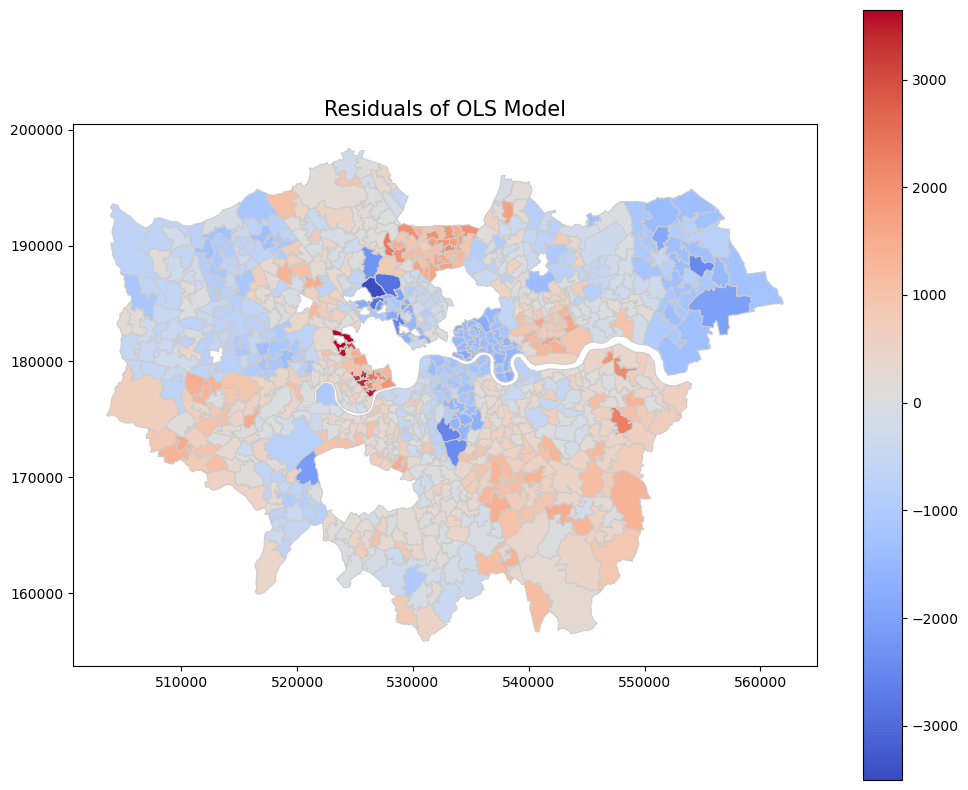

In [174]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 设置颜色分级（与您展示的图像类似）
vmin, vmax = gdf_msoa['residuals'].min(), gdf_msoa['residuals'].max()

# 绘制图形
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_msoa.plot(column='residuals', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# 添加标题和其他图形元素
plt.title('Residuals of OLS Model', fontsize=15)
plt.show()


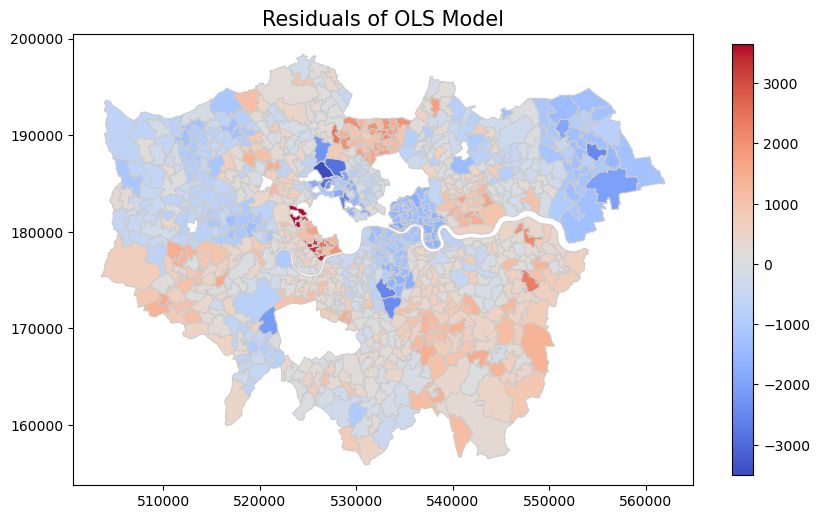

In [176]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 生成图形
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_msoa.plot(column='residuals', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=gdf_msoa['residuals'].min(), vmax=gdf_msoa['residuals'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)  # 这里的 shrink 参数控制颜色条的高度

# 添加标题
plt.title('Residuals of OLS Model', fontsize=15)

# 显示图形
plt.show()


In [178]:
import pandas as pd
import numpy as np
import geopandas as gpd
import statsmodels.api as sm

# 提取坐标
g_coords = np.column_stack([gdf_msoa.geometry.centroid.x, gdf_msoa.geometry.centroid.y])

# 提取自变量和因变量
X = data_ols[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice',
              'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']].values  # 转换为NumPy数组
y = data_ols['average_retail_lifetime'].values  # 转换为NumPy数组

# 添加常数项（截距项）
X = sm.add_constant(X)

# 输出检查
print("自变量 X 的形状：", X.shape)
print("因变量 y 的形状：", y.shape)

自变量 X 的形状： (859, 8)
因变量 y 的形状： (859,)


In [180]:
# 将两个数据集基于 MSOA 进行内连接
gdf_msoa_filtered = gdf_msoa[gdf_msoa.index.isin(data_ols.index)]
data_ols_filtered = data_ols[data_ols.index.isin(gdf_msoa.index)]

# 检查过滤后的形状
print("过滤后的 gdf_msoa 形状：", gdf_msoa_filtered.shape)
print("过滤后的 data_ols 形状：", data_ols_filtered.shape)

过滤后的 gdf_msoa 形状： (859, 15)
过滤后的 data_ols 形状： (859, 10)


In [181]:
# 从过滤后的数据集中构建 X 和 y
y_filtered = data_ols_filtered['average_retail_lifetime'].values
X_filtered = data_ols_filtered[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice',
                                'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']].values

# 检查对齐后的形状
print("对齐后的 X 形状：", X_filtered.shape)
print("对齐后的 y 形状：", y_filtered.shape)

对齐后的 X 形状： (859, 7)
对齐后的 y 形状： (859,)


In [185]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
import numpy as np

In [187]:
import numpy as np

# 确保 X_filtered 和 y_filtered 都是数值类型
X_filtered = X_filtered.astype(float)
y_filtered = y_filtered.astype(float)

# 检查是否有任何 NaN 值
print("X_filtered 中的 NaN 值数量：", np.isnan(X_filtered).sum())
print("y_filtered 中的 NaN 值数量：", np.isnan(y_filtered).sum())


X_filtered 中的 NaN 值数量： 0
y_filtered 中的 NaN 值数量： 0


In [190]:
print("g_coords_filtered shape:", g_coords_filtered.shape)
print("X_filtered shape:", X_filtered.shape)
print("y_filtered shape:", y_filtered.shape)

g_coords_filtered shape: (859, 2)
X_filtered shape: (859, 8)
y_filtered shape: (859,)


In [191]:
print("g_coords_filtered dtype:", g_coords_filtered.dtype)
print("X_filtered dtype:", X_filtered.dtype)
print("y_filtered dtype:", y_filtered.dtype)

g_coords_filtered dtype: float64
X_filtered dtype: float64
y_filtered dtype: float64


In [192]:
print("Sample of g_coords_filtered:", g_coords_filtered[:5])
print("Sample of X_filtered:", X_filtered[:5])
print("Sample of y_filtered:", y_filtered[:5])


Sample of g_coords_filtered: [[532482.70397679 181269.31001761]
 [548312.91458741 189881.37858749]
 [548454.92492797 188400.14988464]
 [551008.97174505 186310.93443301]
 [548667.08932557 186903.34361035]]
Sample of X_filtered: [[1.00000000e+00 6.93148883e+03 2.49090000e+04 3.71132601e+05
  1.53674107e+04 8.22642138e-01 2.72906983e+02 8.88888889e+01]
 [1.00000000e+00 6.92724725e+03 4.90120000e+04 4.01182882e+05
  2.18503958e+04 7.71957447e-01 1.84822687e+02 9.05992949e+01]
 [1.00000000e+00 5.34729056e+03 1.35760000e+04 4.24893555e+05
  1.41400000e+04 8.24350921e-01 1.43120000e+02 1.00000000e+02]
 [1.00000000e+00 9.56753076e+03 1.59320000e+04 3.79087975e+05
  2.85322418e+04 8.14601460e-01 1.67127273e+02 9.49886105e+01]
 [1.00000000e+00 7.35191762e+03 3.88500000e+04 3.85156150e+05
  2.08060748e+04 7.92836030e-01 3.04981687e+02 9.68379447e+01]]
Sample of y_filtered: [2579.56349206 2478.42420682 2380.2125     2320.71298405 2260.70355731]


In [199]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [201]:
print("g_coords_filtered shape:", g_coords_filtered.shape)
print("X_filtered shape:", X_filtered.shape)
print("y_filtered shape:", y_filtered.shape)

print("g_coords_filtered dtype:", g_coords_filtered.dtype)
print("X_filtered dtype:", X_filtered.dtype)
print("y_filtered dtype:", y_filtered.dtype)

print("Sample of g_coords_filtered:", g_coords_filtered[:5])
print("Sample of X_filtered:", X_filtered[:5])
print("Sample of y_filtered:", y_filtered[:5])


g_coords_filtered shape: (859, 2)
X_filtered shape: (859, 8)
y_filtered shape: (859,)
g_coords_filtered dtype: float64
X_filtered dtype: float64
y_filtered dtype: float64
Sample of g_coords_filtered: [[532482.70397679 181269.31001761]
 [548312.91458741 189881.37858749]
 [548454.92492797 188400.14988464]
 [551008.97174505 186310.93443301]
 [548667.08932557 186903.34361035]]
Sample of X_filtered: [[1.00000000e+00 6.93148883e+03 2.49090000e+04 3.71132601e+05
  1.53674107e+04 8.22642138e-01 2.72906983e+02 8.88888889e+01]
 [1.00000000e+00 6.92724725e+03 4.90120000e+04 4.01182882e+05
  2.18503958e+04 7.71957447e-01 1.84822687e+02 9.05992949e+01]
 [1.00000000e+00 5.34729056e+03 1.35760000e+04 4.24893555e+05
  1.41400000e+04 8.24350921e-01 1.43120000e+02 1.00000000e+02]
 [1.00000000e+00 9.56753076e+03 1.59320000e+04 3.79087975e+05
  2.85322418e+04 8.14601460e-01 1.67127273e+02 9.49886105e+01]
 [1.00000000e+00 7.35191762e+03 3.88500000e+04 3.85156150e+05
  2.08060748e+04 7.92836030e-01 3.049816

In [204]:
for bw in range(50, 1001, 50):
    try:
        gwr_model = GWR(g_coords_filtered, y_filtered, X_filtered, bw, fixed=False, kernel='bisquare')
        gwr_results = gwr_model.fit()
        print(f"GWR model successfully fit with bandwidth: {bw}")
        break
    except Exception as e:
        print(f"Failed with bandwidth {bw}: {str(e)}")

Failed with bandwidth 50: invalid index to scalar variable.
Failed with bandwidth 100: invalid index to scalar variable.
Failed with bandwidth 150: invalid index to scalar variable.
Failed with bandwidth 200: invalid index to scalar variable.
Failed with bandwidth 250: invalid index to scalar variable.
Failed with bandwidth 300: invalid index to scalar variable.
Failed with bandwidth 350: invalid index to scalar variable.
Failed with bandwidth 400: invalid index to scalar variable.
Failed with bandwidth 450: invalid index to scalar variable.
Failed with bandwidth 500: invalid index to scalar variable.
Failed with bandwidth 550: invalid index to scalar variable.
Failed with bandwidth 600: invalid index to scalar variable.
Failed with bandwidth 650: invalid index to scalar variable.
Failed with bandwidth 700: invalid index to scalar variable.
Failed with bandwidth 750: invalid index to scalar variable.
Failed with bandwidth 800: invalid index to scalar variable.
Failed with bandwidth 850

In [205]:
from mgwr.gwr import GWR, Sel_BW

# 选择不同的核函数
kernels = ['gaussian', 'exponential', 'bisquare', 'tricube']

for kernel in kernels:
    try:
        selector = Sel_BW(g_coords_filtered, y_filtered, X_filtered, fixed=False, kernel=kernel)
        bw = selector.search()
        gwr_model = GWR(g_coords_filtered, y_filtered, X_filtered, bw, kernel=kernel, fixed=False)
        gwr_results = gwr_model.fit()
        print(f"GWR model successfully fit with kernel: {kernel}, bandwidth: {bw}")
        break
    except Exception as e:
        print(f"Failed with kernel {kernel}: {str(e)}")


ImportError: cannot import name 'Sel_BW' from 'mgwr.gwr' (/opt/conda/lib/python3.11/site-packages/mgwr/gwr.py)

In [206]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)  # 保留主要的5个成分
X_reduced = pca.fit_transform(X_filtered)

try:
    selector = Sel_BW(g_coords_filtered, y_filtered, X_reduced, fixed=False, kernel='bisquare')
    bw = selector.search()
    gwr_model = GWR(g_coords_filtered, y_filtered, X_reduced, bw, fixed=False, kernel='bisquare')
    gwr_results = gwr_model.fit()
    print("PCA-reduced GWR model fit successfully.")
except Exception as e:
    print(f"PCA-reduced model failed: {str(e)}")

PCA-reduced model failed: invalid index to scalar variable.


In [207]:
import mgwr
print(mgwr.__version__)

2.2.1


In [209]:
from mgwr.gwr import GWR, Sel_BW
import numpy as np

# 确保 g_coords_filtered, X_filtered, y_filtered 已经正确准备好并且没有 NaN 值
print(f"g_coords_filtered shape: {g_coords_filtered.shape}")
print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

# 选择带宽
selector = Sel_BW(g_coords_filtered, y_filtered, X_filtered, fixed=False, kernel='bisquare')
bw = selector.search()

print(f"选择的带宽：{bw}")

# 进行 GWR 分析
gwr_model = GWR(g_coords_filtered, y_filtered, X_filtered, bw, fixed=False, kernel='bisquare')
gwr_results = gwr_model.fit()

# 输出 GWR 结果
print(gwr_results.summary())


ImportError: cannot import name 'Sel_BW' from 'mgwr.gwr' (/opt/conda/lib/python3.11/site-packages/mgwr/gwr.py)

In [147]:
# 显示完整的回归结果，包括调整后的 R^2
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     average_retail_lifetime   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     20.38
Date:                     Wed, 21 Aug 2024   Prob (F-statistic):           2.12e-25
Time:                             21:32:17   Log-Likelihood:                -7101.3
No. Observations:                      859   AIC:                         1.422e+04
Df Residuals:                          851   BIC:                         1.426e+04
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [149]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print(X.head())
print(y.head())

Shape of X: (0, 8)
Shape of y: (0,)
Empty DataFrame
Columns: [const, People per Sq Km, total_crimes_2023, mosa_residential_meanprice, average_rateable_value, relief_rate, average_voaFloorArea, vacancy_rate]
Index: []
Series([], Name: average_retail_lifetime, dtype: float64)


In [148]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 假设你已经拟合了一个 OLS 模型
# y 是因变量（零售寿命），X 是自变量数据集

# 进行 OLS 回归并获取预测值
model = sm.OLS(y, X).fit()
fitted_values = model.fittedvalues  # 拟合值（预测值）
residuals = model.resid  # 残差

# 绘制残差 vs. 拟合值图
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, edgecolor='k', facecolor='none')
plt.axhline(0, color='red', linestyle='--', lw=2)

# 添加标题和标签
plt.title("Residuals vs Fitted (Predicted) values of Retail Lifetime")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

# 显示图形
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [130]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [141]:
print(data_ols)

Empty DataFrame
Columns: [msoa11, People per Sq Km, total_crimes_2023, mosa_residential_meanprice, average_rateable_value, relief_rate, average_voaFloorArea, vacancy_rate, average_retail_lifetime]
Index: []


In [134]:
# 确保两个数据集中MSOA编号列一致
data_ols['msoa11'] = data_ols['msoa11'].astype(str)
gdf_msoa['MSOA11CD'] = gdf_msoa['MSOA11CD'].astype(str)

# 准备自变量和因变量
X = data_ols[['People per Sq Km', 'total_crimes_2023', 'mosa_residential_meanprice',
              'average_rateable_value', 'relief_rate', 'average_voaFloorArea', 'vacancy_rate']]
y = data_ols['average_retail_lifetime']

# 添加常数项
X = sm.add_constant(X)

In [136]:
# 检查数据类型
print(data_ols.dtypes)

# 将所有列转换为合适的数值类型
data_ols = data_ols.apply(pd.to_numeric, errors='coerce')

# 再次检查数据类型
print(data_ols.dtypes)

msoa11                         object
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                   object
average_retail_lifetime       float64
dtype: object
msoa11                        float64
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
average_retail_lifetime       float64
dtype: object


In [126]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 检查并转换 vacancy_rate 列
X['vacancy_rate'] = X['vacancy_rate'].replace({'%': '', ',': ''}, regex=True).astype(str)  # 移除百分号和逗号
X['vacancy_rate'] = pd.to_numeric(X['vacancy_rate'], errors='coerce')  # 转换为数值类型

# 检查是否有仍然存在的 NaN 或者异常值
print(X['vacancy_rate'].isna().sum())
print(X['vacancy_rate'].dtype)

# 删除任何 NaN 行
X = X.dropna(subset=['vacancy_rate'])

# 再次检查 X 的所有数据类型
print(X.dtypes)

# 添加常数项（截距）
X = sm.add_constant(X)

# 进行 OLS 回归
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

0
float64
const                         float64
People per Sq Km              float64
total_crimes_2023               int64
mosa_residential_meanprice    float64
average_rateable_value        float64
relief_rate                   float64
average_voaFloorArea          float64
vacancy_rate                  float64
dtype: object
                               OLS Regression Results                              
Dep. Variable:     average_retail_lifetime   R-squared:                       0.144
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     20.38
Date:                     Wed, 21 Aug 2024   Prob (F-statistic):           2.12e-25
Time:                             20:58:04   Log-Likelihood:                -7101.3
No. Observations:                      859   AIC:                         1.422e+04
Df Residuals:                          851   BIC:                         1.426e+04


In [21]:
import pandas as pd

# 假设 data_merged 已经加载为 DataFrame

# 提取 laOccupationState 为 True 的行
data_merged_true = data_merged[data_merged['laOccupationState'] == True]

# 查看提取后的数据
print(data_merged_true.head())

   voaBillingAuthorityName   voaUARN laBillingReferenceCode  \
0           City of London  13930052         00000121800007   
8           City of London  14015052         00000125780107   
9           City of London  14019052         00000125810001   
11          City of London  14147052         0000012676005B   
12          City of London  14148052         0000012681000A   

                                laRatepayerName laAccountStartDate  \
0                           TOM HIXSON & CO LTD                NaN   
8                     EVANS CYCLES PROPERTY LTD                NaN   
9   CITY OF LONDON DEPT OFTHE BUILT ENVIRONMENT                NaN   
11                      ALDGATE CITY BAKERY LTD                NaN   
12                      ALDGATE CITY BAKERY LTD                NaN   

   laRecordDate laOccupationState laOccupationStateDate  laRatesPaid  \
0    2023-12-01              True            1995-04-01          0.0   
8    2023-12-01              True            2018-10-30 

In [22]:
import pandas as pd

# 假设 data_merged_true 已经加载为 DataFrame，并包含 lsoa11 和 retail_lifetime 列

# 计算每个 lsoa11 的平均 retail_lifetime，并重命名为 average_retail_lifetime1
average_retail_lifetime = data_merged_true.groupby('lsoa11')['retail_lifetime'].mean().reset_index()
average_retail_lifetime.columns = ['lsoa11', 'average_retail_lifetime1']

# 统计每个 lsoa11 的唯一性计数
lsoa11_counts = data_merged_true['lsoa11'].value_counts().reset_index()
lsoa11_counts.columns = ['lsoa11', 'count']

# 合并平均 retail_lifetime 和唯一性计数
lsoa11_summary = pd.merge(average_retail_lifetime, lsoa11_counts, on='lsoa11')

# 查看结果
print(lsoa11_summary.head())

      lsoa11  average_retail_lifetime1  count
0  E01000001               4086.303922    204
1  E01000002               4150.074380    605
2  E01000003               5225.454545     55
3  E01000005               4165.398936    940
4  E01000007               2274.201613    124


In [23]:
unique_lsoa11_count = data_merged_true['lsoa11'].nunique()

# 打印结果
print(f"Number of unique LSOA11 codes: {unique_lsoa11_count}")

Number of unique LSOA11 codes: 3458


In [25]:
import pandas as pd

# 假设您已经计算了 lsoa11_summary DataFrame

# 将 lsoa11_summary 重命名为 retail_lifetime_true
retail_lifetime_true = lsoa11_summary.copy()

# 删除 count 列
retail_lifetime_true = retail_lifetime_true.drop(columns=['count'])

# 查看结果
print(retail_lifetime_true.head())

      lsoa11  average_retail_lifetime1
0  E01000001               4086.303922
1  E01000002               4150.074380
2  E01000003               5225.454545
3  E01000005               4165.398936
4  E01000007               2274.201613


In [26]:
retail_lifetime_true.to_csv('/home/jovyan/CASA_Study/DS/retail_lifetime_true.csv', index=False)

In [56]:
print(vacancy_rate_by_lsoa)

         lsoa11 vacancy_rate
0     E01000001    97.607656
1     E01000002    91.666667
2     E01000003    84.615385
3     E01000005         80.0
4     E01000007    92.537313
...         ...          ...
3478  E01033738    76.811594
3479  E01033741         92.0
3480  E01033743    69.333333
3481  E01033744        100.0
3482  E01033746    89.285714

[3483 rows x 2 columns]


In [57]:
# 合并两个数据框
data_new = retail_lifetime_true.merge(vacancy_rate_by_lsoa, on='lsoa11', how='inner')

# 查看合并后的结果
print(data_new.head())

      lsoa11  average_retail_lifetime1 vacancy_rate
0  E01000001               4086.303922    97.607656
1  E01000002               4150.074380    91.666667
2  E01000003               5225.454545    84.615385
3  E01000005               4165.398936         80.0
4  E01000007               2274.201613    92.537313


In [53]:
data0 = data[data['laOccupationState'] != False]

# 如果你想要查看处理后的DataFrame，可以这样做：
print(data0)

       voaBillingAuthorityName      voaUARN laBillingReferenceCode  \
0               City of London     13930052         00000121800007   
8               City of London     14015052         00000125780107   
9               City of London     14019052         00000125810001   
11              City of London     14147052         0000012676005B   
12              City of London     14148052         0000012681000A   
...                        ...          ...                    ...   
526931              Wandsworth  14417157000         00015420018712   
526932              Wandsworth  14445388000         00015420018811   
526933              Wandsworth  14445407000         00015420018822   
526934              Wandsworth  14459199000         00015420019064   
526935              Wandsworth  14493227000         00044485508812   

                                    laRatepayerName laAccountStartDate  \
0                               TOM HIXSON & CO LTD                NaN   
8          

In [10]:
# 删除'retail_lifetime'列中为NaN的行
data0 = data0.dropna(subset=['retail_lifetime'])

# 查看处理后的DataFrame
print(data0)

       voaBillingAuthorityName      voaUARN laBillingReferenceCode  \
0               City of London     13930052         00000121800007   
8               City of London     14015052         00000125780107   
9               City of London     14019052         00000125810001   
11              City of London     14147052         0000012676005B   
12              City of London     14148052         0000012681000A   
...                        ...          ...                    ...   
526931              Wandsworth  14417157000         00015420018712   
526932              Wandsworth  14445388000         00015420018811   
526933              Wandsworth  14445407000         00015420018822   
526934              Wandsworth  14459199000         00015420019064   
526935              Wandsworth  14493227000         00044485508812   

                                    laRatepayerName laAccountStartDate  \
0                               TOM HIXSON & CO LTD                NaN   
8          

In [54]:
# 保留指定的列
columns_to_keep = [
    'laRatepayerName', 
    'laOccupationState', 
    'voaFloorArea', 
    'voaRateableValue', 
    'retail_lifetime', 
    'laRatesReliefsAmount', 
    'voaPropertyPostcode'
]

# 创建新的DataFrame data1，只保留上述指定列
data1 = data[columns_to_keep]

# 查看新的DataFrame
print(data1)

                   laRatepayerName laOccupationState  voaFloorArea  \
0              TOM HIXSON & CO LTD              True         71.70   
1                   CITY OF LONDON             False           NaN   
2                   CITY OF LONDON             False           NaN   
3                   CITY OF LONDON             False           NaN   
4                   CITY OF LONDON             False           NaN   
...                            ...               ...           ...   
526931     Peabodys Coffee Limited              True        162.23   
526932  Pret A Manger (Europe) Ltd              True        335.25   
526933  Pret A Manger (Europe) Ltd              True        107.17   
526934     Peabodys Coffee Limited              True         17.00   
526935          Maltwillow Limited              True        175.80   

        voaRateableValue  retail_lifetime  laRatesReliefsAmount  \
0                    NaN          10471.0                   NaN   
1                    NaN 

In [35]:
# 筛选 laOccupationState 为 True 的行
data_true = data1[data1['laOccupationState'] == True]

# 删除包含 NaN 值的行
data_true_cleaned = data_true.dropna()

# 筛选 laOccupationState 为 False 的行
data_false = data1[data1['laOccupationState'] == False]

# 合并处理后的 True 行和原始的 False 行
data1 = pd.concat([data_true_cleaned, data_false])

# 统计剩余的行数
remaining_rows = data1.shape[0]

# 输出剩余的行数
print(f"处理后剩余的行数: {remaining_rows}")

处理后剩余的行数: 287326


In [60]:
import pandas as pd

# 加载本地文件
onspd_data = pd.read_csv('/home/jovyan/CASA_Study/DS/ONSPD_MAY_2024_UK.csv')

# 查看文件中包含的列名，确保lsoa11、pcd、lat、long存在
print(onspd_data.columns)

# 选择需要的列进行合并
onspd_data = onspd_data[['pcd2', 'lsoa11', 'lat', 'long']]

# 将本地文件中的 LSOA 和经纬度信息映射到 data1 中
# 使用 'voaPropertyPostcode' 和 'pcd' 作为连接键
data1 = pd.merge(data1, onspd_data, left_on='voaPropertyPostcode', right_on='pcd2', how='left')

# 删除 'pcd' 列，因为它已经映射完成
data1 = data1.drop(columns=['pcd2'])

# 查看合并后的数据
print(data1)

/tmp/ipykernel_139/2414935704.py:4: DtypeWarning: Columns (18,31,40,45,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  onspd_data = pd.read_csv('/home/jovyan/CASA_Study/DS/ONSPD_MAY_2024_UK.csv')


Index(['pcd', 'pcd2', 'pcds', 'dointr', 'doterm', 'oscty', 'ced', 'oslaua',
       'osward', 'parish', 'usertype', 'oseast1m', 'osnrth1m', 'osgrdind',
       'oshlthau', 'nhser', 'ctry', 'rgn', 'streg', 'pcon', 'eer', 'teclec',
       'ttwa', 'pct', 'itl', 'statsward', 'oa01', 'casward', 'npark', 'lsoa01',
       'msoa01', 'ur01ind', 'oac01', 'oa11', 'lsoa11', 'msoa11', 'wz11',
       'sicbl', 'bua11', 'buasd11', 'ru11ind', 'oac11', 'lat', 'long', 'lep1',
       'lep2', 'pfa', 'imd', 'calncv', 'icb', 'oa21', 'lsoa21', 'msoa21'],
      dtype='object')
                   laRatepayerName  laOccupationState  voaFloorArea  \
0              TOM HIXSON & CO LTD               True         71.70   
1                   CITY OF LONDON              False           NaN   
2                   CITY OF LONDON              False           NaN   
3                   CITY OF LONDON              False           NaN   
4                   CITY OF LONDON              False           NaN   
...              

In [61]:
unique_count = data1['lsoa11_x'].nunique()

print(f"Number of unique values in lsoa11_x: {unique_count}")

Number of unique values in lsoa11_x: 965


In [59]:
# 首先将 laOccupationState 列转换为布尔类型，确保计算正确
data1['laOccupationState'] = data1['laOccupationState'].astype(bool)

# 计算每个 lsoa11_y 中店铺的总数
total_store = data1.groupby('lsoa11_y')['laOccupationState'].count()

# 计算每个 lsoa11_y 中空置的店铺数（laOccupationState 为 False）
vacant_store = data1.groupby('lsoa11_y')['laOccupationState'].apply(lambda x: (x == False).sum())

# 计算空置率
vacancy_ra = (vacant_store / total_store) * 100

# 创建一个包含空置率的 DataFrame
vacancy_ra_df = vacancy_ra.reset_index()
vacancy_ra_df.columns = ['lsoa11_y', 'vacancy_ra']

# 查看结果
print(vacancy_ra_df)


KeyError: 'lsoa11_y'

In [40]:
# 保存 vacancy_rate_df 为 CSV 文件
vacancy_rate_df.to_csv('/home/jovyan/CASA_Study/DS/london_vacancy_rates.csv', index=False)

In [41]:
import pandas as pd

# 提取 laOccupationState 为 True 的行
true_occupation = data1[data1['laOccupationState'] == True]

# 按 lsoa11_y 分组，并计算平均 retail_lifetime
retail_lifetime_df = true_occupation.groupby('lsoa11_y')['retail_lifetime'].mean().reset_index()

# 重命名列
retail_lifetime_df.columns = ['lsoa11_y', 'average_retail_lifetime']

# 查看结果
print(retail_lifetime_df)

      lsoa11_y  average_retail_lifetime
0    E01000001              4397.000000
1    E01000002              4198.126894
2    E01000003              5237.700000
3    E01000005              4201.677165
4    E01000007              2627.210526
..         ...                      ...
831  E01033738              3643.238095
832  E01033741              3480.577778
833  E01033743              2869.309524
834  E01033744              4079.800000
835  E01033746              3888.826087

[836 rows x 2 columns]


In [42]:
retail_lifetime_df.to_csv('/home/jovyan/CASA_Study/DS/london_retail_lifetime.csv', index=False)

In [43]:
retail_lifetime_df['average_retail_lifetime'] = pd.to_numeric(retail_lifetime_df['average_retail_lifetime'], errors='coerce')

# 保存为新的 CSV 文件
retail_lifetime_df.to_csv('/home/jovyan/CASA_Study/DS/london_retail_lifetime2.csv', index=False)

In [5]:
geolocator = Nominatim(user_agent="london_retail_analysis")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [6]:
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'
postcode_mapping = pd.read_csv(postcode_mapping_file_path)

# 显示文件的前几行数据，检查结构
print(postcode_mapping.head())

/tmp/ipykernel_60037/1980906207.py:2: DtypeWarning: Columns (3,4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  postcode_mapping = pd.read_csv(postcode_mapping_file_path)


   AB1 0AA  terminated  small  385386  801193  1  Scotland  57.101474  \
0  AB1 0AB  terminated  small  385177  801314  1  Scotland  57.102554   
1  AB1 0AD  terminated  small  385053  801092  1  Scotland  57.100556   
2  AB1 0AE  terminated  small  384600  799300  8  Scotland  57.084444   
3  AB1 0AF  terminated  large  384460  800660  8  Scotland  57.096656   
4  AB1 0AG  terminated  large  383890  800710  8  Scotland  57.097085   

   -2.242851  AB10AA AB1 0AA.1  AB1  0AA  AB  AB1  AB1 0 AB1.1  0AA  
0  -2.246308  AB10AB   AB1 0AB  AB1  0AB  AB  AB1  AB1 0   AB1  0AB  
1  -2.248342  AB10AD   AB1 0AD  AB1  0AD  AB  AB1  AB1 0   AB1  0AD  
2  -2.255708  AB10AE   AB1 0AE  AB1  0AE  AB  AB1  AB1 0   AB1  0AE  
3  -2.258102  AB10AF   AB1 0AF  AB1  0AF  AB  AB1  AB1 0   AB1  0AF  
4  -2.267513  AB10AG   AB1 0AG  AB1  0AG  AB  AB1  AB1 0   AB1  0AG  


In [7]:
column_names = ['postcode', 'pos_inward', 'pos_outward', 'lat', 'long', 'eastings', 'northings', 'geohash', 'timezone', 'elevation', 'postcode_area', 'postcode_district', 'postcode_sector', 'outcode']

# 加载文件，指定没有列名，并手动设置列名
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'  # 替换为实际文件路径
postcode_mapping = pd.read_csv(postcode_mapping_file_path, header=None, names=column_names, low_memory=False)

# 检查数据结构
print(postcode_mapping.head())

                         postcode pos_inward  pos_outward       lat  \
AB1 0AA terminated small   385386     801193            1  Scotland   
AB1 0AB terminated small   385177     801314            1  Scotland   
AB1 0AD terminated small   385053     801092            1  Scotland   
AB1 0AE terminated small   384600     799300            8  Scotland   
AB1 0AF terminated large   384460     800660            8  Scotland   

                               long   eastings northings  geohash  timezone  \
AB1 0AA terminated small  57.101474  -2.242851    AB10AA  AB1 0AA  AB1  0AA   
AB1 0AB terminated small  57.102554  -2.246308    AB10AB  AB1 0AB  AB1  0AB   
AB1 0AD terminated small  57.100556  -2.248342    AB10AD  AB1 0AD  AB1  0AD   
AB1 0AE terminated small  57.084444  -2.255708    AB10AE  AB1 0AE  AB1  0AE   
AB1 0AF terminated large  57.096656  -2.258102    AB10AF  AB1 0AF  AB1  0AF   

                         elevation postcode_area postcode_district  \
AB1 0AA terminated small    

In [8]:
import pandas as pd

# 定义列名
column_names = ['postcode', 'pos_inward', 'pos_outward', 'eastings', 'northings', 
                'altitude', 'latitude', 'longitude', 'geohash', 'timezone', 
                'elevation', 'postcode_area', 'postcode_district', 
                'postcode_sector', 'outcode']

# 加载文件，并指定列名
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'  # 替换为实际文件路径
postcode_mapping = pd.read_csv(postcode_mapping_file_path, header=None, names=column_names, low_memory=False)

# 检查数据结构
print(postcode_mapping.head())

                   postcode pos_inward pos_outward  eastings northings  \
AB1 0AA terminated    small     385386      801193         1  Scotland   
AB1 0AB terminated    small     385177      801314         1  Scotland   
AB1 0AD terminated    small     385053      801092         1  Scotland   
AB1 0AE terminated    small     384600      799300         8  Scotland   
AB1 0AF terminated    large     384460      800660         8  Scotland   

                     altitude   latitude longitude  geohash  timezone  \
AB1 0AA terminated  57.101474  -2.242851    AB10AA  AB1 0AA  AB1  0AA   
AB1 0AB terminated  57.102554  -2.246308    AB10AB  AB1 0AB  AB1  0AB   
AB1 0AD terminated  57.100556  -2.248342    AB10AD  AB1 0AD  AB1  0AD   
AB1 0AE terminated  57.084444  -2.255708    AB10AE  AB1 0AE  AB1  0AE   
AB1 0AF terminated  57.096656  -2.258102    AB10AF  AB1 0AF  AB1  0AF   

                   elevation postcode_area postcode_district postcode_sector  \
AB1 0AA terminated        AB        

In [9]:
import pandas as pd

# 定义列名
column_names = ['postcode', 'pos_inward', 'pos_outward', 'eastings', 'northings', 
                'altitude', 'latitude', 'longitude', 'geohash', 'timezone', 
                'elevation', 'postcode_area', 'postcode_district', 
                'postcode_sector', 'outcode']

# 加载文件，并指定列名
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'  # 替换为实际文件路径
postcode_mapping = pd.read_csv(postcode_mapping_file_path, header=None, names=column_names, low_memory=False)

# 删除不需要的列：2-6列和10及以后的列
postcode_mapping_cleaned = postcode_mapping.drop(columns=postcode_mapping.columns[1:6].tolist() + postcode_mapping.columns[9:].tolist())

# 显示清理后的数据结构
print(postcode_mapping_cleaned.head())

                   postcode   latitude longitude  geohash
AB1 0AA terminated    small  -2.242851    AB10AA  AB1 0AA
AB1 0AB terminated    small  -2.246308    AB10AB  AB1 0AB
AB1 0AD terminated    small  -2.248342    AB10AD  AB1 0AD
AB1 0AE terminated    small  -2.255708    AB10AE  AB1 0AE
AB1 0AF terminated    large  -2.258102    AB10AF  AB1 0AF


In [10]:
import pandas as pd

# 定义列名
column_names = ['postcode', 'pos_inward', 'pos_outward', 'eastings', 'northings', 
                'altitude', 'latitude', 'longitude', 'geohash', 'timezone', 
                'elevation', 'postcode_area', 'postcode_district', 
                'postcode_sector', 'outcode']

# 加载文件，并指定列名
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'  # 替换为实际文件路径
postcode_mapping = pd.read_csv(postcode_mapping_file_path, header=None, names=column_names, low_memory=False)

# 删除不需要的列：第2, 3, 4 列和第8列及其后的所有列
postcode_mapping_cleaned = postcode_mapping.drop(columns=['pos_inward''pos_inward', 'pos_outward', 'eastings'] + postcode_mapping.columns[7:].tolist())

# 显示清理后的数据结构
print(postcode_mapping_cleaned.head())

KeyError: "['pos_inwardpos_inward'] not found in axis"

In [11]:
print(postcode_mapping.head())

                   postcode pos_inward pos_outward  eastings northings  \
AB1 0AA terminated    small     385386      801193         1  Scotland   
AB1 0AB terminated    small     385177      801314         1  Scotland   
AB1 0AD terminated    small     385053      801092         1  Scotland   
AB1 0AE terminated    small     384600      799300         8  Scotland   
AB1 0AF terminated    large     384460      800660         8  Scotland   

                     altitude   latitude longitude  geohash  timezone  \
AB1 0AA terminated  57.101474  -2.242851    AB10AA  AB1 0AA  AB1  0AA   
AB1 0AB terminated  57.102554  -2.246308    AB10AB  AB1 0AB  AB1  0AB   
AB1 0AD terminated  57.100556  -2.248342    AB10AD  AB1 0AD  AB1  0AD   
AB1 0AE terminated  57.084444  -2.255708    AB10AE  AB1 0AE  AB1  0AE   
AB1 0AF terminated  57.096656  -2.258102    AB10AF  AB1 0AF  AB1  0AF   

                   elevation postcode_area postcode_district postcode_sector  \
AB1 0AA terminated        AB        

In [12]:
postcode_mapping_file_path = '/home/jovyan/CASA_Study/DS/open_postcode_geo.csv'
postcode_mapping2 = pd.read_csv(postcode_mapping_file_path, header=None,low_memory=False)

In [13]:
print(postcode_mapping2.head())

        0           1      2       3       4   5         6          7   \
0  AB1 0AA  terminated  small  385386  801193   1  Scotland  57.101474   
1  AB1 0AB  terminated  small  385177  801314   1  Scotland  57.102554   
2  AB1 0AD  terminated  small  385053  801092   1  Scotland  57.100556   
3  AB1 0AE  terminated  small  384600  799300   8  Scotland  57.084444   
4  AB1 0AF  terminated  large  384460  800660   8  Scotland  57.096656   

          8       9        10        11  12   13     14   15   16  
0  -2.242851  AB10AA  AB1 0AA  AB1  0AA  AB  AB1  AB1 0  AB1  0AA  
1  -2.246308  AB10AB  AB1 0AB  AB1  0AB  AB  AB1  AB1 0  AB1  0AB  
2  -2.248342  AB10AD  AB1 0AD  AB1  0AD  AB  AB1  AB1 0  AB1  0AD  
3  -2.255708  AB10AE  AB1 0AE  AB1  0AE  AB  AB1  AB1 0  AB1  0AE  
4  -2.258102  AB10AF  AB1 0AF  AB1  0AF  AB  AB1  AB1 0  AB1  0AF  


In [14]:
postcode_mapping2.rename(columns={0: 'postcode', 7: 'latitude', 8: 'longitude'}, inplace=True)

# 删除不需要的列，只保留'postcode', 'latitude', 'longitude'
postcode_mapping_cleaned = postcode_mapping2[['postcode', 'latitude', 'longitude']]

# 检查清理后的数据结构
print(postcode_mapping_cleaned.head())

  postcode   latitude  longitude
0  AB1 0AA  57.101474  -2.242851
1  AB1 0AB  57.102554  -2.246308
2  AB1 0AD  57.100556  -2.248342
3  AB1 0AE  57.084444  -2.255708
4  AB1 0AF  57.096656  -2.258102


In [15]:
import pandas as pd

# 假设 data_1 已经加载并过滤了无效的数据
# data_1 = pd.read_csv('your_filtered_data.csv')  # 如果需要的话加载数据

# 合并数据集，将 postcode_mapping_cleaned 的经纬度映射到 data_1 中
# 合并基于 voaPropertyPostcode 和 postcode 两列
merged_data = pd.merge(data, postcode_mapping_cleaned, left_on='voaPropertyPostcode', right_on='postcode', how='left')

# 清除没有经纬度数据的行
merged_data = merged_data.dropna(subset=['latitude', 'longitude'])

# 检查合并后的数据结构
print(merged_data.head())

  voaBillingAuthorityName   voaUARN laBillingReferenceCode  \
0          City of London  13930052         00000121800007   
1          City of London  13931052         00000121810009   
2          City of London  13932052         0000012182000B   
3          City of London  13935052         00000121840004   
4          City of London  13936052         00000121850006   

       laRatepayerName laAccountStartDate laRecordDate laOccupationState  \
0  TOM HIXSON & CO LTD                NaN   2023-12-01              True   
1       CITY OF LONDON                NaN   2023-12-01             False   
2       CITY OF LONDON                NaN   2023-12-01             False   
3       CITY OF LONDON                NaN   2023-12-01             False   
4       CITY OF LONDON                NaN   2023-12-01             False   

  laOccupationStateDate  laRatesPaid laRatesReliefs  ...  voaCategory  \
0            1995-04-01          0.0            NaN  ...       RETAIL   
1            2015-12-23 

In [16]:
# 删除 laOccupationState 为 False 的行，并保留特定的列
data_heatmap = merged_data[merged_data['laOccupationState'] != False][['laRatepayerName','laOccupationState','postcode', 'latitude', 'longitude']]

# 检查新数据集的结构
print(data_heatmap.head())

                                laRatepayerName laOccupationState  postcode  \
0                           TOM HIXSON & CO LTD              True  EC1A 9LY   
8                     EVANS CYCLES PROPERTY LTD              True  EC4A 4AB   
9   CITY OF LONDON DEPT OFTHE BUILT ENVIRONMENT              True  EC4A 4AB   
11                      ALDGATE CITY BAKERY LTD              True  EC4A 1EQ   
12                      ALDGATE CITY BAKERY LTD              True  EC4A 1EQ   

     latitude  longitude  
0   51.518714  -0.104400  
8   51.515683  -0.104367  
9   51.515683  -0.104367  
11  51.517291  -0.109288  
12  51.517291  -0.109288  


In [17]:
import folium
from folium.plugins import HeatMap

# 创建一个中心位于伦敦的地图
m = folium.Map(location=[51.509865, -0.118092], zoom_start=12)  # 伦敦的中心点

# 准备热力图数据，只包括有经纬度的记录
heat_data = [[row['latitude'], row['longitude']] for index, row in data_heatmap.iterrows() if pd.notnull(row['latitude']) and pd.notnull(row['longitude'])]

# 添加热力图层到地图
HeatMap(heat_data, radius=4.5, blur=1.5, max_zoom=10).add_to(m)

# 保存并展示热力图
map_path = '/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'
m.save(map_path)

map_path

'/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'

In [18]:
import geopandas as gpd

# 读取 Shapefile
shapefile_path = '/home/jovyan/CASA_Study/DS/LSOA_2011_London_gen_MHW.shp'  # 替换为实际路径/Users/cuiyining/Desktop/CASA Study/DS/LSOA_2011_London_gen_MHW.shp
gdf = gpd.read_file(shapefile_path)

# 转换为 GeoJSON
geojson_path = '/home/jovyan/CASA_Study/DS/london_lsoa_boundaries.geojson'  # 替换为保存的GeoJSON路径
gdf.to_file(geojson_path, driver='GeoJSON')

In [19]:
import folium
from folium.plugins import HeatMap

# 创建一个中心位于伦敦的地图
m = folium.Map(location=[51.509865, -0.118092], zoom_start=12)

# 准备热力图数据
heat_data = [[row['latitude'], row['longitude']] for index, row in data_heatmap.iterrows() if pd.notnull(row['latitude']) and pd.notnull(row['longitude'])]

# 添加热力图层
HeatMap(heat_data, radius=4.5, blur=1.5, max_zoom=10).add_to(m)

# 添加LSOA分区边界
lsoa_geojson = '/home/jovyan/CASA_Study/DS/london_lsoa_boundaries.geojson'  # 替换为转换后的GeoJSON文件路径
folium.GeoJson(lsoa_geojson, name='LSOA Boundaries', style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0}).add_to(m)

# 添加图层控制
folium.LayerControl().add_to(m)

# 保存并展示地图
map_path = '/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'
m.save(map_path)

map_path

'/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'

In [20]:
import folium
from folium.plugins import HeatMap

# 创建一个中心位于伦敦的地图
m = folium.Map(location=[51.509865, -0.118092], zoom_start=12)

# 准备热力图数据
heat_data = [[row['latitude'], row['longitude']] for index, row in data_heatmap.iterrows() if pd.notnull(row['latitude']) and pd.notnull(row['longitude'])]

# 添加热力图层
HeatMap(heat_data, radius=4.5, blur=1.5, max_zoom=10).add_to(m)

# 添加LSOA分区边界，使用紫色作为边界颜色
lsoa_geojson = '/home/jovyan/CASA_Study/DS/london_lsoa_boundaries.geojson'  # 确认此路径
folium.GeoJson(
    lsoa_geojson, 
    name='LSOA Boundaries', 
    style_function=lambda x: {'color': 'grey', 'weight': 20 , 'fillOpacity': 0}
).add_to(m)

# 添加图层控制
folium.LayerControl().add_to(m)

# 保存并展示地图
map_path = '/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'
m.save(map_path)

map_path

'/home/jovyan/CASA_Study/DS/london_retail_heatmap.html'

In [21]:
unique_elements = data['voaBillingAuthorityName'].nunique()

print(f"Number of unique elements in 'voaBillingAuthorityName': {unique_elements}")

Number of unique elements in 'voaBillingAuthorityName': 33


In [22]:
import pandas as pd

# 尝试将日期转换为 datetime 格式，如果遇到无效日期，将其转换为 NaT
data['laRecordDate'] = pd.to_datetime(data['laRecordDate'], errors='coerce')
data['laOccupationStateDate'] = pd.to_datetime(data['laOccupationStateDate'], errors='coerce')

# 计算经营寿命（以天为单位），并处理 NaT 的情况
data['retail_lifetime'] = (data['laRecordDate'] - data['laOccupationStateDate']).dt.days

# 检查新添加的列
print(data[['laRecordDate', 'laOccupationStateDate', 'retail_lifetime']].head())

# 检查是否存在 NaT
print(data[['laRecordDate', 'laOccupationStateDate']].isna().sum())

  laRecordDate laOccupationStateDate  retail_lifetime
0   2023-12-01            1995-04-01          10471.0
1   2023-12-01            2015-12-23           2900.0
2   2023-12-01            2015-12-23           2900.0
3   2023-12-01            2015-12-23           2900.0
4   2023-12-01            2015-12-23           2900.0
laRecordDate             153593
laOccupationStateDate    176191
dtype: int64


In [23]:
# 删除包含 NaT 的记录
data_cleaned = data.dropna(subset=['laRecordDate', 'laOccupationStateDate'])

# 重新计算经营寿命
data_cleaned['retail_lifetime'] = (data_cleaned['laRecordDate'] - data_cleaned['laOccupationStateDate']).dt.days

# 检查清理后的数据结构
data_cleaned[['laRecordDate', 'laOccupationStateDate', 'retail_lifetime']].head()

/tmp/ipykernel_60037/3235004221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['retail_lifetime'] = (data_cleaned['laRecordDate'] - data_cleaned['laOccupationStateDate']).dt.days


laRecordDate laOccupationStateDate  retail_lifetime
0   2023-12-01            1995-04-01            10471
1   2023-12-01            2015-12-23             2900
2   2023-12-01            2015-12-23             2900
3   2023-12-01            2015-12-23             2900
4   2023-12-01            2015-12-23             2900

In [24]:
import pandas as pd

# 删除包含 NaT 的记录
data_cleaned = data.dropna(subset=['laRecordDate', 'laOccupationStateDate']).copy()

# 重新计算经营寿命
data_cleaned['retail_lifetime'] = (data_cleaned['laRecordDate'] - data_cleaned['laOccupationStateDate']).dt.days

# 检查清理后的数据结构
print(data_cleaned[['laRecordDate', 'laOccupationStateDate', 'retail_lifetime']].head())

  laRecordDate laOccupationStateDate  retail_lifetime
0   2023-12-01            1995-04-01            10471
1   2023-12-01            2015-12-23             2900
2   2023-12-01            2015-12-23             2900
3   2023-12-01            2015-12-23             2900
4   2023-12-01            2015-12-23             2900


In [25]:
columns_to_drop = [
    'voaUARN', 'laBillingReferenceCode', 'laAccountStartDate', 'laRatesReliefs', 
    'laRatesReliefsDate', 'laRatesSurcharge', 'laRatesSurchargeAmount', 
    'laRatesSurchargeDate', 'laUpdateCycle', 'voaPostcodeCentroid', 'voaSCATCode', 
    'voaCategory', 'voaStartDate', 'voaEndDate', 'voaEffectiveDate', 'voaEpoch'
]

# 假设 data_cleaned 是你清理后的数据集
data_cleaned = data_cleaned.drop(columns=columns_to_drop)

# 检查清理后的数据结构
print(data_cleaned.head())

  voaBillingAuthorityName      laRatepayerName laRecordDate laOccupationState  \
0          City of London  TOM HIXSON & CO LTD   2023-12-01              True   
1          City of London       CITY OF LONDON   2023-12-01             False   
2          City of London       CITY OF LONDON   2023-12-01             False   
3          City of London       CITY OF LONDON   2023-12-01             False   
4          City of London       CITY OF LONDON   2023-12-01             False   

  laOccupationStateDate  laRatesPaid  laRatesReliefsAmount  \
0            1995-04-01          0.0                   NaN   
1            2015-12-23          0.0                   NaN   
2            2015-12-23          0.0                   NaN   
3            2015-12-23          0.0                   NaN   
4            2015-12-23          0.0                   NaN   

                                  voaPropertyAddress voaPropertyPostcode  \
0  309 CENTRAL MARKETS SMITHFIELD, LONDON,  EC1A 9LY            

In [26]:
import pandas as pd

# 删除 'laOccupationState' 列中缺失值的行
data_cleaned = data_cleaned.dropna(subset=['laOccupationState'])

# 检查清理后的数据结构
print(data_cleaned.head())

  voaBillingAuthorityName      laRatepayerName laRecordDate laOccupationState  \
0          City of London  TOM HIXSON & CO LTD   2023-12-01              True   
1          City of London       CITY OF LONDON   2023-12-01             False   
2          City of London       CITY OF LONDON   2023-12-01             False   
3          City of London       CITY OF LONDON   2023-12-01             False   
4          City of London       CITY OF LONDON   2023-12-01             False   

  laOccupationStateDate  laRatesPaid  laRatesReliefsAmount  \
0            1995-04-01          0.0                   NaN   
1            2015-12-23          0.0                   NaN   
2            2015-12-23          0.0                   NaN   
3            2015-12-23          0.0                   NaN   
4            2015-12-23          0.0                   NaN   

                                  voaPropertyAddress voaPropertyPostcode  \
0  309 CENTRAL MARKETS SMITHFIELD, LONDON,  EC1A 9LY            

In [27]:
num_valid_rows = data_cleaned.shape[0]

print(f"Number of valid rows: {num_valid_rows}")

Number of valid rows: 415358


In [28]:
import pandas as pd

# 保留指定列，删除其他列中存在缺失值的行
columns_to_keep = ['laRatesPaid', 'laRatesReliefsAmount', 'voaFloorArea', 'voaRateableValue']
data_cleaned = data_cleaned.dropna(subset=[col for col in data_cleaned.columns if col not in columns_to_keep])

# 检查清理后的数据结构
print(data_cleaned.head())

  voaBillingAuthorityName      laRatepayerName laRecordDate laOccupationState  \
0          City of London  TOM HIXSON & CO LTD   2023-12-01              True   
1          City of London       CITY OF LONDON   2023-12-01             False   
2          City of London       CITY OF LONDON   2023-12-01             False   
3          City of London       CITY OF LONDON   2023-12-01             False   
4          City of London       CITY OF LONDON   2023-12-01             False   

  laOccupationStateDate  laRatesPaid  laRatesReliefsAmount  \
0            1995-04-01          0.0                   NaN   
1            2015-12-23          0.0                   NaN   
2            2015-12-23          0.0                   NaN   
3            2015-12-23          0.0                   NaN   
4            2015-12-23          0.0                   NaN   

                                  voaPropertyAddress voaPropertyPostcode  \
0  309 CENTRAL MARKETS SMITHFIELD, LONDON,  EC1A 9LY            

In [29]:
num_valid_rows = data_cleaned.shape[0]

print(f"Number of valid rows: {num_valid_rows}")

Number of valid rows: 340986


In [30]:
import pandas as pd

# 按 borough (voaBillingAuthorityName) 分组，计算每个分区的总店铺数量和空置店铺数量
borough_group = data_cleaned.groupby('voaBillingAuthorityName')['laOccupationState'].agg(
    total_shops='count',
    vacant_shops=lambda x: (x == False).sum()
).reset_index()

# 计算空置率
borough_group['vacancy_rate'] = borough_group['vacant_shops'] / borough_group['total_shops']

# 将结果保存到新的数据集
data_vacancy = borough_group

# 检查新数据集的结构
print(data_vacancy)

   voaBillingAuthorityName  total_shops  vacant_shops  vacancy_rate
0     Barking and Dagenham         3237           397      0.122644
1                   Barnet        13849          5056      0.365081
2                   Bexley         8173           667      0.081610
3                    Brent        21692          1813      0.083579
4                  Bromley        13034          3438      0.263772
5                   Camden         1465           277      0.189078
6           City of London        18712          4062      0.217080
7                  Croydon        15961          1821      0.114091
8                   Ealing        15742          1913      0.121522
9                Greenwich        11483          1275      0.111034
10  Hammersmith and Fulham        13617          1807      0.132702
11                Haringey         8268           701      0.084785
12                  Harrow         8941           260      0.029080
13                Havering         7881         

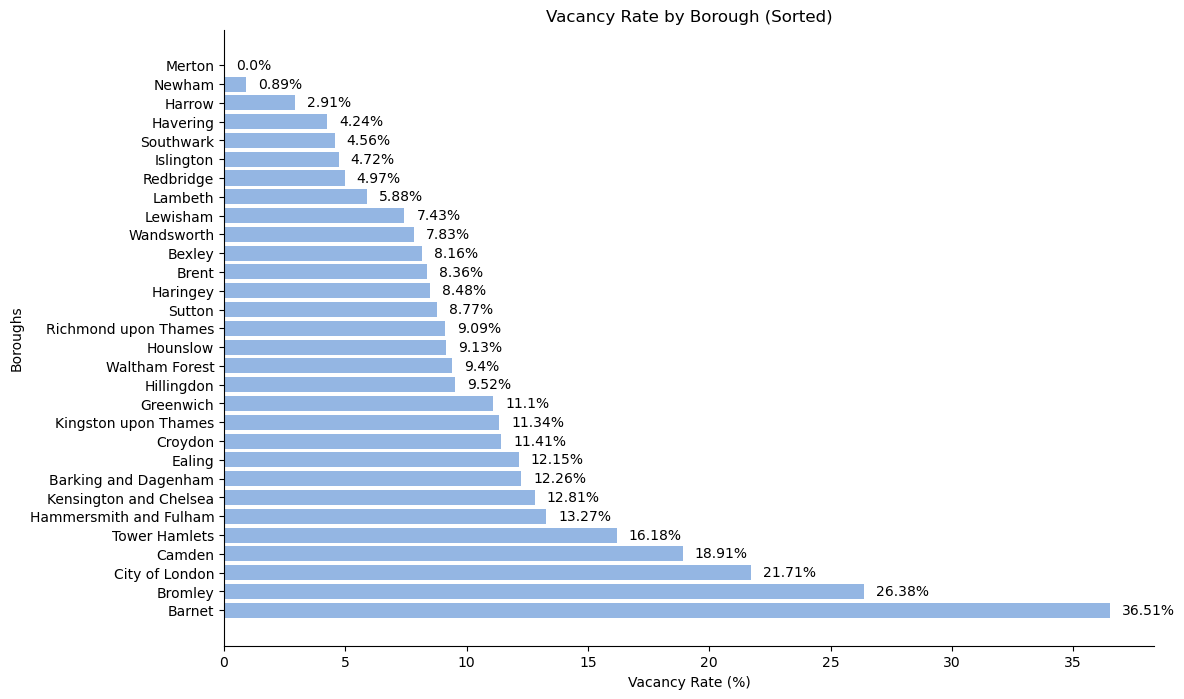

In [32]:
import matplotlib.pyplot as plt

# 将空置率转换为百分数格式，并保留小数点后两位
data_vacanty_sorted = data_vacancy.sort_values(by='vacancy_rate', ascending=False)
data_vacanty_sorted['vacancy_rate'] = (data_vacanty_sorted['vacancy_rate'] * 100).round(2)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制横向柱状图
bars = plt.barh(data_vacanty_sorted['voaBillingAuthorityName'], data_vacanty_sorted['vacancy_rate'], color='#94b6e3')

# 在每个柱子末端标上具体数据
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}%', 
             va='center', ha='left', color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加标题和标签
plt.xlabel('Vacancy Rate (%)')
plt.ylabel('Boroughs')
plt.title('Vacancy Rate by Borough (Sorted)')

# 显示图形
plt.show()

In [33]:
import pandas as pd

# 假设 data_cleaned 是你之前处理过的数据集
# 将 laOccupationState 为 False 的行过滤掉，形成新的数据集 data_cleaned_occupy
data_cleaned_occupy = data_cleaned[data_cleaned['laOccupationState'] != False]

# 检查新数据集的结构
print(data_cleaned_occupy.head())

   voaBillingAuthorityName                              laRatepayerName  \
0           City of London                          TOM HIXSON & CO LTD   
8           City of London                    EVANS CYCLES PROPERTY LTD   
9           City of London  CITY OF LONDON DEPT OFTHE BUILT ENVIRONMENT   
11          City of London                      ALDGATE CITY BAKERY LTD   
12          City of London                      ALDGATE CITY BAKERY LTD   

   laRecordDate laOccupationState laOccupationStateDate  laRatesPaid  \
0    2023-12-01              True            1995-04-01          0.0   
8    2023-12-01              True            2018-10-30      47435.0   
9    2023-12-01              True            1995-04-01      18886.0   
11   2023-12-01              True            1995-04-01      18886.0   
12   2023-12-01              True            2019-01-01      15543.0   

    laRatesReliefsAmount                                 voaPropertyAddress  \
0                    NaN  309 CENTRAL

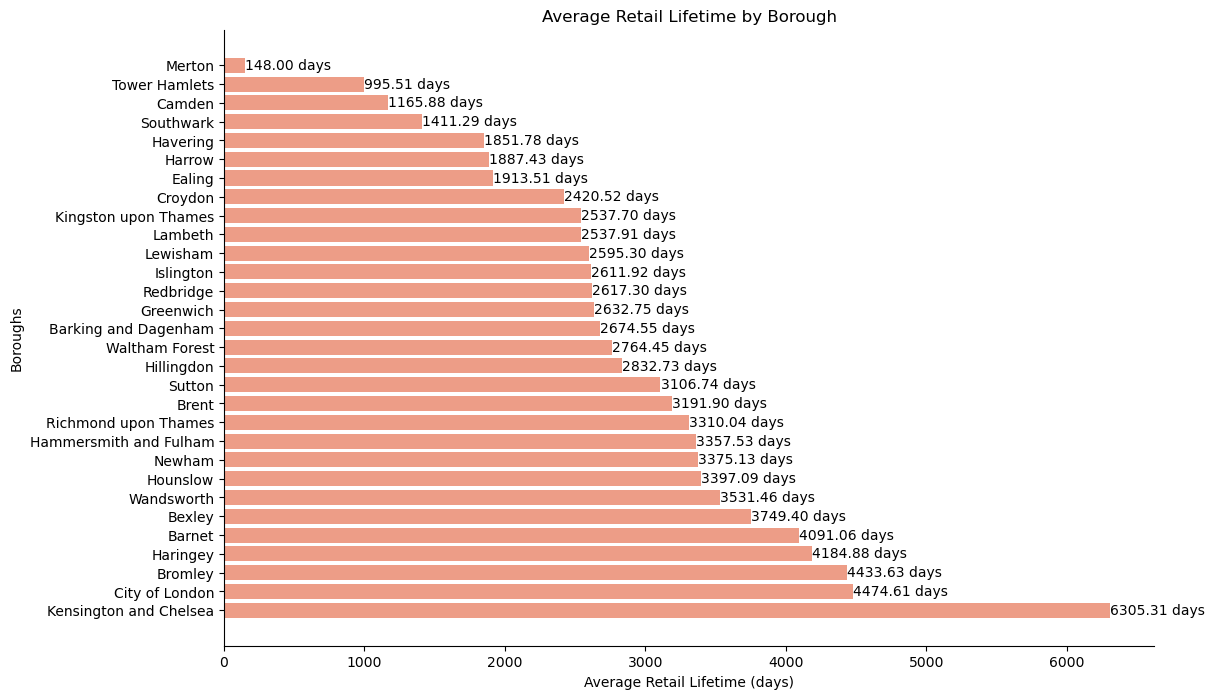

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 data_cleaned_occupy 是你已经过滤后的数据集
# 按 borough (voaBillingAuthorityName) 分组，计算每个分区的平均寿命
borough_lifetime = data_cleaned_occupy.groupby('voaBillingAuthorityName')['retail_lifetime'].mean().reset_index()

# 按平均寿命从高到低排序
borough_lifetime_occupy_sorted = borough_lifetime.sort_values(by='retail_lifetime', ascending=False)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制横向柱状图
bars = plt.barh(borough_lifetime_occupy_sorted['voaBillingAuthorityName'], borough_lifetime_occupy_sorted['retail_lifetime'], color='#ed9d87')

# 在每个柱子末端标上具体数据
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f} days', 
             va='center', ha='left', color='black')

# 移除右侧和上侧的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加标题和标签
plt.xlabel('Average Retail Lifetime (days)')
plt.ylabel('Boroughs')
plt.title('Average Retail Lifetime by Borough')

# 显示图形
plt.show()

In [35]:
print(borough_lifetime_occupy_sorted)

   voaBillingAuthorityName  retail_lifetime
17  Kensington and Chelsea      6305.309654
6           City of London      4474.605324
4                  Bromley      4433.629846
11                Haringey      4184.881459
1                   Barnet      4091.060730
2                   Bexley      3749.401013
29              Wandsworth      3531.464077
15                Hounslow      3397.086746
22                  Newham      3375.132861
10  Hammersmith and Fulham      3357.528789
24    Richmond upon Thames      3310.039183
3                    Brent      3191.899593
26                  Sutton      3106.739186
14              Hillingdon      2832.726371
28          Waltham Forest      2764.446290
0     Barking and Dagenham      2674.554577
9                Greenwich      2632.746277
23               Redbridge      2617.295279
16               Islington      2611.921656
20                Lewisham      2595.296682
19                 Lambeth      2537.907478
18    Kingston upon Thames      

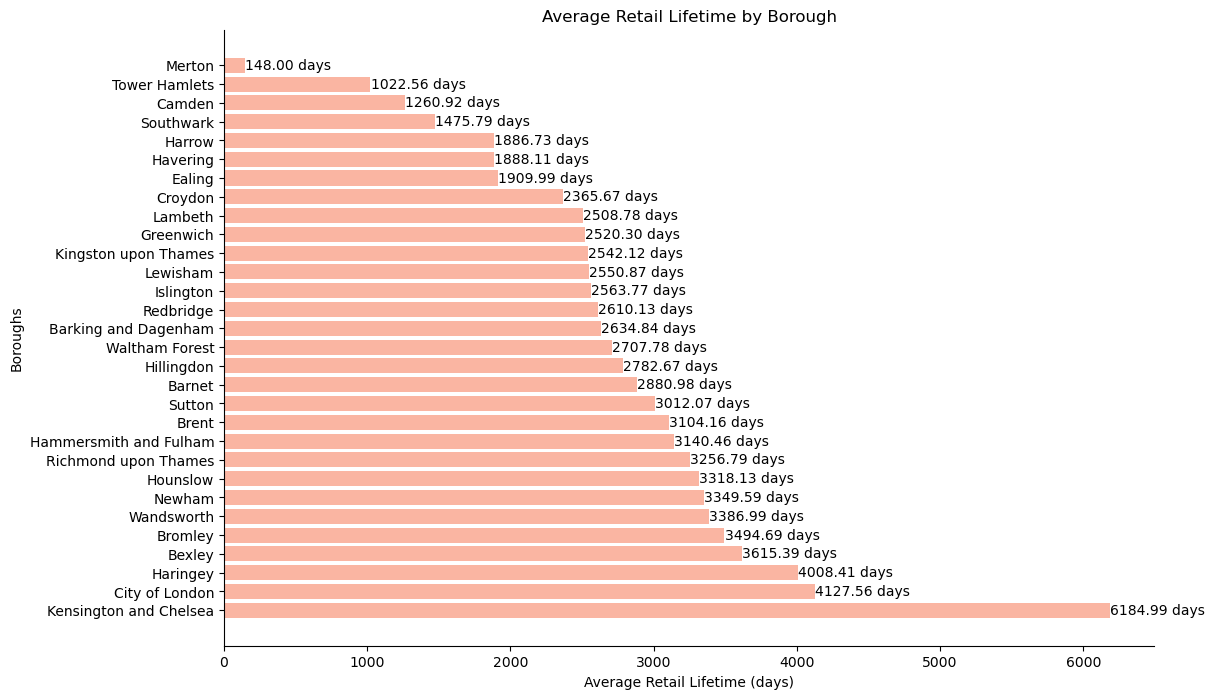

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 data_cleaned 是你已经处理过的数据集
# 按 borough (voaBillingAuthorityName) 分组，计算每个分区的平均寿命
borough_lifetime = data_cleaned.groupby('voaBillingAuthorityName')['retail_lifetime'].mean().reset_index()

# 按平均寿命从高到低排序
borough_lifetime_sorted = borough_lifetime.sort_values(by='retail_lifetime', ascending=False)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制横向柱状图
bars = plt.barh(borough_lifetime_sorted['voaBillingAuthorityName'], borough_lifetime_sorted['retail_lifetime'], color='#fab5a2')

# 在每个柱子末端标上具体数据
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f} days', 
             va='center', ha='left', color='black')

# 移除右侧和上侧的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加标题和标签
plt.xlabel('Average Retail Lifetime (days)')
plt.ylabel('Boroughs')
plt.title('Average Retail Lifetime by Borough')

# 显示图形
plt.show()

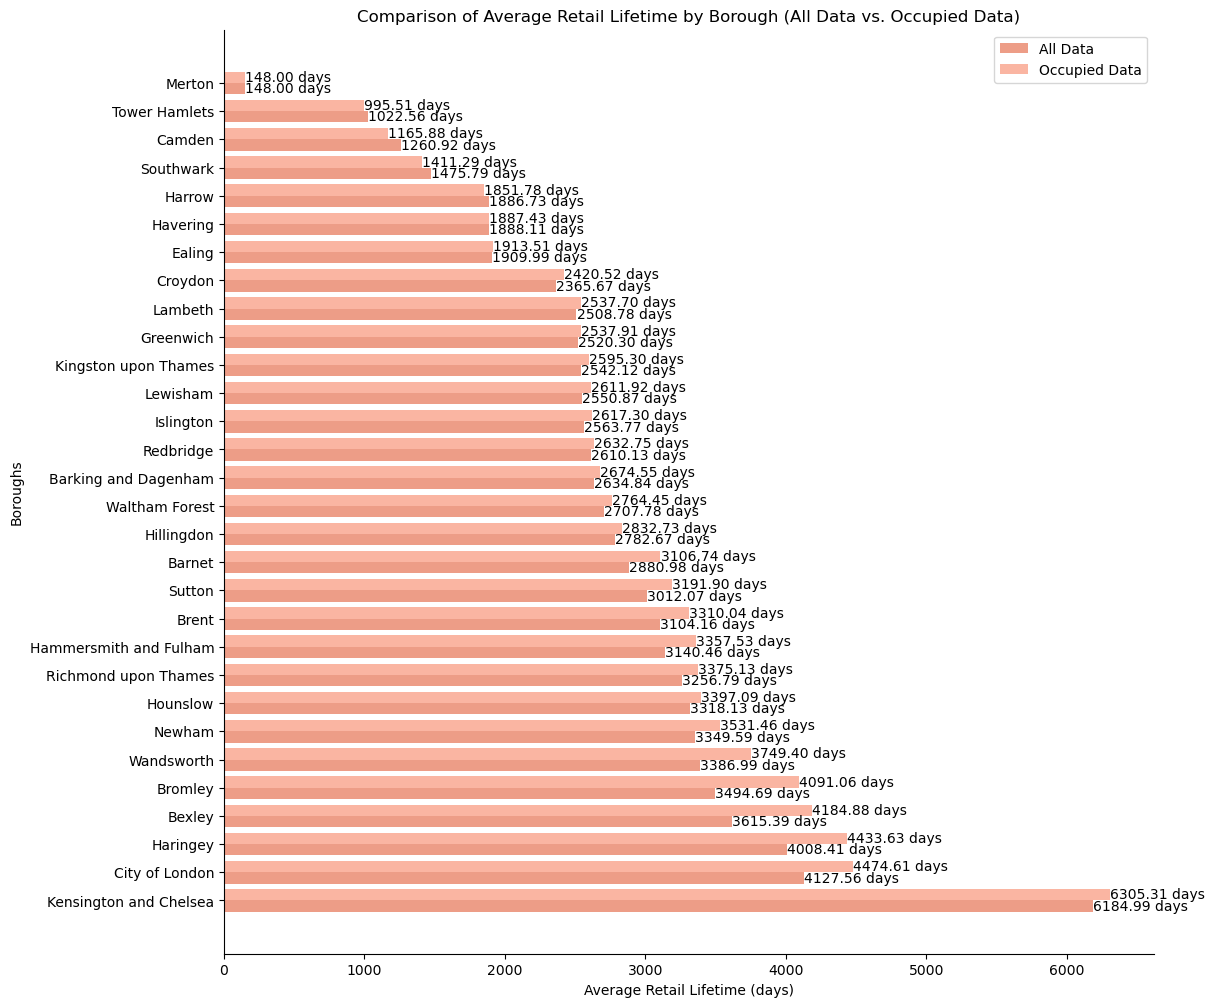

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 计算两个数据集的偏移量，以使它们的柱子不重合
y_pos = np.arange(len(borough_lifetime_sorted))

# 设置图形大小
plt.figure(figsize=(12, 12))

# 绘制横向柱状图，使用不同颜色区分 data_cleaned 和 data_cleaned_occupy
bars_all = plt.barh(y_pos - 0.2, borough_lifetime_sorted['retail_lifetime'], height=0.4, color='#ed9d87', label='All Data')
bars_occupy = plt.barh(y_pos + 0.2, borough_lifetime_occupy_sorted['retail_lifetime'], height=0.4, color='#fab5a2', label='Occupied Data')

# 在每个柱子末端标上具体数据（对于 data_cleaned_occupy）
for bar in bars_all:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f} days', 
             va='center', ha='left', color='black')

for bar in bars_occupy:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f} days', 
             va='center', ha='left', color='black')

# 设置 y 轴刻度和标签
plt.yticks(y_pos, borough_lifetime_sorted['voaBillingAuthorityName'])

# 移除右侧和上侧的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加图例、标题和标签
plt.xlabel('Average Retail Lifetime (days)')
plt.ylabel('Boroughs')
plt.title('Comparison of Average Retail Lifetime by Borough (All Data vs. Occupied Data)')
plt.legend()

# 显示图形
plt.show()

In [38]:
import pandas as pd

# 计算每个店铺的税务减免率
data_cleaned_occupy['tax_relief_rate'] = (data_cleaned_occupy['laRatesReliefsAmount'] / (data_cleaned_occupy['laRatesPaid'] + data_cleaned_occupy['laRatesReliefsAmount'])) * 100

# 按区 (borough) 分组计算平均税务减免率
average_relief_rate_by_borough = data_cleaned_occupy.groupby('voaBillingAuthorityName')['tax_relief_rate'].mean().reset_index()

# 查看每个区的平均税务减免率
print(average_relief_rate_by_borough)

   voaBillingAuthorityName  tax_relief_rate
0     Barking and Dagenham        71.755529
1                   Barnet        72.204944
2                   Bexley        87.740535
3                    Brent        74.476833
4                  Bromley        62.804586
5                   Camden        79.605047
6           City of London        63.330726
7                  Croydon        65.029986
8                   Ealing        78.971512
9                Greenwich        65.979693
10  Hammersmith and Fulham        76.109452
11                Haringey        74.912881
12                  Harrow        68.807266
13                Havering        54.734612
14              Hillingdon        81.736001
15                Hounslow        82.613920
16               Islington        63.828585
17  Kensington and Chelsea        77.221973
18    Kingston upon Thames        78.972898
19                 Lambeth        68.102412
20                Lewisham        79.713945
21                  Merton      

/tmp/ipykernel_60037/4246057439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_occupy['tax_relief_rate'] = (data_cleaned_occupy['laRatesReliefsAmount'] / (data_cleaned_occupy['laRatesPaid'] + data_cleaned_occupy['laRatesReliefsAmount'])) * 100


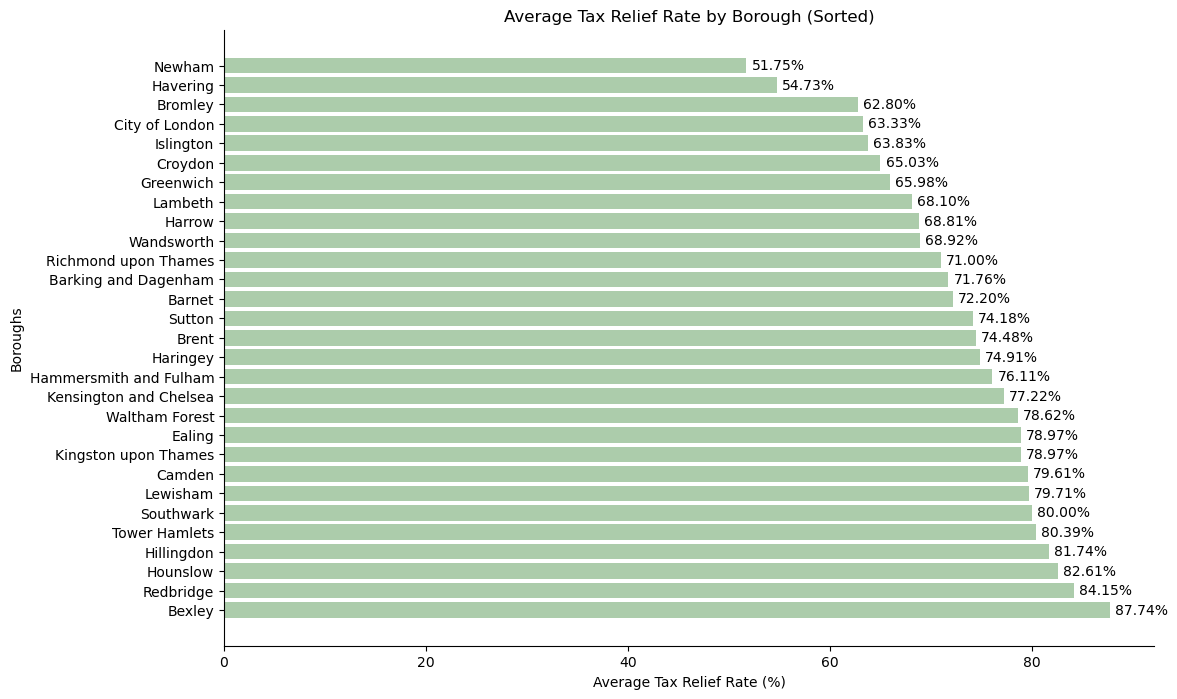

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 检查并处理 NaN 或 inf 值
average_relief_rate_by_borough = average_relief_rate_by_borough.replace([np.inf, -np.inf], np.nan).dropna()

# 按照 tax_relief_rate 从低到高排序
average_relief_rate_by_borough_sorted = average_relief_rate_by_borough.sort_values(by='tax_relief_rate', ascending=False)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制横向柱状图
plt.barh(average_relief_rate_by_borough_sorted['voaBillingAuthorityName'], average_relief_rate_by_borough_sorted['tax_relief_rate'], color='#acccab')

# 在每个柱子末端标上具体数据
for index, value in enumerate(average_relief_rate_by_borough_sorted['tax_relief_rate']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', ha='left', color='black')

# 移除右侧和上侧的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加标题和标签
plt.xlabel('Average Tax Relief Rate (%)')
plt.ylabel('Boroughs')
plt.title('Average Tax Relief Rate by Borough (Sorted)')

# 显示图形
plt.show()

In [40]:
import pandas as pd

# 按区 (borough) 分组计算平均商业评估价值 (voaRateableValue)
average_rateable_value_by_borough = data_cleaned_occupy.groupby('voaBillingAuthorityName')['voaRateableValue'].mean().reset_index()

# 查看每个区的平均商业评估价值
print(average_rateable_value_by_borough.head())

  voaBillingAuthorityName  voaRateableValue
0    Barking and Dagenham      34201.987382
1                  Barnet      36743.317111
2                  Bexley      32802.803201
3                   Brent      24530.661491
4                 Bromley      42226.669591


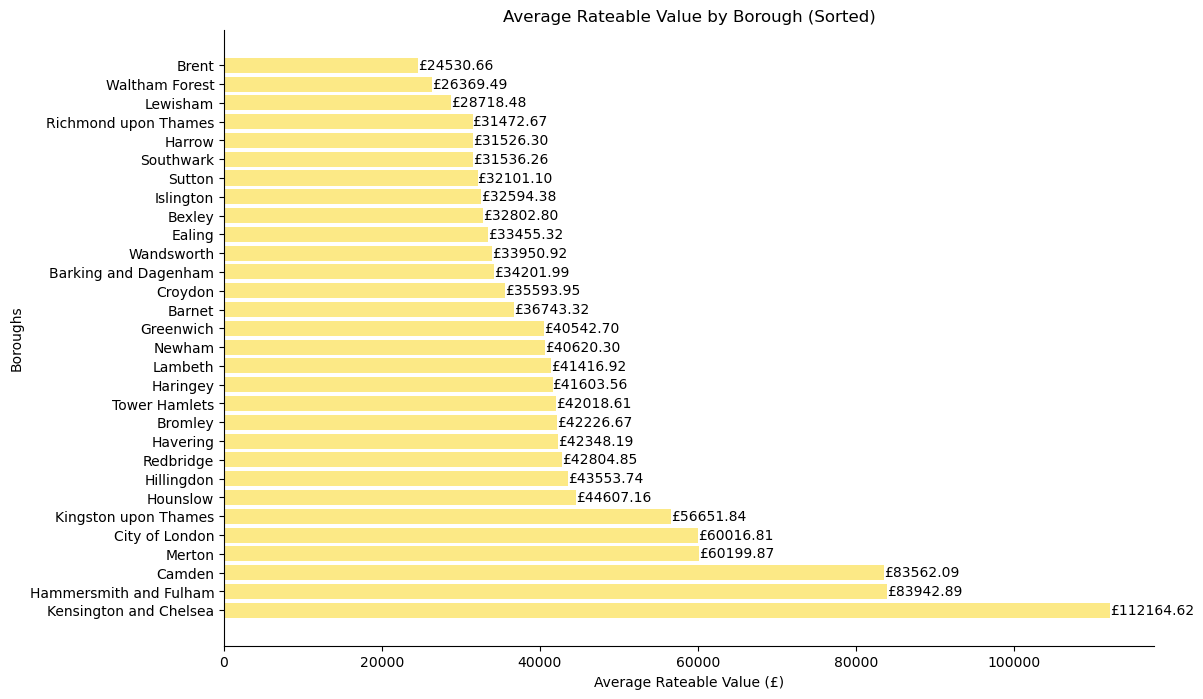

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 按区 (borough) 分组计算平均商业评估价值 (voaRateableValue)，并保留小数点后两位
average_rateable_value_by_borough = data_cleaned_occupy.groupby('voaBillingAuthorityName')['voaRateableValue'].mean().round(2).reset_index()

# 按照 voaRateableValue 从低到高排序
average_rateable_value_by_borough_sorted = average_rateable_value_by_borough.sort_values(by='voaRateableValue', ascending=False)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制横向柱状图
plt.barh(average_rateable_value_by_borough_sorted['voaBillingAuthorityName'], average_rateable_value_by_borough_sorted['voaRateableValue'], color='#fce986')

# 在每个柱子末端标上具体数据
for index, value in enumerate(average_rateable_value_by_borough_sorted['voaRateableValue']):
    plt.text(value + 0.5, index, f'£{value:.2f}', va='center', ha='left', color='black')

# 移除右侧和上侧的边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# 添加标题和标签
plt.xlabel('Average Rateable Value (£)')
plt.ylabel('Boroughs')
plt.title('Average Rateable Value by Borough (Sorted)')

# 显示图形
plt.show()

In [42]:
crime_file_path = '/home/jovyan/CASA_Study/DS/Number of criminals.csv'  # 替换为实际路径
crime_data = pd.read_csv(crime_file_path)

# 查看数据的前几行
print(crime_data.head())

   LSOA Code                  LSOA Name    Borough             Major Category  \
0  E01000006  Barking and Dagenham 016A  E09000002  ARSON AND CRIMINAL DAMAGE   
1  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
2  E01000006  Barking and Dagenham 016A  E09000002                   BURGLARY   
3  E01000006  Barking and Dagenham 016A  E09000002              DRUG OFFENCES   
4  E01000006  Barking and Dagenham 016A  E09000002              DRUG OFFENCES   

           Minor Category  202207  202208  202209  202210  202211  ...  \
0         CRIMINAL DAMAGE       2       1       0       0       0  ...   
1  BURGLARY - RESIDENTIAL       0       0       0       0       0  ...   
2  BURGLARY IN A DWELLING       0       0       0       0       2  ...   
3     POSSESSION OF DRUGS       0       1       0       4       1  ...   
4    TRAFFICKING OF DRUGS       0       0       0       0       0  ...   

   202309  202310  202311  202312  202401  202402  202403  202404  2

In [43]:
import pandas as pd

# 加载CSV文件
file_path = '/home/jovyan/CASA_Study/DS/Number of criminals.csv'  # 请将此路径替换为您本地的文件路径
data = pd.read_csv(file_path)

# 获取Major Category列中的唯一值
major_categories = data['Major Category'].unique()

# 显示所有种类
print("Major Category包含的种类有：")
for category in major_categories:
    print(category)

Major Category包含的种类有：
ARSON AND CRIMINAL DAMAGE
BURGLARY
DRUG OFFENCES
MISCELLANEOUS CRIMES AGAINST SOCIETY
PUBLIC ORDER OFFENCES
ROBBERY
THEFT
VEHICLE OFFENCES
VIOLENCE AGAINST THE PERSON
POSSESSION OF WEAPONS


In [44]:
import pandas as pd

# 假设你已经读取了 crime_data 数据

# 使用正则表达式去掉 'LSOA Name' 列中最后的数字和字母
crime_data['Borough'] = crime_data['LSOA Name'].str.replace(r'\s\d+[A-Z]$', '', regex=True)

# 选择特定时间范围内的列
date_columns = [col for col in crime_data.columns if col.isdigit() and int(col) >= 202301 and int(col) <= 202312]

# 将这些列转换为数字类型，无法转换的会变成 NaN
crime_data[date_columns] = crime_data[date_columns].apply(pd.to_numeric, errors='coerce')

# 计算每个记录的总犯罪数
crime_data['Total Crimes'] = crime_data[date_columns].sum(axis=1)

# 按 'Borough' 进行分组，然后对 'Total Crimes' 进行求和
annual_crime_data_by_borough = crime_data.groupby('Borough')['Total Crimes'].sum().reset_index()

# 显示结果
print(annual_crime_data_by_borough)

                   Borough  Total Crimes
0     Barking and Dagenham         20456
1                   Barnet         27525
2                   Bexley         16034
3                    Brent         30740
4                  Bromley         22777
5                   Camden         38900
6                  Croydon         32368
7                   Ealing         30731
8                  Enfield         28645
9                Greenwich         27142
10                 Hackney         30924
11  Hammersmith and Fulham         21130
12                Haringey         29103
13                  Harrow         15059
14                Havering         20491
15              Hillingdon         27149
16                Hounslow         26479
17               Islington         27817
18  Kensington and Chelsea         22284
19    Kingston upon Thames         11739
20                 Lambeth         34270
21                Lewisham         28661
22                  Merton         13587
23              

In [45]:
import pandas as pd

# 加载Excel文件
file_path = '/home/jovyan/CASA_Study/DS/2021_10yr.xlsx'  # 请将此路径替换为您本地的文件路径
excel_data = pd.ExcelFile(file_path)

# 加载 'persons' 表
persons_data = pd.read_excel(file_path, sheet_name='persons')

# 选择相关的列，即区(borough)、年龄(age)和2023年人口数据
columns_of_interest = ['borough', 'age', '2023']
population_2023 = persons_data.loc[:, columns_of_interest]

# 将 '2023' 列名更改为 'population2023'
population_2023 = population_2023.rename(columns={'2023': 'population2023'})

# 确保人口数据为整数类型
population_2023.loc[:, 'population2023'] = population_2023['population2023'].astype(int)

# 按区分组并对2023年人口数据求和，得到每个区的总人口
total_population_2023_by_borough = population_2023.groupby('borough')['population2023'].sum().reset_index()

# 显示结果数据集
print(total_population_2023_by_borough)

                   borough  population2023
0     Barking and Dagenham        227884.0
1                   Barnet        399548.0
2                   Bexley        249998.0
3                    Brent        353901.0
4                  Bromley        334075.0
5                   Camden        214366.0
6           City of London          8624.0
7                  Croydon        397454.0
8                   Ealing        379147.0
9                  Enfield        335820.0
10               Greenwich        297644.0
11                 Hackney        264155.0
12  Hammersmith and Fulham        186794.0
13                Haringey        272628.0
14                  Harrow        269372.0
15                Havering        267624.0
16              Hillingdon        314596.0
17                Hounslow        300142.0
18               Islington        223029.0
19  Kensington and Chelsea        143953.0
20    Kingston upon Thames        171969.0
21                 Lambeth        323481.0
22         

In [46]:
import pandas as pd

# 假设我们已经有每个区的人口数据存储在 total_population_2023_by_borough 数据框中
# 并且有每个区的犯罪数据存储在 annual_crime_data_by_borough 数据框中

# 将人口数据和犯罪数据进行合并，基于区名进行合并
crime_rate_data = pd.merge(annual_crime_data_by_borough, total_population_2023_by_borough, left_on='Borough', right_on='borough')

# 计算每个区的犯罪率（犯罪率 = 总犯罪数 / 总人口 * 100%）
crime_rate_data['Crime Rate (%)'] = (crime_rate_data['Total Crimes'] / crime_rate_data['population2023']) * 100

# 只保留需要的列
crime_rate_data = crime_rate_data[['Borough', 'Total Crimes', 'population2023', 'Crime Rate (%)']]

# 显示结果
print(crime_rate_data)

                   Borough  Total Crimes  population2023  Crime Rate (%)
0     Barking and Dagenham         20456        227884.0        8.976497
1                   Barnet         27525        399548.0        6.889035
2                   Bexley         16034        249998.0        6.413651
3                    Brent         30740        353901.0        8.686045
4                  Bromley         22777        334075.0        6.817930
5                   Camden         38900        214366.0       18.146534
6                  Croydon         32368        397454.0        8.143836
7                   Ealing         30731        379147.0        8.105300
8                  Enfield         28645        335820.0        8.529867
9                Greenwich         27142        297644.0        9.118947
10                 Hackney         30924        264155.0       11.706763
11  Hammersmith and Fulham         21130        186794.0       11.311927
12                Haringey         29103        272

In [47]:
import pandas as pd

# 假设我们已经有每个区的人口数据存储在 total_population_2023_by_borough 数据框中
# 并且有每个区的犯罪数据存储在 annual_crime_data_by_borough 数据框中

# 合并人口数据和犯罪数据，基于区名进行合并
crime_rate_data = pd.merge(annual_crime_data_by_borough, total_population_2023_by_borough, left_on='Borough', right_on='borough')

# 计算每个区的犯罪率（犯罪率 = 总犯罪数 / 总人口 * 100%），并保留两位小数
crime_rate_data['Crime Rate (%)'] = round((crime_rate_data['Total Crimes'] / crime_rate_data['population2023']) * 100, 2)

# 只保留需要的列
crime_rate_data = crime_rate_data[['Borough', 'Total Crimes', 'population2023', 'Crime Rate (%)']]

# 显示结果
print(crime_rate_data)

                   Borough  Total Crimes  population2023  Crime Rate (%)
0     Barking and Dagenham         20456        227884.0            8.98
1                   Barnet         27525        399548.0            6.89
2                   Bexley         16034        249998.0            6.41
3                    Brent         30740        353901.0            8.69
4                  Bromley         22777        334075.0            6.82
5                   Camden         38900        214366.0           18.15
6                  Croydon         32368        397454.0            8.14
7                   Ealing         30731        379147.0            8.11
8                  Enfield         28645        335820.0            8.53
9                Greenwich         27142        297644.0            9.12
10                 Hackney         30924        264155.0           11.71
11  Hammersmith and Fulham         21130        186794.0           11.31
12                Haringey         29103        272

In [48]:
import pandas as pd

# 加载Excel文件
file_path = '/home/jovyan/CASA_Study/DS/income-of-tax-payers.xlsx'  # 请将此路径替换为您本地的文件路径
income_data = pd.read_excel(file_path)

# 清理数据：选择相关列，并删除不必要的行
income_data_cleaned = income_data.drop([0]).rename(columns={
    'Unnamed: 1': 'Area',
    'Unnamed: 3': 'Mean Income'
})[['Area', 'Mean Income']]

# 将Mean Income列转换为数值类型
income_data_cleaned['Mean Income'] = pd.to_numeric(income_data_cleaned['Mean Income'], errors='coerce')

# 显示清理后的数据集
print(income_data_cleaned)

                      Area  Mean Income
1           City of London       167000
2     Barking and Dagenham        31800
3                   Barnet        59100
4                   Bexley        38000
5                    Brent        44100
6                  Bromley        54500
7                   Camden       119000
8                  Croydon        40900
9                   Ealing        46800
10                 Enfield        42800
11               Greenwich        48900
12                 Hackney        52500
13  Hammersmith and Fulham        83600
14                Haringey        57100
15                  Harrow        46500
16                Havering        40000
17              Hillingdon        41600
18                Hounslow        45400
19               Islington        76600
20  Kensington and Chelsea       208000
21    Kingston-upon-Thames        56500
22                 Lambeth        56100
23                Lewisham        44800
24                  Merton        63000


In [49]:
import pandas as pd

# 加载CSV文件
file_path = '/home/jovyan/CASA_Study/DS/area.csv'  # 请将此路径替换为您本地的文件路径
area_data = pd.read_csv(file_path)

# 提取英文区名，并将列名转换为英文
area_data['Area'] = area_data['区名'].str.extract(r'（(.+?)）')
area_data = area_data.rename(columns={'面积 (平方公里)': 'Area (sq km)'})

# 选择必要的列
area_data_cleaned = area_data[['Area', 'Area (sq km)']]

# 显示清理后的数据集
print(area_data_cleaned)

                      Area  Area (sq km)
0           City of London           2.9
1     Barking and Dagenham          36.1
2                   Barnet          86.7
3                   Bexley          60.6
4                    Brent          43.2
5                  Bromley         150.2
6                   Camden          21.8
7                  Croydon          87.0
8                   Ealing          55.5
9                  Enfield          82.2
10               Greenwich          47.4
11                 Hackney          19.1
12  Hammersmith and Fulham          16.4
13                Haringey          29.6
14                  Harrow          50.5
15                Havering         112.3
16              Hillingdon         115.7
17    Kingston upon Thames          37.4
18                Hounslow          55.9
19               Islington          14.9
20  Kensington and Chelsea          12.1
21                 Lambeth          26.8
22                Lewisham          35.2
23              

In [50]:
merged_data = pd.merge(area_data_cleaned, data_vacancy, left_on='Area', right_on='voaBillingAuthorityName')

# 计算每平方公里商铺密度并保留两位小数
merged_data['Shop Density (shops per sq km)'] = round(merged_data['total_shops'] / merged_data['Area (sq km)'], 2)

# 只保留相关列
Shop_Density_data = merged_data[['Area', 'total_shops', 'Area (sq km)', 'Shop Density (shops per sq km)']]

# 显示结果
print(Shop_Density_data)

                      Area  total_shops  Area (sq km)  \
0           City of London        18712           2.9   
1     Barking and Dagenham         3237          36.1   
2                   Barnet        13849          86.7   
3                   Bexley         8173          60.6   
4                    Brent        21692          43.2   
5                  Bromley        13034         150.2   
6                   Camden         1465          21.8   
7                  Croydon        15961          87.0   
8                   Ealing        15742          55.5   
9                Greenwich        11483          47.4   
10  Hammersmith and Fulham        13617          16.4   
11                Haringey         8268          29.6   
12                  Harrow         8941          50.5   
13                Havering         7881         112.3   
14              Hillingdon        10360         115.7   
15    Kingston upon Thames         7255          37.4   
16                Hounslow     

In [51]:
print(borough_lifetime_occupy_sorted.columns)
print(data_vacancy.columns)
print(average_relief_rate_by_borough.columns)
print(average_rateable_value_by_borough.columns)
print(total_population_2023_by_borough.columns)
print(crime_rate_data.columns)
print(income_data_cleaned.columns)
print(Shop_Density_data.columns)

# 重命名列名以统一合并的键
borough_lifetime_occupy_sorted = borough_lifetime_occupy_sorted.rename(columns={'voaBillingAuthorityName': 'borough'})
data_vacancy = data_vacancy.rename(columns={'voaBillingAuthorityName': 'borough'})
average_relief_rate_by_borough = average_relief_rate_by_borough.rename(columns={'voaBillingAuthorityName': 'borough'})
average_rateable_value_by_borough = average_rateable_value_by_borough.rename(columns={'voaBillingAuthorityName': 'borough'})
crime_rate_data = crime_rate_data.rename(columns={'Borough': 'borough'})
income_data_cleaned = income_data_cleaned.rename(columns={'Area': 'borough'})
shop_density_data = Shop_Density_data.rename(columns={'Area': 'borough'})

# 逐步合并数据集
merged_data = borough_lifetime_occupy_sorted[['borough', 'retail_lifetime']]
merged_data = merged_data.merge(data_vacancy[['borough', 'vacancy_rate']], on='borough', how='outer')
merged_data = merged_data.merge(average_relief_rate_by_borough[['borough', 'tax_relief_rate']], on='borough', how='outer')
merged_data = merged_data.merge(average_rateable_value_by_borough[['borough', 'voaRateableValue']], on='borough', how='outer')
merged_data = merged_data.merge(total_population_2023_by_borough[['borough', 'population2023']], on='borough', how='outer')
merged_data = merged_data.merge(crime_rate_data[['borough', 'Crime Rate (%)']], on='borough', how='outer')
merged_data = merged_data.merge(income_data_cleaned[['borough', 'Mean Income']], on='borough', how='outer')
merged_data = merged_data.merge(shop_density_data[['borough', 'Shop Density (shops per sq km)']], on='borough', how='outer')

# 显示合并后的数据集
print(merged_data)

Index(['voaBillingAuthorityName', 'retail_lifetime'], dtype='object')
Index(['voaBillingAuthorityName', 'total_shops', 'vacant_shops',
       'vacancy_rate'],
      dtype='object')
Index(['voaBillingAuthorityName', 'tax_relief_rate'], dtype='object')
Index(['voaBillingAuthorityName', 'voaRateableValue'], dtype='object')
Index(['borough', 'population2023'], dtype='object')
Index(['Borough', 'Total Crimes', 'population2023', 'Crime Rate (%)'], dtype='object')
Index(['Area', 'Mean Income'], dtype='object')
Index(['Area', 'total_shops', 'Area (sq km)',
       'Shop Density (shops per sq km)'],
      dtype='object')
                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham      2674.554577      0.122644        71.755529   
1                   Barnet      4091.060730      0.365081        72.204944   
2                   Bexley      3749.401013      0.081610        87.740535   
3                    Brent      3191.899593      0.083579        74.4

In [52]:
merged_data = merged_data[merged_data['borough'] != 'London (total)']

# 显示结果
print(merged_data)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham      2674.554577      0.122644        71.755529   
1                   Barnet      4091.060730      0.365081        72.204944   
2                   Bexley      3749.401013      0.081610        87.740535   
3                    Brent      3191.899593      0.083579        74.476833   
4                  Bromley      4433.629846      0.263772        62.804586   
5                   Camden      1165.875421      0.189078        79.605047   
6           City of London      4474.605324      0.217080        63.330726   
7                  Croydon      2420.524116      0.114091        65.029986   
8                   Ealing      1913.505387      0.121522        78.971512   
9                  Enfield              NaN           NaN              NaN   
10               Greenwich      2632.746277      0.111034        65.979693   
11                 Hackney              NaN           NaN       

In [53]:
kingston_income = merged_data.loc[merged_data['borough'] == 'Kingston-upon-Thames', 'Mean Income'].values[0]

# 将 'Kingston upon Thames' 中 Mean Income 为 NaN 的值替换为 'Kingston-upon-Thames' 的 Mean Income
merged_data.loc[(merged_data['borough'] == 'Kingston upon Thames') & (merged_data['Mean Income'].isna()), 'Mean Income'] = kingston_income

# 删除 'Kingston-upon-Thames' 行
merged_data = merged_data[merged_data['borough'] != 'Kingston-upon-Thames']

# 显示结果
print(merged_data)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham      2674.554577      0.122644        71.755529   
1                   Barnet      4091.060730      0.365081        72.204944   
2                   Bexley      3749.401013      0.081610        87.740535   
3                    Brent      3191.899593      0.083579        74.476833   
4                  Bromley      4433.629846      0.263772        62.804586   
5                   Camden      1165.875421      0.189078        79.605047   
6           City of London      4474.605324      0.217080        63.330726   
7                  Croydon      2420.524116      0.114091        65.029986   
8                   Ealing      1913.505387      0.121522        78.971512   
9                  Enfield              NaN           NaN              NaN   
10               Greenwich      2632.746277      0.111034        65.979693   
11                 Hackney              NaN           NaN       

In [54]:
richmond_income = merged_data.loc[merged_data['borough'] == 'Richmond-upon-Thames', 'Mean Income'].values[0]

# 将 'Richmond upon Thames' 中 Mean Income 为 NaN 的值替换为 'Richmond-upon-Thames' 的 Mean Income
merged_data.loc[(merged_data['borough'] == 'Richmond upon Thames') & (merged_data['Mean Income'].isna()), 'Mean Income'] = richmond_income

# 删除 'Richmond-upon-Thames' 行
merged_data = merged_data[merged_data['borough'] != 'Richmond-upon-Thames']

# 显示结果
print(merged_data)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham      2674.554577      0.122644        71.755529   
1                   Barnet      4091.060730      0.365081        72.204944   
2                   Bexley      3749.401013      0.081610        87.740535   
3                    Brent      3191.899593      0.083579        74.476833   
4                  Bromley      4433.629846      0.263772        62.804586   
5                   Camden      1165.875421      0.189078        79.605047   
6           City of London      4474.605324      0.217080        63.330726   
7                  Croydon      2420.524116      0.114091        65.029986   
8                   Ealing      1913.505387      0.121522        78.971512   
9                  Enfield              NaN           NaN              NaN   
10               Greenwich      2632.746277      0.111034        65.979693   
11                 Hackney              NaN           NaN       

In [55]:
merged_data1 = merged_data.dropna()

# 显示结果
print(merged_data1)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham      2674.554577      0.122644        71.755529   
1                   Barnet      4091.060730      0.365081        72.204944   
2                   Bexley      3749.401013      0.081610        87.740535   
3                    Brent      3191.899593      0.083579        74.476833   
4                  Bromley      4433.629846      0.263772        62.804586   
5                   Camden      1165.875421      0.189078        79.605047   
7                  Croydon      2420.524116      0.114091        65.029986   
8                   Ealing      1913.505387      0.121522        78.971512   
10               Greenwich      2632.746277      0.111034        65.979693   
12  Hammersmith and Fulham      3357.528789      0.132702        76.109452   
13                Haringey      4184.881459      0.084785        74.912881   
14                  Harrow      1887.430365      0.029080       

In [56]:
num_rows = len(merged_data1)

# 显示结果
print(f"The number of rows in merged_data1 is: {num_rows}")

The number of rows in merged_data1 is: 28


In [57]:
import pandas as pd

# 假设 merged_data1 是合并后的数据集

# 保留 retail_lifetime 和 tax_relief_rate 小数点后两位
merged_data1['retail_lifetime'] = merged_data1['retail_lifetime'].round(2)
merged_data1['tax_relief_rate'] = merged_data1['tax_relief_rate'].round(2)

# vacancy_rate 乘以 100 并保留小数点后两位
merged_data1['vacancy_rate'] = (merged_data1['vacancy_rate'] * 100).round(2)

# 显示结果
print(merged_data1[['retail_lifetime', 'tax_relief_rate', 'vacancy_rate']])

    retail_lifetime  tax_relief_rate  vacancy_rate
0           2674.55            71.76         12.26
1           4091.06            72.20         36.51
2           3749.40            87.74          8.16
3           3191.90            74.48          8.36
4           4433.63            62.80         26.38
5           1165.88            79.61         18.91
7           2420.52            65.03         11.41
8           1913.51            78.97         12.15
10          2632.75            65.98         11.10
12          3357.53            76.11         13.27
13          4184.88            74.91          8.48
14          1887.43            68.81          2.91
15          1851.78            54.73          4.24
16          2832.73            81.74          9.52
17          3397.09            82.61          9.13
18          2611.92            63.83          4.72
19          6305.31            77.22         12.81
20          2537.70            78.97         11.34
22          2537.91            

/tmp/ipykernel_60037/1359588191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data1['retail_lifetime'] = merged_data1['retail_lifetime'].round(2)
/tmp/ipykernel_60037/1359588191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data1['tax_relief_rate'] = merged_data1['tax_relief_rate'].round(2)
/tmp/ipykernel_60037/1359588191.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [58]:
merged_data1.loc[:, 'retail_lifetime'] = merged_data1['retail_lifetime'].round(2)
merged_data1.loc[:, 'tax_relief_rate'] = merged_data1['tax_relief_rate'].round(2)

# vacancy_rate 乘以 100 并保留小数点后两位
merged_data1.loc[:, 'vacancy_rate'] = (merged_data1['vacancy_rate']/100).round(2)

# 显示结果
print(merged_data1)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham          2674.55          0.12            71.76   
1                   Barnet          4091.06          0.37            72.20   
2                   Bexley          3749.40          0.08            87.74   
3                    Brent          3191.90          0.08            74.48   
4                  Bromley          4433.63          0.26            62.80   
5                   Camden          1165.88          0.19            79.61   
7                  Croydon          2420.52          0.11            65.03   
8                   Ealing          1913.51          0.12            78.97   
10               Greenwich          2632.75          0.11            65.98   
12  Hammersmith and Fulham          3357.53          0.13            76.11   
13                Haringey          4184.88          0.08            74.91   
14                  Harrow          1887.43          0.03       

/tmp/ipykernel_60037/3863431112.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='borough', y='retail_lifetime', data=merged_data1, palette='viridis')


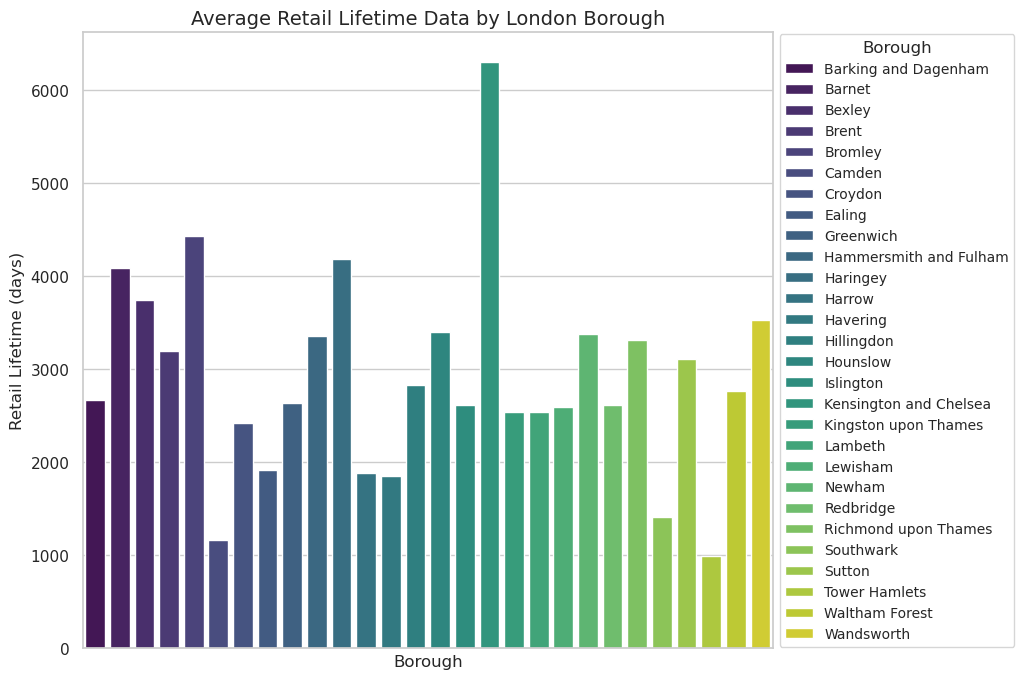

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 merged_data1 是您的现有 DataFrame

# 设置图表大小和样式
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# 创建柱状图
bars = sns.barplot(x='borough', y='retail_lifetime', data=merged_data1, palette='viridis')

# 移除x轴上的Borough名称标签，只保留一个总的标签
bars.set_xticks([])  # 移除所有x轴标签
bars.set_xlabel('Borough', fontsize=12)  # 仅保留一个总的标签

# 设置标题和y轴标签
plt.title('Average Retail Lifetime Data by London Borough', fontsize=14)
plt.ylabel('Retail Lifetime (days)', fontsize=12)

# 获取颜色
colors = [bars.patches[i].get_facecolor() for i in range(len(bars.patches))]

# 调整布局，给图例留出空间
plt.subplots_adjust(right=0.7)

# 添加图例到右边，从上到下排列
from matplotlib.patches import Patch

# 创建图例条目
legend_elements = [Patch(facecolor=colors[i], label=borough) for i, borough in enumerate(merged_data1['borough'])]

# 添加图例
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Borough", fontsize=10)

# 显示图表
plt.show()

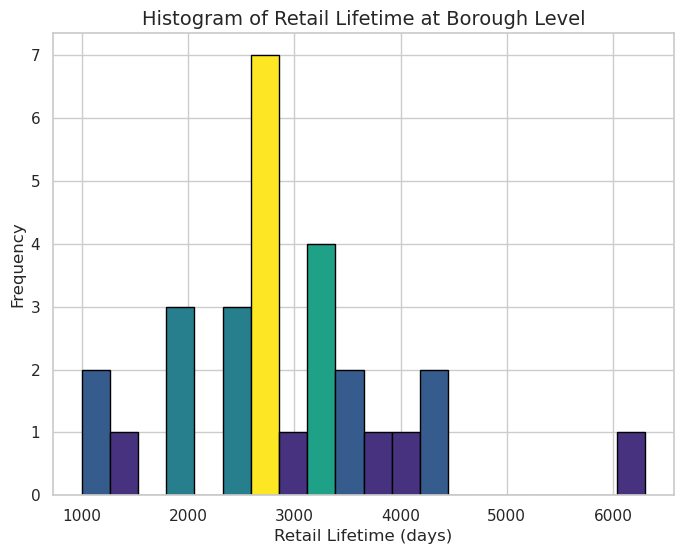

In [60]:
import matplotlib.pyplot as plt

# 假设 merged_data1 是您的现有 DataFrame，且包含 'retail_lifetime' 列
retail_lifetime = merged_data1['retail_lifetime']

# 创建直方图
plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(retail_lifetime, bins=20, edgecolor='black', color='white')

# 设置标题和标签
plt.title('Histogram of Retail Lifetime at Borough Level', fontsize=14)
plt.xlabel('Retail Lifetime (days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# 根据频率（n）的值设置阴影颜色，频率越高颜色越深
for i in range(len(patches)):
    plt.setp(patches[i], 'facecolor', plt.cm.viridis(n[i] / max(n)))

# 显示图表
plt.show()

In [61]:
import pandas as pd

# 将 DataFrame 导出为 CSV 文件，指定本地保存路径
file_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'  # 替换为你的本地路径
borough_lifetime_occupy_sorted.to_csv(file_path, index=False)

In [62]:
import geopandas as gpd
import pandas as pd

# 加载Shapefile
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

# 加载零售寿命数据
csv_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'
retail_data = pd.read_csv(csv_path)

# 合并数据，确保零售寿命数据和几何数据连接在一起
gdf = gdf.merge(retail_data, left_on='NAME', right_on='borough')

In [63]:
from libpysal.weights import Queen

# 创建基于女王邻接规则的权重矩阵，明确设置 use_index 参数
w = Queen.from_dataframe(gdf, use_index=False)

In [64]:
from esda.moran import Moran

# 计算Moran's I
y = gdf['retail_lifetime'].values  # 选择零售寿命数据列
moran = Moran(y, w)

# 输出结果
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")
print(f"Z-score: {moran.z_sim}")

Moran's I: -0.12249702230416153
P-value: 0.251
Z-score: -0.695770455467053


In [66]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# 加载Shapefile
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

# 加载零售寿命数据
csv_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'
retail_data = pd.read_csv(csv_path)

# 合并数据，确保零售寿命数据和几何数据连接在一起
gdf = gdf.merge(retail_data, left_on='NAME', right_on='borough')

# 创建基于女王邻接规则的空间权重矩阵
w = Queen.from_dataframe(gdf, use_index=False)

In [67]:
# 计算局部 Moran's I
y = gdf['retail_lifetime'].values  # 选择零售寿命数据列
moran_local = Moran_Local(y, w)

# 查看局部Moran's I结果
gdf['Moran_I'] = moran_local.Is  # 局部 Moran's I 值
gdf['p-value'] = moran_local.p_sim  # p-value
gdf['significant'] = moran_local.p_sim < 0.05  # 标记显著性

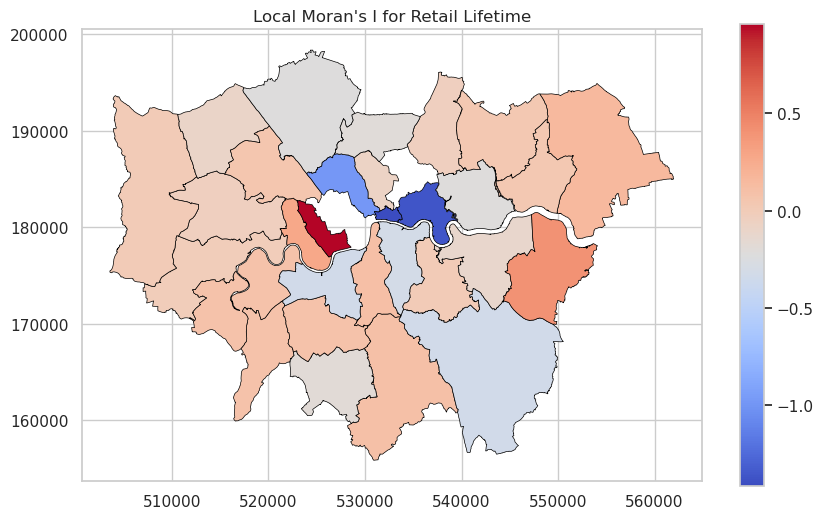

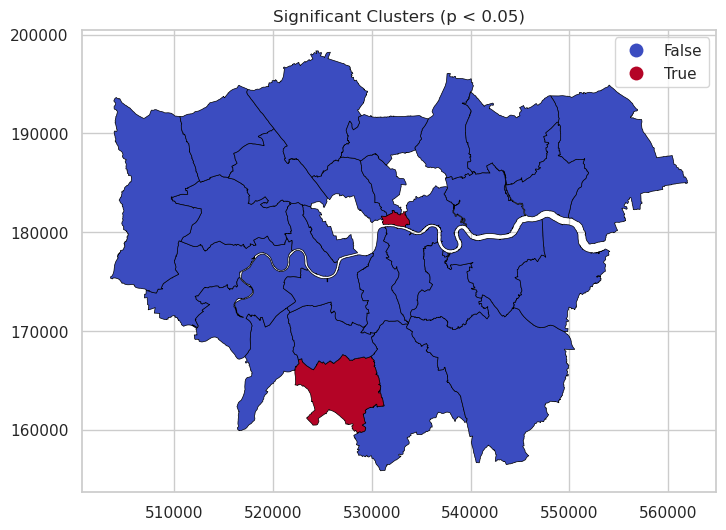

In [68]:
# 绘制局部 Moran's I 值的分布
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='Moran_I', cmap='coolwarm', edgecolor='black', linewidth=0.5, legend=True, ax=ax)
ax.set_title('Local Moran\'s I for Retail Lifetime')
plt.show()

# 绘制显著性区域
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='significant', cmap='coolwarm', edgecolor='black', linewidth=0.5, legend=True, ax=ax)
ax.set_title('Significant Clusters (p < 0.05)')
plt.show()

In [69]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt

# 加载Shapefile
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

# 加载零售寿命数据
csv_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'
retail_data = pd.read_csv(csv_path)

# 合并数据
gdf = gdf.merge(retail_data, left_on='NAME', right_on='borough')

# 创建基于女王邻接规则的空间权重矩阵
w = Queen.from_dataframe(gdf, use_index=False)

# 计算全局 Moran's I
y = gdf['retail_lifetime'].values
moran = Moran(y, w)

In [70]:
import numpy as np
from libpysal.weights import lag_spatial

# 标准化变量值
z = (y - np.mean(y)) / np.std(y)

# 计算空间滞后平均值
w_lag = lag_spatial(w, z)

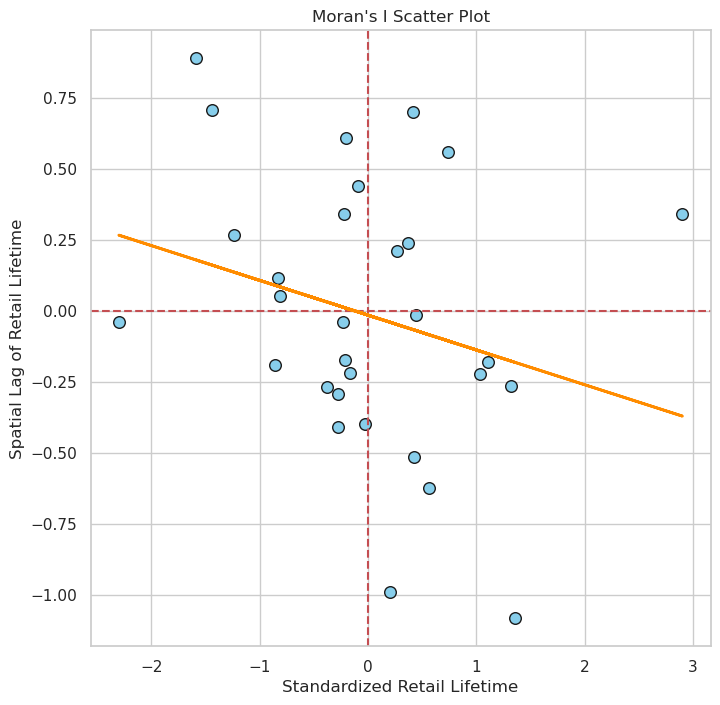

In [71]:
# 绘制散点图
plt.figure(figsize=(8, 8))
plt.scatter(z, w_lag, edgecolor='k', facecolor='skyblue', s=70)
plt.axhline(0, color='r', linestyle='--')
plt.axvline(0, color='r', linestyle='--')

# 绘制回归直线
b, a = np.polyfit(z, w_lag, 1)
plt.plot(z, a + b * z, color='darkorange', linewidth=2)

# 标题和标签
plt.title("Moran's I Scatter Plot")
plt.xlabel("Standardized Retail Lifetime")
plt.ylabel("Spatial Lag of Retail Lifetime")
plt.show()


In [72]:
import numpy as np
from libpysal.weights import lag_spatial
import matplotlib.pyplot as plt

# 标准化零售寿命数据
z = (y - np.mean(y)) / np.std(y)

# 计算空间滞后值
w_lag = lag_spatial(w, z)

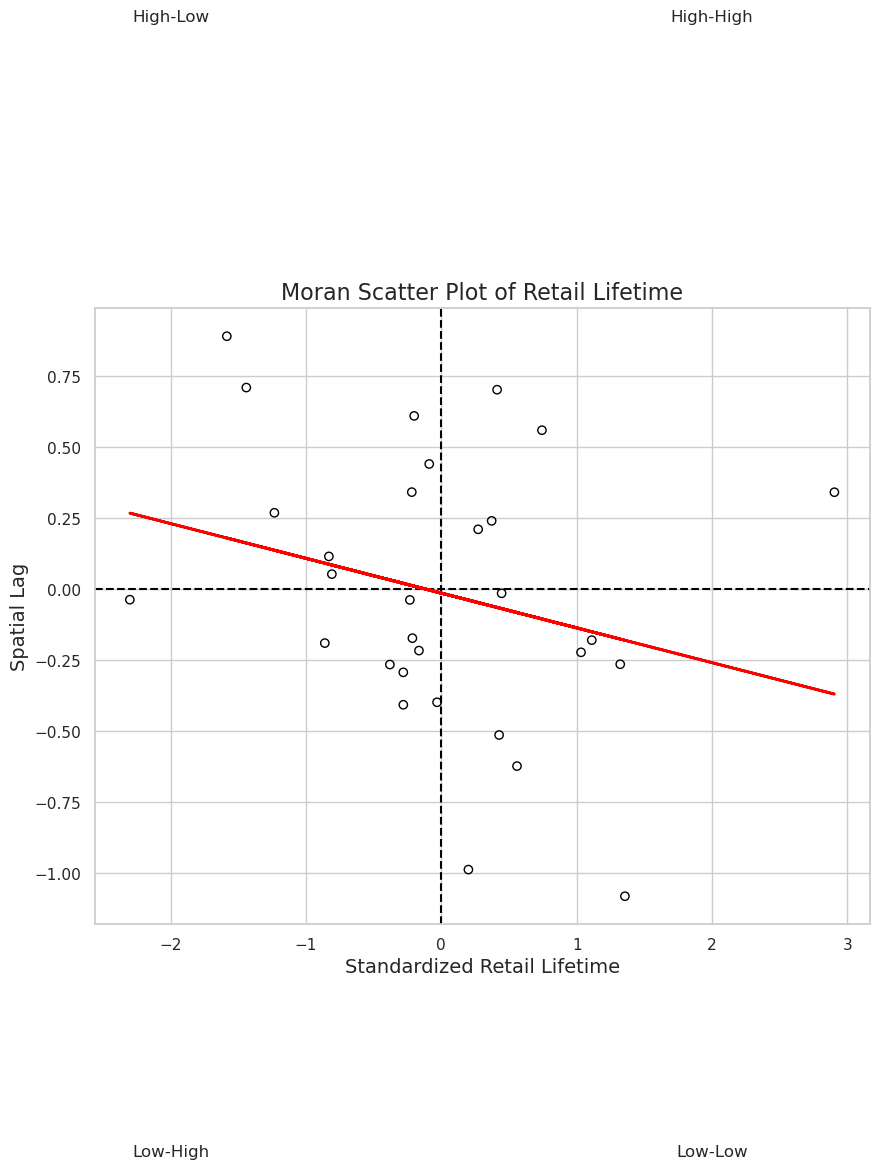

In [73]:
# 创建散点图
plt.figure(figsize=(10, 8))
plt.scatter(z, w_lag, edgecolor='black', facecolor='none')

# 绘制X轴和Y轴的参考线
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# 添加象限标签
plt.text(2, -2, 'Low-Low', fontsize=12, ha='center')
plt.text(-2, -2, 'Low-High', fontsize=12, ha='center')
plt.text(-2, 2, 'High-Low', fontsize=12, ha='center')
plt.text(2, 2, 'High-High', fontsize=12, ha='center')

# 添加回归线（Moran's I 线）
b, a = np.polyfit(z, w_lag, 1)
plt.plot(z, a + b * z, color='red', linewidth=2)

# 设置标题和标签
plt.title("Moran Scatter Plot of Retail Lifetime", fontsize=16)
plt.xlabel("Standardized Retail Lifetime", fontsize=14)
plt.ylabel("Spatial Lag", fontsize=14)
plt.grid(True)

# 显示图表
plt.show()

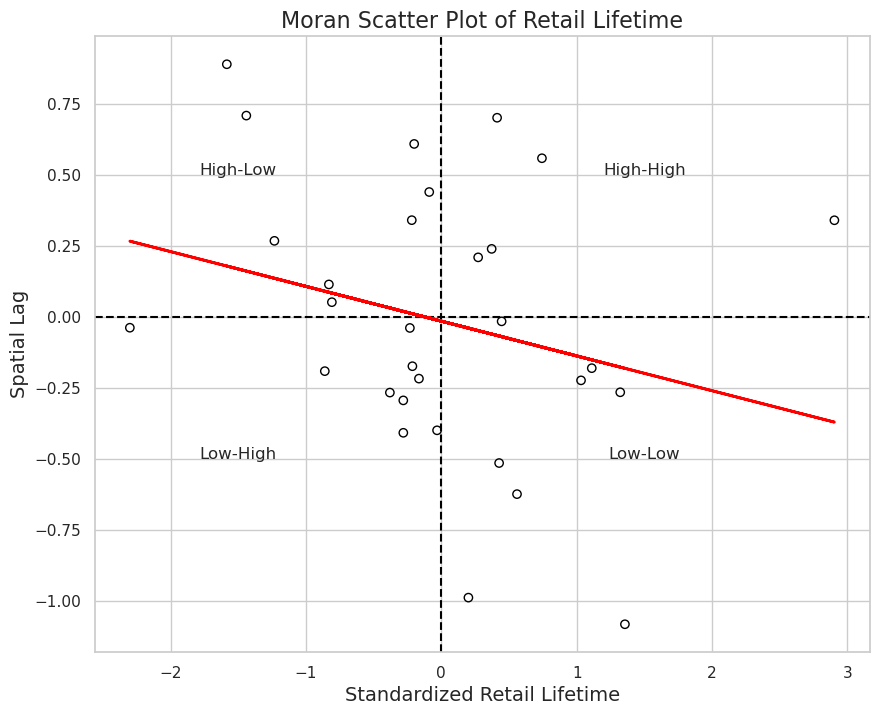

In [74]:
# 创建散点图
plt.figure(figsize=(10, 8))
plt.scatter(z, w_lag, edgecolor='black', facecolor='none')

# 绘制X轴和Y轴的参考线
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# 添加象限标签，更接近图形中心
plt.text(1.5, -0.5, 'Low-Low', fontsize=12, ha='center')
plt.text(-1.5, -0.5, 'Low-High', fontsize=12, ha='center')
plt.text(-1.5, 0.5, 'High-Low', fontsize=12, ha='center')
plt.text(1.5, 0.5, 'High-High', fontsize=12, ha='center')

# 添加回归线（Moran's I 线）
b, a = np.polyfit(z, w_lag, 1)
plt.plot(z, a + b * z, color='red', linewidth=2)

# 设置标题和标签
plt.title("Moran Scatter Plot of Retail Lifetime", fontsize=16)
plt.xlabel("Standardized Retail Lifetime", fontsize=14)
plt.ylabel("Spatial Lag", fontsize=14)
plt.grid(True)

# 显示图表
plt.show()

In [75]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# 加载Shapefile
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

# 加载零售寿命数据
csv_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'
retail_data = pd.read_csv(csv_path)

# 合并数据
gdf = gdf.merge(retail_data, left_on='NAME', right_on='borough')

# 创建基于女王邻接规则的空间权重矩阵
w = Queen.from_dataframe(gdf, use_index=False)

# 计算局部 Moran's I
y = gdf['retail_lifetime'].values
moran_local = Moran_Local(y, w)

# 添加局部Moran's I的结果到gdf
gdf['local_I'] = moran_local.Is
gdf['p_value'] = moran_local.p_sim

# 创建一个分类来区分高-高，低-低，高-低，低-高
gdf['quadrant'] = 0
gdf.loc[(gdf['local_I'] > 0) & (gdf['retail_lifetime'] > gdf['retail_lifetime'].mean()), 'quadrant'] = 1  # HH
gdf.loc[(gdf['local_I'] > 0) & (gdf['retail_lifetime'] <= gdf['retail_lifetime'].mean()), 'quadrant'] = 2  # LL
gdf.loc[(gdf['local_I'] < 0) & (gdf['retail_lifetime'] > gdf['retail_lifetime'].mean()), 'quadrant'] = 3  # HL
gdf.loc[(gdf['local_I'] < 0) & (gdf['retail_lifetime'] <= gdf['retail_lifetime'].mean()), 'quadrant'] = 4  # LH

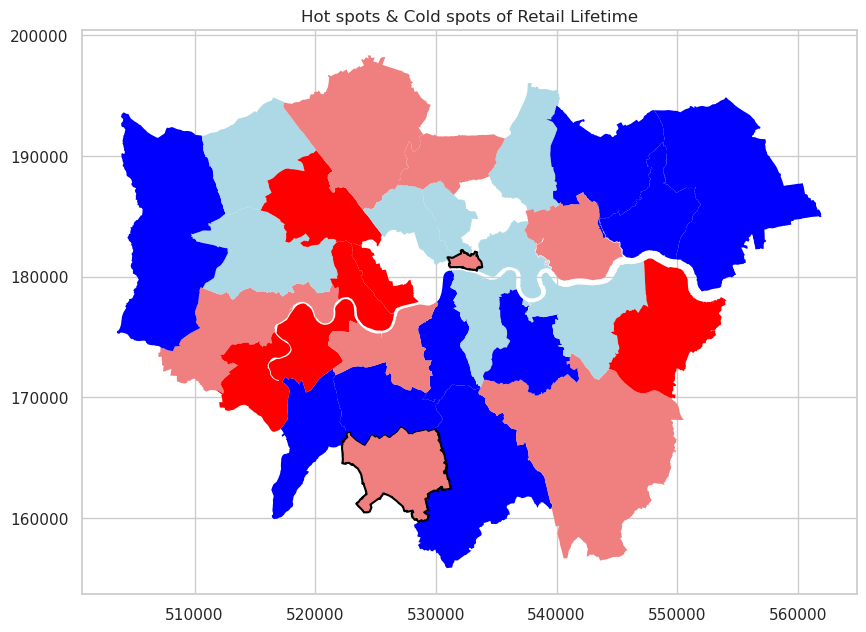

In [76]:
import matplotlib.colors as mcolors

# 设置颜色映射
colors = {
    1: 'red',       # High-High
    2: 'blue',      # Low-Low
    3: 'lightcoral',# High-Low
    4: 'lightblue'  # Low-High
}

# 将分类的颜色分配给每个区域
gdf['color'] = gdf['quadrant'].map(colors)

# 设置黑色边框的条件
gdf['edgecolor'] = gdf['p_value'].apply(lambda x: 'black' if x < 0.05 else 'none')

# 绘制地图
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor=gdf['edgecolor'], linewidth=1.5)

# 设置标题
plt.title("Hot spots & Cold spots of Retail Lifetime")
plt.show()

In [77]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# 假设已加载Shapefile和数据
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

csv_path = '/home/jovyan/CASA_Study/DS/borough_lifetime_occupy_sorted.csv'
retail_data = pd.read_csv(csv_path)

# 合并数据
gdf = gdf.merge(retail_data, left_on='NAME', right_on='borough')

# 创建基于女王邻接规则的空间权重矩阵
w = Queen.from_dataframe(gdf, use_index=False)

# 计算局部 Moran's I
y = gdf['retail_lifetime'].values
moran_local = Moran_Local(y, w)

# 添加局部Moran's I的结果到gdf
gdf['local_I'] = moran_local.Is
gdf['p_value'] = moran_local.p_sim

# 创建一个分类来区分高-高，低-低，高-低，低-高
gdf['quadrant'] = 0
gdf.loc[(gdf['local_I'] > 0) & (gdf['retail_lifetime'] > gdf['retail_lifetime'].mean()), 'quadrant'] = 1  # HH
gdf.loc[(gdf['local_I'] > 0) & (gdf['retail_lifetime'] <= gdf['retail_lifetime'].mean()), 'quadrant'] = 2  # LL
gdf.loc[(gdf['local_I'] < 0) & (gdf['retail_lifetime'] > gdf['retail_lifetime'].mean()), 'quadrant'] = 3  # HL
gdf.loc[(gdf['local_I'] < 0) & (gdf['retail_lifetime'] <= gdf['retail_lifetime'].mean()), 'quadrant'] = 4  # LH

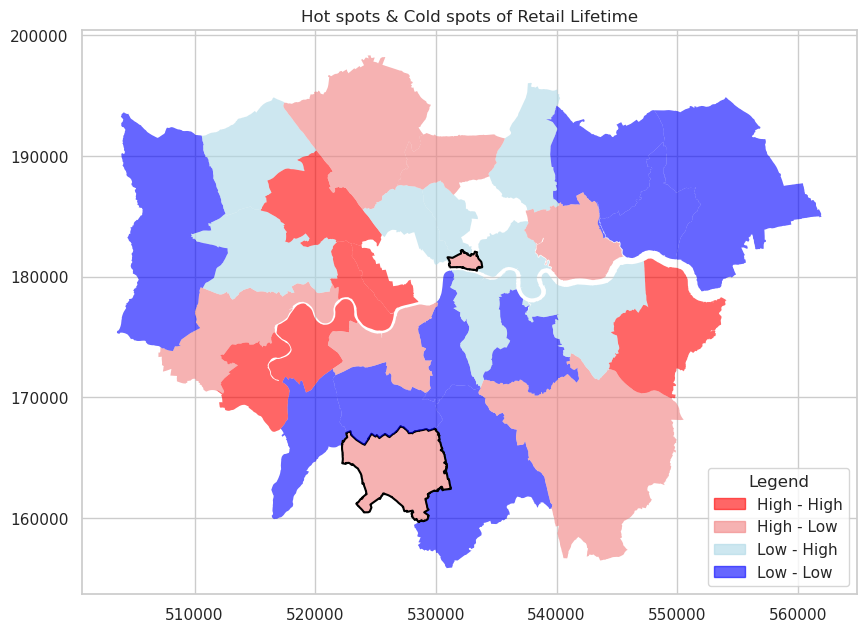

In [79]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# 设置带有透明度的颜色映射
colors = {
    1: mcolors.to_rgba('red', alpha=0.6),       # High-High
    2: mcolors.to_rgba('blue', alpha=0.6),      # Low-Low
    3: mcolors.to_rgba('lightcoral', alpha=0.6),# High-Low
    4: mcolors.to_rgba('lightblue', alpha=0.6)  # Low-High
}

# 将分类的颜色分配给每个区域
gdf['color'] = gdf['quadrant'].map(colors)

# 设置黑色边框的条件
gdf['edgecolor'] = gdf['p_value'].apply(lambda x: 'black' if x < 0.05 else 'none')

# 绘制地图
fig, ax = plt.subplots(1, figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor=gdf['edgecolor'], linewidth=1.5)

# 添加图例，移动到右下角
handles = [
    mpatches.Patch(color=mcolors.to_rgba('red', alpha=0.6), label='High - High'),
    mpatches.Patch(color=mcolors.to_rgba('lightcoral', alpha=0.6), label='High - Low'),
    mpatches.Patch(color=mcolors.to_rgba('lightblue', alpha=0.6), label='Low - High'),
    mpatches.Patch(color=mcolors.to_rgba('blue', alpha=0.6), label='Low - Low')
]

ax.legend(handles=handles, title="Legend", loc='lower right')

# 设置标题
plt.title("Hot spots & Cold spots of Retail Lifetime")
plt.show()

In [80]:
import pandas as pd
import statsmodels.api as sm

# Load the dataset with the correct variable name
merged_data1 = pd.read_csv('/home/jovyan/CASA_Study/DS/merged_data1.csv')

# Define the dependent variable (y) and independent variables (X)
y = merged_data1['retail_lifetime']
X = merged_data1.drop(columns=['borough', 'retail_lifetime'])

# Add a constant (intercept) to the independent variables matrix
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(y, X).fit()

# Get the summary of the OLS regression
summary = model.summary()

# Extract the coefficients, standard errors, p-values, and adjusted R-squared
coefficients = model.params
standard_errors = model.bse
p_values = model.pvalues
adjusted_r_squared = model.rsquared_adj

# Create a DataFrame to display the results in a similar format to the provided example
results_df = pd.DataFrame({
    'Variables': X.columns,
    'Coefficient Estimations': coefficients,
    'Standard Error': standard_errors,
    'p-values': p_values
})

results_df['Adjusted R^2'] = adjusted_r_squared

# Display the DataFrame directly
print(results_df)

                                                     Variables  \
const                                                    const   
vacancy_rate                                      vacancy_rate   
tax_relief_rate                                tax_relief_rate   
voaRateableValue                              voaRateableValue   
population2023                                  population2023   
Crime Rate (%)                                  Crime Rate (%)   
Mean Income                                        Mean Income   
Shop Density (shops per sq km)  Shop Density (shops per sq km)   

                                Coefficient Estimations  Standard Error  \
const                                       3196.404378     2245.850798   
vacancy_rate                                  11.202655       29.724878   
tax_relief_rate                              -10.121671       22.393921   
voaRateableValue                               0.013281        0.018910   
population2023                

In [81]:
import pandas as pd

# 加载CSV文件
merged_data1 = pd.read_csv('/home/jovyan/CASA_Study/DS/merged_data1.csv')

# 加载Excel文件
traffic_flow_data = pd.read_excel('/home/jovyan/CASA_Study/DS/traffic-flow-borough.xlsx')

# 确保列名称中的空格被移除，并准备进行合并
merged_data1['borough'] = merged_data1['borough'].str.strip()
traffic_flow_data['Local Authority'] = traffic_flow_data['Local Authority'].str.strip()

# 合并数据集
merged_data_with_traffic = pd.merge(merged_data1, traffic_flow_data, left_on='borough', right_on='Local Authority', how='left')

# 查看合并后的数据集
print(merged_data_with_traffic.head())

# 将合并后的数据保存到新的CSV文件中
merged_data_with_traffic.to_csv('merged_data_with_traffic.csv', index=False)


                borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0  Barking and Dagenham          2674.55         12.26            71.76   
1                Barnet          4091.06         36.51            72.20   
2                Bexley          3749.40          8.16            87.74   
3                 Brent          3191.90          8.36            74.48   
4               Bromley          4433.63         26.38            62.80   

   voaRateableValue  population2023  Crime Rate (%)  Mean Income  \
0          34201.99        227884.0            8.98      31800.0   
1          36743.32        399548.0            6.89      59100.0   
2          32802.80        249998.0            6.41      38000.0   
3          24530.66        353901.0            8.69      44100.0   
4          42226.67        334075.0            6.82      54500.0   

   Shop Density (shops per sq km)    LA Code  ...    2013    2014    2015  \
0                           89.67  E09000002  ...   632.0   653

In [82]:
import pandas as pd

# 假设merged_data_with_traffic是你已经合并后的数据集
# 提取2022 [note 7] 列并将其重命名为 traffic-flow
merged_data_with_traffic = merged_data_with_traffic.rename(columns={'2022 [note 7]': 'traffic-flow'})

# 删除其他年份的数据列
columns_to_drop = [col for col in merged_data_with_traffic.columns if '20' in col and col != 'traffic-flow']
merged_data_with_traffic = merged_data_with_traffic.drop(columns=columns_to_drop)

# 查看结果
print(merged_data_with_traffic.head())

# 保存到新的CSV文件
merged_data_with_traffic.to_csv('merged_data_with_traffic_flow.csv', index=False)

                borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0  Barking and Dagenham          2674.55         12.26            71.76   
1                Barnet          4091.06         36.51            72.20   
2                Bexley          3749.40          8.16            87.74   
3                 Brent          3191.90          8.36            74.48   
4               Bromley          4433.63         26.38            62.80   

   voaRateableValue  Crime Rate (%)  Mean Income  \
0          34201.99            8.98      31800.0   
1          36743.32            6.89      59100.0   
2          32802.80            6.41      38000.0   
3          24530.66            8.69      44100.0   
4          42226.67            6.82      54500.0   

   Shop Density (shops per sq km)    LA Code       Local Authority    1993  \
0                           89.67  E09000002  Barking and Dagenham   552.0   
1                          159.73  E09000003                Barnet  1548.0   
2 

In [83]:
import pandas as pd

# 假设 merged_data_with_traffic 是你已经合并后的数据集
# 重命名 '2022 [note 7]' 列为 'traffic-flow'
merged_data_with_traffic = merged_data_with_traffic.rename(columns={'2022 [note 7]': 'traffic-flow'})

# 删除其他年份数据以及 'LA Code' 和 'Local Authority' 列
columns_to_drop = [col for col in merged_data_with_traffic.columns if col.startswith('19') or col.startswith('20') and col != 'traffic-flow']
columns_to_drop += ['LA Code', 'Local Authority']
merged_data2 = merged_data_with_traffic.drop(columns=columns_to_drop)

# 打印整体数据
print(merged_data2)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham          2674.55         12.26            71.76   
1                   Barnet          4091.06         36.51            72.20   
2                   Bexley          3749.40          8.16            87.74   
3                    Brent          3191.90          8.36            74.48   
4                  Bromley          4433.63         26.38            62.80   
5                   Camden          1165.88         18.91            79.61   
6                  Croydon          2420.52         11.41            65.03   
7                   Ealing          1913.51         12.15            78.97   
8                Greenwich          2632.75         11.10            65.98   
9   Hammersmith and Fulham          3357.53         13.27            76.11   
10                Haringey          4184.88          8.48            74.91   
11                  Harrow          1887.43          2.91       

In [84]:
y = merged_data2['retail_lifetime']
X = merged_data2.drop(columns=['borough', 'retail_lifetime'])

# 添加常数项（截距项）
X = sm.add_constant(X)

# 执行OLS回归分析
model = sm.OLS(y, X).fit()

# 获取回归结果的摘要
summary = model.summary()

# 显示结果
print(summary)

                            OLS Regression Results                            
Dep. Variable:        retail_lifetime   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     2.097
Date:                Fri, 16 Aug 2024   Prob (F-statistic):             0.0918
Time:                        23:49:36   Log-Likelihood:                -227.29
No. Observations:                  28   AIC:                             470.6
Df Residuals:                      20   BIC:                             481.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [85]:
y = merged_data2['retail_lifetime']
X = merged_data2.drop(columns=['borough', 'retail_lifetime'])

# 添加常数项（截距项）
X = sm.add_constant(X)

# 执行 OLS 回归分析
model = sm.OLS(y, X).fit()

# 提取结果
coefficients = model.params
standard_errors = model.bse
p_values = model.pvalues
adjusted_r_squared = model.rsquared_adj

# 创建结果表
results_df = pd.DataFrame({
    'Variables': X.columns,
    'Coefficient Estimations': coefficients,
    'Standard Error': standard_errors,
    'p-values': p_values
})

# 添加 Adjusted R^2 行
adjusted_r_squared_row = pd.DataFrame({
    'Variables': ['Adjusted R^2'],
    'Coefficient Estimations': [None],
    'Standard Error': [None],
    'p-values': [adjusted_r_squared]
})

results_df = pd.concat([results_df, adjusted_r_squared_row], ignore_index=True)

# 将结果保存为 Excel 文件
results_df.to_excel('OLS_Regression_Results_Table.xlsx', index=False)

print(results_df)

                        Variables  Coefficient Estimations  Standard Error  \
0                           const              3875.254390     1826.434750   
1                    vacancy_rate                16.541835       28.270866   
2                 tax_relief_rate               -12.593493       22.022246   
3                voaRateableValue                 0.009360        0.018597   
4                  Crime Rate (%)              -220.916615       97.308631   
5                     Mean Income                 0.021126        0.011375   
6  Shop Density (shops per sq km)                 0.126266        0.782825   
7                    traffic-flow                 0.083778        0.505578   
8                    Adjusted R^2                      NaN             NaN   

   p-values  
0  0.046543  
1  0.565011  
2  0.573793  
3  0.620231  
4  0.034398  
5  0.078065  
6  0.873479  
7  0.870050  
8  0.221481  


/tmp/ipykernel_60037/2754289839.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, adjusted_r_squared_row], ignore_index=True)


In [86]:
import pandas as pd
import statsmodels.api as sm

# 假设 merged_data2 是你已经清理好的数据集
# 例如，如果需要重新加载数据，可以使用以下代码加载数据：
# merged_data2 = pd.read_csv('path_to_your_merged_data2.csv')

# 定义因变量 y 和自变量 X
y = merged_data2['retail_lifetime']
X = merged_data2.drop(columns=['borough', 'retail_lifetime'])

# 添加常数项（截距项）
X = sm.add_constant(X)

# 执行 OLS 回归分析
model = sm.OLS(y, X).fit()

# 提取结果
coefficients = model.params
standard_errors = model.bse
p_values = model.pvalues
adjusted_r_squared = model.rsquared_adj

# 创建结果表
results_df = pd.DataFrame({
    'Variables': X.columns,
    'Coefficient Estimations': coefficients,
    'Standard Error': standard_errors,
    'p-values': p_values
})

# 添加 Adjusted R^2 行，仅添加非空的值
adjusted_r_squared_row = pd.DataFrame({
    'Variables': ['Adjusted R^2'],
    'Coefficient Estimations': [None],
    'Standard Error': [None],
    'p-values': [adjusted_r_squared]
}).dropna(axis=1, how='all')

results_df = pd.concat([results_df, adjusted_r_squared_row], ignore_index=True)

# 将结果保存为 Excel 文件
results_df.to_excel('OLS_Regression_Results_Table.xlsx', index=False)

print(results_df)

                        Variables  Coefficient Estimations  Standard Error  \
0                           const              3875.254390     1826.434750   
1                    vacancy_rate                16.541835       28.270866   
2                 tax_relief_rate               -12.593493       22.022246   
3                voaRateableValue                 0.009360        0.018597   
4                  Crime Rate (%)              -220.916615       97.308631   
5                     Mean Income                 0.021126        0.011375   
6  Shop Density (shops per sq km)                 0.126266        0.782825   
7                    traffic-flow                 0.083778        0.505578   
8                    Adjusted R^2                      NaN             NaN   

   p-values  
0  0.046543  
1  0.565011  
2  0.573793  
3  0.620231  
4  0.034398  
5  0.078065  
6  0.873479  
7  0.870050  
8  0.221481  


In [87]:
import pandas as pd

# 创建一个DataFrame以保存你的结果
results_df = pd.DataFrame({
    'Variables': ['const', 'vacancy_rate', 'tax_relief_rate', 'voaRateableValue', 
                  'Crime Rate (%)', 'Mean Income', 'Shop Density (shops per sq km)', 
                  'traffic-flow', 'Adjusted R^2'],
    'Coefficient Estimations': [3875.254390, 16.541835, -12.593493, 0.009360, 
                                -220.916615, 0.021126, 0.126266, 0.083778, None],
    'Standard Error': [1826.434750, 28.270866, 22.022246, 0.018597, 97.308631, 
                       0.011375, 0.782825, 0.505578, None],
    'p-values': [0.046543, 0.565011, 0.573793, 0.620231, 0.034398, 0.078065, 
                 0.873479, 0.870050, 0.221481]
})

# 保存为Excel文件
results_df.to_excel('OLS_Regression_Results_Table_Final.xlsx', index=False)

print("Results have been saved to 'OLS_Regression_Results_Table_Final.xlsx'")

Results have been saved to 'OLS_Regression_Results_Table_Final.xlsx'


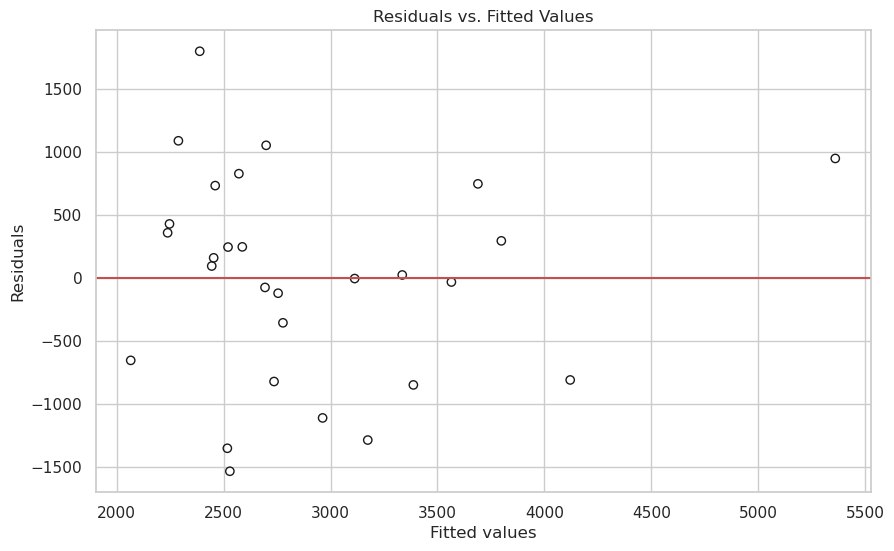

In [88]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 假设你已经运行了 OLS 回归并生成了 model
# 生成预测值和残差
fitted_values = model.fittedvalues
residuals = model.resid

# 创建残差与拟合值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, edgecolors='k', facecolors='none')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')

# 保存图像为文件
plt.savefig('residuals_vs_fitted_plot.png', bbox_inches='tight')

# 显示图像
plt.show()

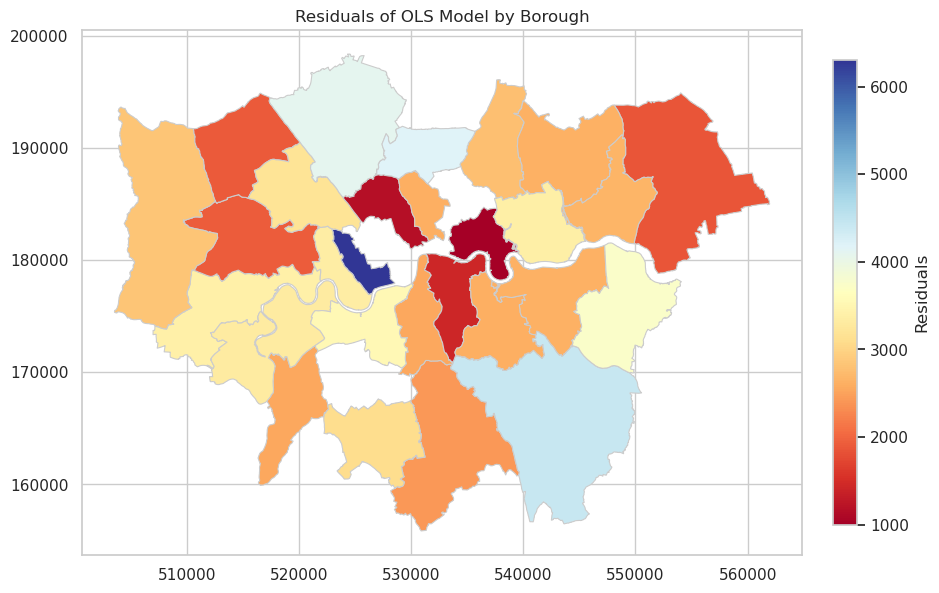

In [89]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. 对每个行政区计算残差
# 从 merged_data2 提取自变量数据
X = merged_data2.drop(columns=['borough', 'retail_lifetime'])
X = sm.add_constant(X)  # 添加常数项

# 使用 results_df 中的回归系数计算预测值
coefficients = results_df['Coefficient Estimations'][:-1]  # 排除 Adjusted R^2

# 确保 coefficients 只包含与 X.columns 匹配的列
coefficients = coefficients.loc[coefficients.index.isin(X.columns)]

# 确保 X.columns 只包含与 coefficients 匹配的列
X = X[coefficients.index]

# 计算预测值
fitted_values = X.dot(coefficients)

# 计算残差
merged_data2['residuals'] = merged_data2['retail_lifetime'] - fitted_values

# 2. 将残差与地理数据（Shapefile）合并
gdf = gpd.read_file('/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp')

merged_gdf = gdf.merge(merged_data2, left_on='NAME', right_on='borough')

# 3. 创建 Choropleth 地图并调整 colorbar 大小
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf.plot(column='residuals', cmap='RdYlBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# 调整 colorbar 的大小
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=merged_gdf['residuals'].min(), vmax=merged_gdf['residuals'].max()))
sm._A = []  # 设置一个伪数据用于colorbar的创建
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)

# 添加 colorbar 标签
cbar.set_label('Residuals')

# 添加标题
plt.title('Residuals of OLS Model by Borough')

# 保存图像为文件
plt.savefig('residuals_choropleth_map_with_label.png', bbox_inches='tight')

# 显示地图
plt.show()


In [90]:
import geopandas as gpd
import pandas as pd

# 读取 Shapefile 文件
shapefile_path = '/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp'
gdf = gpd.read_file(shapefile_path)

# 计算几何中心点（centroid）
gdf['centroid'] = gdf.geometry.centroid

# 提取经纬度信息
gdf['latitude'] = gdf.centroid.y
gdf['longitude'] = gdf.centroid.x

# 选择需要的列 (包括行政区名称、经纬度)
borough_centroids = gdf[['NAME', 'latitude', 'longitude']]


In [91]:
# 假设 merged_data2 已经加载，且包含 borough 列
merged_data2 = pd.merge(merged_data2, borough_centroids, left_on='borough', right_on='NAME', how='left')


In [92]:
# 如果 merged_data2 中有冲突的列名，可以选择先删除这些列
merged_data2 = merged_data2.drop(columns=['latitude', 'longitude', 'NAME'], errors='ignore')

# 然后进行合并
merged_data2 = pd.merge(merged_data2, borough_centroids, left_on='borough', right_on='NAME', how='left')


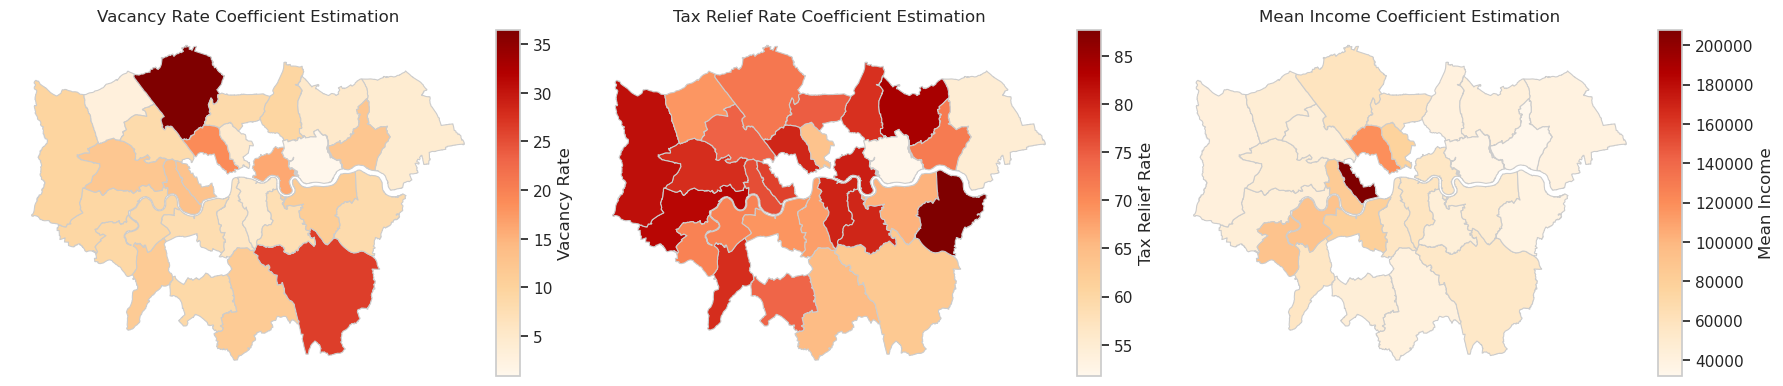

In [93]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 加载原始数据
merged_data2 = pd.read_csv('/home/jovyan/CASA_Study/DS/merged_data_with_traffic_flow.csv')  # 更新文件路径

# 加载伦敦行政区的Shapefile
gdf = gpd.read_file('/home/jovyan/CASA_Study/ESRI/London_Borough_Excluding_MHW.shp')

# 假设GWR模型结果在merged_data2中已生成为 "gwr_results"
gwr_results = merged_data2[['borough', 'vacancy_rate', 'tax_relief_rate', 'Mean Income']]

# 将GWR结果与地理数据合并
gdf = gdf.merge(gwr_results, left_on='NAME', right_on='borough')

# 定义要可视化的变量
variables = ['vacancy_rate', 'tax_relief_rate', 'Mean Income']
titles = ['Vacancy Rate Coefficient Estimation', 'Tax Relief Rate Coefficient Estimation', 'Mean Income Coefficient Estimation']

# 生成地图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, var in enumerate(variables):
    ax = axes[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # 绘制地图
    gdf.plot(column=var, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)
    ax.set_title(titles[i])
    ax.axis('off')
    
    # 添加颜色条的标注
    cax.set_ylabel(var.replace('_', ' ').title())

plt.tight_layout()
plt.show()


In [94]:
print(merged_data2)

                   borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0     Barking and Dagenham          2674.55         12.26            71.76   
1                   Barnet          4091.06         36.51            72.20   
2                   Bexley          3749.40          8.16            87.74   
3                    Brent          3191.90          8.36            74.48   
4                  Bromley          4433.63         26.38            62.80   
5                   Camden          1165.88         18.91            79.61   
6                  Croydon          2420.52         11.41            65.03   
7                   Ealing          1913.51         12.15            78.97   
8                Greenwich          2632.75         11.10            65.98   
9   Hammersmith and Fulham          3357.53         13.27            76.11   
10                Haringey          4184.88          8.48            74.91   
11                  Harrow          1887.43          2.91       

In [95]:
# Deleting specified columns
columns_to_delete = ['LA Code', 'Local Authority', '1993', '1994', '1995', '1996', '1997', '1998', '1999']
merged_data2 = merged_data2.drop(columns=columns_to_delete)

# Display the first few rows to confirm
print(merged_data2.head())

                borough  retail_lifetime  vacancy_rate  tax_relief_rate  \
0  Barking and Dagenham          2674.55         12.26            71.76   
1                Barnet          4091.06         36.51            72.20   
2                Bexley          3749.40          8.16            87.74   
3                 Brent          3191.90          8.36            74.48   
4               Bromley          4433.63         26.38            62.80   

   voaRateableValue  Crime Rate (%)  Mean Income  \
0          34201.99            8.98      31800.0   
1          36743.32            6.89      59100.0   
2          32802.80            6.41      38000.0   
3          24530.66            8.69      44100.0   
4          42226.67            6.82      54500.0   

   Shop Density (shops per sq km)  traffic-flow  
0                           89.67         641.0  
1                          159.73        1646.0  
2                          134.87         992.0  
3                          502.13   

In [ ]:
import geopandas as gpd

# 读取Shapefile文件，假设Shapefile文件中包含伦敦各行政区的边界信息
shapefile_path = 'path_to_london_shapefile.shp'  # 替换为实际Shapefile文件路径
gdf = gpd.read_file(shapefile_path)

# 计算每个行政区的几何中心点
gdf['centroid'] = gdf.geometry.centroid

# 提取中心点坐标（X 和 Y）
gdf['centroid_x'] = gdf.centroid.x
gdf['centroid_y'] = gdf.centroid.y

# 显示前几行数据
print(gdf[['borough', 'centroid_x', 'centroid_y']].head())